In [5]:
%pip install git+https://github.com/metadriverse/metadrive.git
!pip install stable-baselines3  # For PPO experiments
!pip install gym  # Ensure gym is installed


  Cloning https://github.com/metadriverse/metadrive.git to /tmp/pip-req-build-7r_ptbas
  Running command git clone --filter=blob:none --quiet https://github.com/metadriverse/metadrive.git /tmp/pip-req-build-7r_ptbas
  Resolved https://github.com/metadriverse/metadrive.git to commit b908149e422f2e7715207ca1eb81380342de5681
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 84.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 72.1 MB/s eta 0:00:00
  Created wheel for metadrive-simulator: filename=metadrive_simulator-0.4.3-py3-none-any.whl size=55022091 sha256=48925

In [6]:
!apt-get install -y xvfb python-opengl ffmpeg

!pip install pyvirtualdisplay

!sudo apt-get update
!sudo apt-get install -y xvfb


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python-opengl
Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,636 kB]
Get:12 https://r2u.sta

In [7]:
import os
import numpy as np
from stable_baselines3 import PPO
from metadrive.envs import MetaDriveEnv
from pyvirtualdisplay import Display
from PIL import Image
from IPython.display import display as ipy_display, clear_output
from stable_baselines3.common.monitor import Monitor
import matplotlib.pyplot as plt
from stable_baselines3.common.callbacks import BaseCallback


/usr/local/lib/python3.10/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

In [8]:
class PerformanceLogger(BaseCallback):
    def __init__(self, verbose=0):
        super(PerformanceLogger, self).__init__(verbose)
        self.timesteps = []
        self.rewards = []
        self.current_reward = 0

    def reset(self):
        """Reset the logger for a new training phase."""
        self.current_reward = 0


    def _on_step(self) -> bool:
        # Sum rewards from this step
        self.current_reward += sum(self.locals["rewards"])

        # Log rewards at the end of a rollout
        if self.n_calls % self.model.n_steps == 0:
            self.timesteps.append(self.num_timesteps)
            self.rewards.append(self.current_reward / self.model.n_steps)  # Average reward per step
            self.current_reward = 0  # Reset for next rollout
        return True


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
# Function to create the environment
def create_environment(difficulty, render=False, monitor=True):
    configs = {
        "easy": {"map": "C", "traffic_density": 0.1, "random_lane_width": False, "use_render": render,
                            #  "out_of_road_penalty": 30.0,  # Increased penalty
                #  "out_of_road_cost":


                 },
        "medium": {"map": "C", "traffic_density": 0.3, "random_lane_width": True, "use_render": render,
                              #  "out_of_road_penalty": 30.0,  # Increased penalty

                   },
        "hard": {"map": "C", "traffic_density": 0.5, "random_lane_width": True, "use_render": render},
    }

    base_env = MetaDriveEnv(configs[difficulty])
    if monitor:
        return Monitor(base_env)
    else:
      return base_env

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[WARNING] Assets folder doesn't exist. Begin to download assets... (base_engine.py:773)
[INFO] Pull assets from https://github.com/metadriverse/metadrive/releases/download/MetaDrive-0.4.3/assets.zip to /usr/local/lib/python3.10/dist-packages/metadrive/assets.zip

[INFO] Extracting assets.
[INFO] Successfully download assets, version: 0.4.3. MetaDrive version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


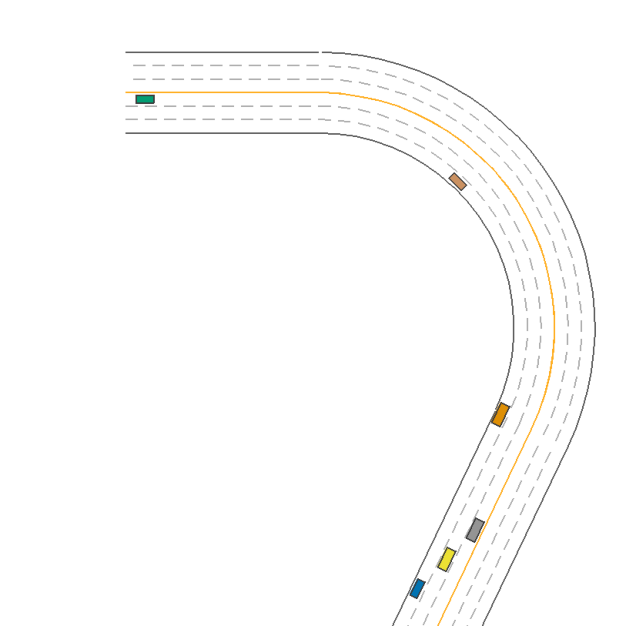

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


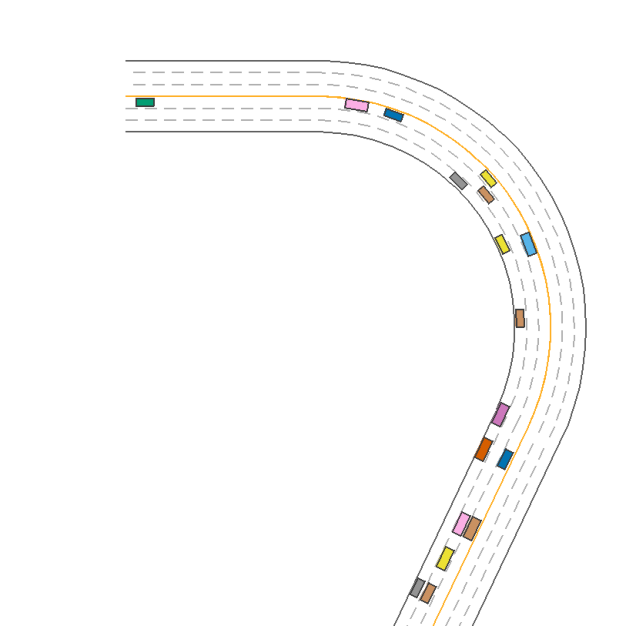

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


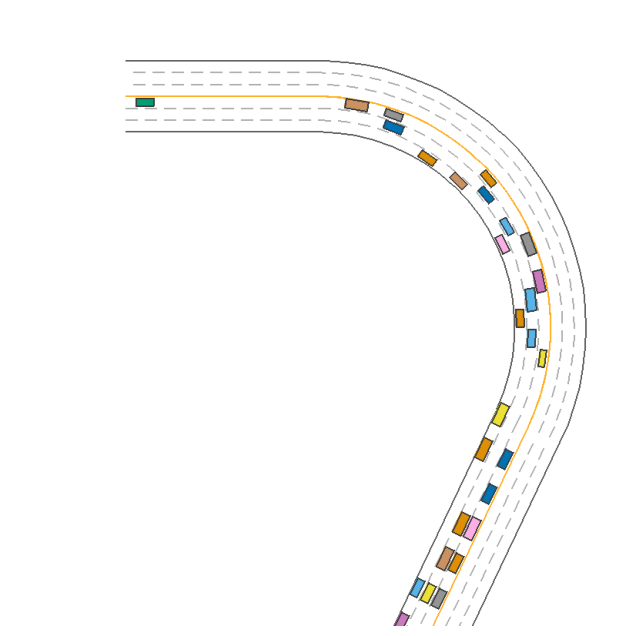

In [15]:
env = create_environment('easy', render=False, monitor=False)
obs, _ = env.reset()

ret = env.render(
    mode="topdown",  # Topdown visualization mode
    window=False,    # Do not open a rendering window
    screen_size=(800, 800),  # Resolution of the rendering
    camera_position=(50, -50)  # Position of the camera
)

# Close the environment after rendering
env.close()

# Visualize the rendered environment
plt.figure(figsize=(8, 8))
plt.axis("off")  # Remove axis
plt.imshow(ret)  # Display the rendered environment
plt.show()

env = create_environment('medium', render=False, monitor=False)
obs, _ = env.reset()

ret = env.render(
    mode="topdown",  # Topdown visualization mode
    window=False,    # Do not open a rendering window
    screen_size=(800, 800),  # Resolution of the rendering
    camera_position=(50, -50)  # Position of the camera
)

# Close the environment after rendering
env.close()

# Visualize the rendered environment
plt.figure(figsize=(8, 8))
plt.axis("off")  # Remove axis
plt.imshow(ret)  # Display the rendered environment
plt.show()

env = create_environment('hard', render=False, monitor=False)
obs, _ = env.reset()

ret = env.render(
    mode="topdown",  # Topdown visualization mode
    window=False,    # Do not open a rendering window
    screen_size=(800, 800),  # Resolution of the rendering
    camera_position=(50, -50)  # Position of the camera
)

# Close the environment after rendering
env.close()

# Visualize the rendered environment
plt.figure(figsize=(8, 8))
plt.axis("off")  # Remove axis
plt.imshow(ret)  # Display the rendered environment
plt.show()

In [4]:
def train_agent_with_transfer(env, timesteps=1000, model=None):
    logger = PerformanceLogger()
    if model is None:
        model = PPO("MlpPolicy", env, verbose=2, n_steps=4096) #changing n_step param significantly changes reward results, should play ard with this
    else:
        print("Continuing training with transfer learning...")
    logger.reset()  # Reset logger for the new training phase
    model.learn(total_timesteps=timesteps, callback=logger)
    return model, logger

In [5]:
def plot_performance(logger, title= 'Agent Performance'):
    """
    Plot the logged performance data.
    """
    if not logger.timesteps or not logger.rewards:
        print("[ERROR] No data to plot. Ensure rewards are logged during training.")
        return

    plt.figure(figsize=(12, 6))
    plt.plot(logger.timesteps, logger.rewards, label="Episode Rewards")
    plt.xlabel("Timesteps")
    plt.ylabel("Rewards")
    plt.title("Agent Performance Over Timesteps")
    plt.legend()
    plt.grid()
    plt.show()

In [11]:
# Curriculum experiment without transfer learning
def curriculum_experiment_no_transfer(difficulty_order, timesteps_per_difficulty=10000):
    results = []
    models = []
    for difficulty in difficulty_order:
        print(f"Training on {difficulty} difficulty (No Transfer)...")
        env = create_environment(difficulty, render=False)
        try:
            model, logger = train_agent_with_transfer(env, timesteps=timesteps_per_difficulty)
            results.append((difficulty, logger))
            models.append((difficulty, model))
        finally:
            env.close()

    # Plot performance for each difficulty
    for difficulty, logger in results:
        print(f"Performance for {difficulty} difficulty:")
        plot_performance(logger, f"Performance on {difficulty} (No Transfer)")
    return results,  models

In [10]:
# Curriculum experiment with transfer learning
def curriculum_experiment_with_transfer(difficulty_order, timesteps_per_difficulty=1000):
    model = None  # Start with no pretrained model
    logger = PerformanceLogger()
    results = []
    models = []

    for difficulty in difficulty_order:
        print(f"Training on {difficulty} difficulty (With Transfer)...")
        env = create_environment(difficulty, render=False)
        try:
            model, logger = train_agent_with_transfer(env, model=model, timesteps=timesteps_per_difficulty)
            results.append((difficulty, logger))
            models.append((difficulty, model))
        except Exception as e:
            print(f"Error during training on {difficulty} difficulty: {e}")
        finally:
            env.close()

    # Plot performance for each difficulty
    for difficulty, logger in results:
        print(f"Performance for {difficulty} difficulty:")
        plot_performance(logger, f"Performance on {difficulty} (With Transfer)")
    return results, models

In [ ]:
# Run the curriculum experiments
difficulty_order = ["easy", ]#"medium"#, "hard"]

# Experiment without transfer learning
# print("Running Curriculum Experiment WITHOUT Transfer Learning...")
# curriculum_experiment_no_transfer(difficulty_order, timesteps_per_difficulty=500)

# # Experiment with transfer learning
# print("Running Curriculum Experiment WITH Transfer Learning...")
# curriculum_experiment_with_transfer(difficulty_order, timesteps_per_difficulty=500)

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None


Training on easy difficulty (No Transfer)...
Using cuda device
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
[WARNING] Assets folder doesn't exist. Begin to download assets... (base_engine.py:773)
[INFO] Pull assets from https://github.com/metadriverse/metadrive/releases/download/MetaDrive-0.4.3/assets.zip to /usr/local/lib/python3.10/dist-packages/metadrive/assets.zip

[INFO] Extracting assets.
[INFO] Successfully download assets, version: 0.4.3. MetaDrive version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario In

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.12e+03 |
|    ep_rew_mean     | 9.84     |
| time/              |          |
|    fps             | 172      |
|    iterations      | 1        |
|    time_elapsed    | 23       |
|    total_timesteps | 4096     |
---------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.04e+03    |
|    ep_rew_mean          | 26.9        |
| time/                   |             |
|    fps                  | 189         |
|    iterations           | 2           |
|    time_elapsed         | 43          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.014715987 |
|    clip_fraction        | 0.204       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.81       |
|    explained_variance   | -0.00829    |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00461    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0144     |
|    std                  | 0.977       |
|    value_loss           | 0.118       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.25e+03    |
|    ep_rew_mean          | 17.7        |
| time/                   |             |
|    fps                  | 197         |
|    iterations           | 3           |
|    time_elapsed         | 62          |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.017696412 |
|    clip_fraction        | 0.234       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.77       |
|    explained_variance   | 0.0293      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0699      |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0177     |
|    std                  | 0.956       |
|    value_loss           | 0.136       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.2e+03     |
|    ep_rew_mean          | 22.2        |
| time/                   |             |
|    fps                  | 205         |
|    iterations           | 4           |
|    time_elapsed         | 79          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.011383516 |
|    clip_fraction        | 0.15        |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.73       |
|    explained_variance   | 0.00818     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.263       |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.0078     |
|    std                  | 0.942       |
|    value_loss           | 0.341       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.06e+03    |
|    ep_rew_mean          | 24.6        |
| time/                   |             |
|    fps                  | 203         |
|    iterations           | 5           |
|    time_elapsed         | 100         |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.017283274 |
|    clip_fraction        | 0.197       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.69       |
|    explained_variance   | 0.0672      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0258      |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.0131     |
|    std                  | 0.921       |
|    value_loss           | 0.349       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 904         |
|    ep_rew_mean          | 27.4        |
| time/                   |             |
|    fps                  | 206         |
|    iterations           | 6           |
|    time_elapsed         | 119         |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.014384224 |
|    clip_fraction        | 0.146       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.62       |
|    explained_variance   | 0.0266      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.248       |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.00932    |
|    std                  | 0.886       |
|    value_loss           | 0.595       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 622         |
|    ep_rew_mean          | 22.4        |
| time/                   |             |
|    fps                  | 201         |
|    iterations           | 7           |
|    time_elapsed         | 141         |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.011363325 |
|    clip_fraction        | 0.15        |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.57       |
|    explained_variance   | 0.0835      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.389       |
|    n_updates            | 60          |
|    policy_gradient_loss | -0.0106     |
|    std                  | 0.867       |
|    value_loss           | 0.915       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 528         |
|    ep_rew_mean          | 22.7        |
| time/                   |             |
|    fps                  | 199         |
|    iterations           | 8           |
|    time_elapsed         | 163         |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.007832265 |
|    clip_fraction        | 0.0615      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.5        |
|    explained_variance   | -0.0745     |
|    learning_rate        | 0.0003      |
|    loss                 | 1.6         |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.00465    |
|    std                  | 0.839       |
|    value_loss           | 2.82        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 413       |
|    ep_rew_mean          | 20.7      |
| time/                   |           |
|    fps                  | 195       |
|    iterations           | 9         |
|    time_elapsed         | 188       |
|    total_timesteps      | 36864     |
| train/                  |           |
|    approx_kl            | 0.0116472 |
|    clip_fraction        | 0.11      |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.46     |
|    explained_variance   | 0.1       |
|    learning_rate        | 0.0003    |
|    loss                 | 1.6       |
|    n_updates            | 80        |
|    policy_gradient_loss | -0.0075   |
|    std                  | 0.825     |
|    value_loss           | 2.53      |
---------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 167         |
|    ep_rew_mean          | 15.6        |
| time/                   |             |
|    fps                  | 190         |
|    iterations           | 10          |
|    time_elapsed         | 215         |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.005692968 |
|    clip_fraction        | 0.0393      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.43       |
|    explained_variance   | 0.302       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.67        |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.00315    |
|    std                  | 0.812       |
|    value_loss           | 3.92        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 122         |
|    ep_rew_mean          | 13.7        |
| time/                   |             |
|    fps                  | 184         |
|    iterations           | 11          |
|    time_elapsed         | 243         |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.005316859 |
|    clip_fraction        | 0.0398      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.4        |
|    explained_variance   | 0.452       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.02        |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.00229    |
|    std                  | 0.803       |
|    value_loss           | 3.33        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 125       |
|    ep_rew_mean          | 16.3      |
| time/                   |           |
|    fps                  | 182       |
|    iterations           | 12        |
|    time_elapsed         | 268       |
|    total_timesteps      | 49152     |
| train/                  |           |
|    approx_kl            | 0.0164776 |
|    clip_fraction        | 0.121     |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.38     |
|    explained_variance   | 0.721     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.51      |
|    n_updates            | 110       |
|    policy_gradient_loss | -0.0045   |
|    std                  | 0.795     |
|    value_loss           | 3.48      |
---------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 133         |
|    ep_rew_mean          | 20.2        |
| time/                   |             |
|    fps                  | 180         |
|    iterations           | 13          |
|    time_elapsed         | 294         |
|    total_timesteps      | 53248       |
| train/                  |             |
|    approx_kl            | 0.008093652 |
|    clip_fraction        | 0.131       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.37       |
|    explained_variance   | 0.513       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.83        |
|    n_updates            | 120         |
|    policy_gradient_loss | -0.00409    |
|    std                  | 0.789       |
|    value_loss           | 5.21        |
-----------------------------------------
Performance for easy difficulty:


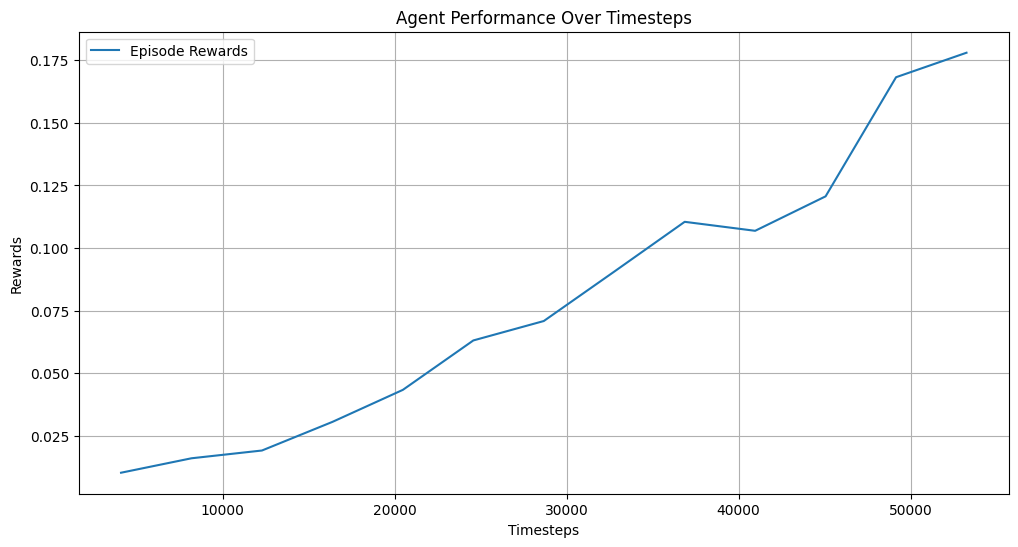

In [ ]:
results, models = curriculum_experiment_no_transfer(difficulty_order, timesteps_per_difficulty=50_000)

# Medium mode 300,000 time step

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None


Training on medium difficulty (No Transfer)...
Using cuda device
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.9e+03  |
|    ep_rew_mean     | 32.7     |
| time/              |          |
|    fps             | 186      |
|    iterations      | 1        |
|    time_elapsed    | 21       |
|    total_timesteps | 4096     |
---------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 2.33e+03   |
|    ep_rew_mean          | 31         |
| time/                   |            |
|    fps                  | 188        |
|    iterations           | 2          |
|    time_elapsed         | 43         |
|    total_timesteps      | 8192       |
| train/                  |            |
|    approx_kl            | 0.01841738 |
|    clip_fraction        | 0.235      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.81      |
|    explained_variance   | 0.00349    |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0443    |
|    n_updates            | 10         |
|    policy_gradient_loss | -0.0199    |
|    std                  | 0.976      |
|    value_loss           | 0.0614     |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 942         |
|    ep_rew_mean          | 13.9        |
| time/                   |             |
|    fps                  | 170         |
|    iterations           | 3           |
|    time_elapsed         | 72          |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.018798914 |
|    clip_fraction        | 0.239       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.76       |
|    explained_variance   | -0.00609    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00168     |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0173     |
|    std                  | 0.949       |
|    value_loss           | 0.136       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 859          |
|    ep_rew_mean          | 14.8         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 4            |
|    time_elapsed         | 101          |
|    total_timesteps      | 16384        |
| train/                  |              |
|    approx_kl            | 0.0076873284 |
|    clip_fraction        | 0.126        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.73        |
|    explained_variance   | 0.00188      |
|    learning_rate        | 0.0003       |
|    loss                 | 0.216        |
|    n_updates            | 30           |
|    policy_gradient_loss | -0.00534     |
|    std                  | 0.948        |
|    value_loss           | 0.65         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 782         |
|    ep_rew_mean          | 16.3        |
| time/                   |             |
|    fps                  | 158         |
|    iterations           | 5           |
|    time_elapsed         | 129         |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.015658058 |
|    clip_fraction        | 0.223       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.72       |
|    explained_variance   | -0.0555     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.46        |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.0129     |
|    std                  | 0.937       |
|    value_loss           | 0.528       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 644        |
|    ep_rew_mean          | 15.8       |
| time/                   |            |
|    fps                  | 145        |
|    iterations           | 6          |
|    time_elapsed         | 168        |
|    total_timesteps      | 24576      |
| train/                  |            |
|    approx_kl            | 0.01319414 |
|    clip_fraction        | 0.133      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.68      |
|    explained_variance   | 0.0441     |
|    learning_rate        | 0.0003     |
|    loss                 | 0.187      |
|    n_updates            | 50         |
|    policy_gradient_loss | -0.00807   |
|    std                  | 0.916      |
|    value_loss           | 0.692      |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 490         |
|    ep_rew_mean          | 14.7        |
| time/                   |             |
|    fps                  | 132         |
|    iterations           | 7           |
|    time_elapsed         | 216         |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.009766009 |
|    clip_fraction        | 0.13        |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.63       |
|    explained_variance   | 0.0662      |
|    learning_rate        | 0.0003      |
|    loss                 | 1.37        |
|    n_updates            | 60          |
|    policy_gradient_loss | -0.00765    |
|    std                  | 0.892       |
|    value_loss           | 1.19        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 385         |
|    ep_rew_mean          | 13          |
| time/                   |             |
|    fps                  | 121         |
|    iterations           | 8           |
|    time_elapsed         | 270         |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.008351905 |
|    clip_fraction        | 0.0794      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.59       |
|    explained_variance   | 0.166       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.668       |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.00451    |
|    std                  | 0.879       |
|    value_loss           | 2.03        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 296          |
|    ep_rew_mean          | 13.6         |
| time/                   |              |
|    fps                  | 114          |
|    iterations           | 9            |
|    time_elapsed         | 321          |
|    total_timesteps      | 36864        |
| train/                  |              |
|    approx_kl            | 0.0078908345 |
|    clip_fraction        | 0.0813       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.55        |
|    explained_variance   | 0.47         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.589        |
|    n_updates            | 80           |
|    policy_gradient_loss | -0.00471     |
|    std                  | 0.865        |
|    value_loss           | 1.71         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 198         |
|    ep_rew_mean          | 14.6        |
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 10          |
|    time_elapsed         | 370         |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.011228043 |
|    clip_fraction        | 0.111       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.52       |
|    explained_variance   | 0.474       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.552       |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.00446    |
|    std                  | 0.849       |
|    value_loss           | 2.24        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 156         |
|    ep_rew_mean          | 14.1        |
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 11          |
|    time_elapsed         | 430         |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.008142995 |
|    clip_fraction        | 0.0879      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.49       |
|    explained_variance   | 0.474       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.875       |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.00434    |
|    std                  | 0.835       |
|    value_loss           | 3.13        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 165         |
|    ep_rew_mean          | 17.6        |
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 12          |
|    time_elapsed         | 481         |
|    total_timesteps      | 49152       |
| train/                  |             |
|    approx_kl            | 0.007864148 |
|    clip_fraction        | 0.121       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.46       |
|    explained_variance   | 0.28        |
|    learning_rate        | 0.0003      |
|    loss                 | 1.44        |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.00215    |
|    std                  | 0.828       |
|    value_loss           | 3.9         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 148         |
|    ep_rew_mean          | 18.3        |
| time/                   |             |
|    fps                  | 98          |
|    iterations           | 13          |
|    time_elapsed         | 543         |
|    total_timesteps      | 53248       |
| train/                  |             |
|    approx_kl            | 0.011996871 |
|    clip_fraction        | 0.0937      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.43       |
|    explained_variance   | 0.43        |
|    learning_rate        | 0.0003      |
|    loss                 | 2.49        |
|    n_updates            | 120         |
|    policy_gradient_loss | -0.00476    |
|    std                  | 0.809       |
|    value_loss           | 3.98        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 150        |
|    ep_rew_mean          | 21.4       |
| time/                   |            |
|    fps                  | 95         |
|    iterations           | 14         |
|    time_elapsed         | 601        |
|    total_timesteps      | 57344      |
| train/                  |            |
|    approx_kl            | 0.01286047 |
|    clip_fraction        | 0.127      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.39      |
|    explained_variance   | 0.598      |
|    learning_rate        | 0.0003     |
|    loss                 | 1.49       |
|    n_updates            | 130        |
|    policy_gradient_loss | -0.00762   |
|    std                  | 0.8        |
|    value_loss           | 4.78       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 115        |
|    ep_rew_mean          | 18.5       |
| time/                   |            |
|    fps                  | 92         |
|    iterations           | 15         |
|    time_elapsed         | 662        |
|    total_timesteps      | 61440      |
| train/                  |            |
|    approx_kl            | 0.00797057 |
|    clip_fraction        | 0.105      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.37      |
|    explained_variance   | 0.555      |
|    learning_rate        | 0.0003     |
|    loss                 | 3.4        |
|    n_updates            | 140        |
|    policy_gradient_loss | -0.000728  |
|    std                  | 0.791      |
|    value_loss           | 6.29       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 113        |
|    ep_rew_mean          | 22         |
| time/                   |            |
|    fps                  | 90         |
|    iterations           | 16         |
|    time_elapsed         | 725        |
|    total_timesteps      | 65536      |
| train/                  |            |
|    approx_kl            | 0.01760672 |
|    clip_fraction        | 0.22       |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.35      |
|    explained_variance   | 0.575      |
|    learning_rate        | 0.0003     |
|    loss                 | 3.56       |
|    n_updates            | 150        |
|    policy_gradient_loss | -0.0116    |
|    std                  | 0.777      |
|    value_loss           | 8.13       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 117         |
|    ep_rew_mean          | 26          |
| time/                   |             |
|    fps                  | 88          |
|    iterations           | 17          |
|    time_elapsed         | 786         |
|    total_timesteps      | 69632       |
| train/                  |             |
|    approx_kl            | 0.019217566 |
|    clip_fraction        | 0.169       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.31       |
|    explained_variance   | 0.468       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.62        |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.00679    |
|    std                  | 0.765       |
|    value_loss           | 9.69        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 139         |
|    ep_rew_mean          | 34.7        |
| time/                   |             |
|    fps                  | 87          |
|    iterations           | 18          |
|    time_elapsed         | 844         |
|    total_timesteps      | 73728       |
| train/                  |             |
|    approx_kl            | 0.012942859 |
|    clip_fraction        | 0.157       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.29       |
|    explained_variance   | 0.246       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.23        |
|    n_updates            | 170         |
|    policy_gradient_loss | 0.000584    |
|    std                  | 0.757       |
|    value_loss           | 10.4        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 150         |
|    ep_rew_mean          | 42.5        |
| time/                   |             |
|    fps                  | 85          |
|    iterations           | 19          |
|    time_elapsed         | 909         |
|    total_timesteps      | 77824       |
| train/                  |             |
|    approx_kl            | 0.012179377 |
|    clip_fraction        | 0.181       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.25       |
|    explained_variance   | 0.403       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.47        |
|    n_updates            | 180         |
|    policy_gradient_loss | 0.000733    |
|    std                  | 0.743       |
|    value_loss           | 12.7        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 154         |
|    ep_rew_mean          | 48.3        |
| time/                   |             |
|    fps                  | 84          |
|    iterations           | 20          |
|    time_elapsed         | 972         |
|    total_timesteps      | 81920       |
| train/                  |             |
|    approx_kl            | 0.015248777 |
|    clip_fraction        | 0.161       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.21       |
|    explained_variance   | 0.472       |
|    learning_rate        | 0.0003      |
|    loss                 | 7.84        |
|    n_updates            | 190         |
|    policy_gradient_loss | -0.000847   |
|    std                  | 0.725       |
|    value_loss           | 16.3        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 151         |
|    ep_rew_mean          | 53          |
| time/                   |             |
|    fps                  | 83          |
|    iterations           | 21          |
|    time_elapsed         | 1035        |
|    total_timesteps      | 86016       |
| train/                  |             |
|    approx_kl            | 0.020878645 |
|    clip_fraction        | 0.149       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.18       |
|    explained_variance   | 0.52        |
|    learning_rate        | 0.0003      |
|    loss                 | 13.3        |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.00338    |
|    std                  | 0.714       |
|    value_loss           | 21.1        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 150         |
|    ep_rew_mean          | 59.9        |
| time/                   |             |
|    fps                  | 82          |
|    iterations           | 22          |
|    time_elapsed         | 1097        |
|    total_timesteps      | 90112       |
| train/                  |             |
|    approx_kl            | 0.012431322 |
|    clip_fraction        | 0.145       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.14       |
|    explained_variance   | 0.286       |
|    learning_rate        | 0.0003      |
|    loss                 | 11          |
|    n_updates            | 210         |
|    policy_gradient_loss | -0.00251    |
|    std                  | 0.7         |
|    value_loss           | 26.1        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 160         |
|    ep_rew_mean          | 69.6        |
| time/                   |             |
|    fps                  | 81          |
|    iterations           | 23          |
|    time_elapsed         | 1159        |
|    total_timesteps      | 94208       |
| train/                  |             |
|    approx_kl            | 0.012271485 |
|    clip_fraction        | 0.205       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.11       |
|    explained_variance   | 0.196       |
|    learning_rate        | 0.0003      |
|    loss                 | 19.2        |
|    n_updates            | 220         |
|    policy_gradient_loss | 0.00871     |
|    std                  | 0.687       |
|    value_loss           | 32.4        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 147        |
|    ep_rew_mean          | 66.8       |
| time/                   |            |
|    fps                  | 80         |
|    iterations           | 24         |
|    time_elapsed         | 1222       |
|    total_timesteps      | 98304      |
| train/                  |            |
|    approx_kl            | 0.04563865 |
|    clip_fraction        | 0.235      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.07      |
|    explained_variance   | 0.232      |
|    learning_rate        | 0.0003     |
|    loss                 | 22.6       |
|    n_updates            | 230        |
|    policy_gradient_loss | 0.00799    |
|    std                  | 0.679      |
|    value_loss           | 35         |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 154         |
|    ep_rew_mean          | 73.6        |
| time/                   |             |
|    fps                  | 79          |
|    iterations           | 25          |
|    time_elapsed         | 1283        |
|    total_timesteps      | 102400      |
| train/                  |             |
|    approx_kl            | 0.045565978 |
|    clip_fraction        | 0.212       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.05       |
|    explained_variance   | 0.0749      |
|    learning_rate        | 0.0003      |
|    loss                 | 31.9        |
|    n_updates            | 240         |
|    policy_gradient_loss | 0.00366     |
|    std                  | 0.671       |
|    value_loss           | 61.4        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 157          |
|    ep_rew_mean          | 77.4         |
| time/                   |              |
|    fps                  | 79           |
|    iterations           | 26           |
|    time_elapsed         | 1344         |
|    total_timesteps      | 106496       |
| train/                  |              |
|    approx_kl            | 0.0151259415 |
|    clip_fraction        | 0.168        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.03        |
|    explained_variance   | 0.205        |
|    learning_rate        | 0.0003       |
|    loss                 | 16           |
|    n_updates            | 250          |
|    policy_gradient_loss | -0.00132     |
|    std                  | 0.666        |
|    value_loss           | 45           |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 163         |
|    ep_rew_mean          | 84.4        |
| time/                   |             |
|    fps                  | 78          |
|    iterations           | 27          |
|    time_elapsed         | 1403        |
|    total_timesteps      | 110592      |
| train/                  |             |
|    approx_kl            | 0.014521377 |
|    clip_fraction        | 0.208       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.01       |
|    explained_variance   | 0.153       |
|    learning_rate        | 0.0003      |
|    loss                 | 12.7        |
|    n_updates            | 260         |
|    policy_gradient_loss | 0.0096      |
|    std                  | 0.658       |
|    value_loss           | 47.5        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 182         |
|    ep_rew_mean          | 101         |
| time/                   |             |
|    fps                  | 78          |
|    iterations           | 28          |
|    time_elapsed         | 1462        |
|    total_timesteps      | 114688      |
| train/                  |             |
|    approx_kl            | 0.016738769 |
|    clip_fraction        | 0.215       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.98       |
|    explained_variance   | 0.145       |
|    learning_rate        | 0.0003      |
|    loss                 | 28          |
|    n_updates            | 270         |
|    policy_gradient_loss | 0.0133      |
|    std                  | 0.649       |
|    value_loss           | 48.7        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 182        |
|    ep_rew_mean          | 106        |
| time/                   |            |
|    fps                  | 77         |
|    iterations           | 29         |
|    time_elapsed         | 1526       |
|    total_timesteps      | 118784     |
| train/                  |            |
|    approx_kl            | 0.02570524 |
|    clip_fraction        | 0.191      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.95      |
|    explained_variance   | 0.245      |
|    learning_rate        | 0.0003     |
|    loss                 | 22.6       |
|    n_updates            | 280        |
|    policy_gradient_loss | 0.00573    |
|    std                  | 0.639      |
|    value_loss           | 62.1       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 160         |
|    ep_rew_mean          | 91.6        |
| time/                   |             |
|    fps                  | 77          |
|    iterations           | 30          |
|    time_elapsed         | 1593        |
|    total_timesteps      | 122880      |
| train/                  |             |
|    approx_kl            | 0.032910965 |
|    clip_fraction        | 0.317       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.93       |
|    explained_variance   | 0.233       |
|    learning_rate        | 0.0003      |
|    loss                 | 38.7        |
|    n_updates            | 290         |
|    policy_gradient_loss | 0.00999     |
|    std                  | 0.635       |
|    value_loss           | 75          |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 145        |
|    ep_rew_mean          | 80.7       |
| time/                   |            |
|    fps                  | 76         |
|    iterations           | 31         |
|    time_elapsed         | 1657       |
|    total_timesteps      | 126976     |
| train/                  |            |
|    approx_kl            | 0.02939193 |
|    clip_fraction        | 0.244      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.92      |
|    explained_variance   | 0.222      |
|    learning_rate        | 0.0003     |
|    loss                 | 30         |
|    n_updates            | 300        |
|    policy_gradient_loss | 0.00288    |
|    std                  | 0.63       |
|    value_loss           | 95.5       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode end

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 150         |
|    ep_rew_mean          | 86.9        |
| time/                   |             |
|    fps                  | 76          |
|    iterations           | 32          |
|    time_elapsed         | 1718        |
|    total_timesteps      | 131072      |
| train/                  |             |
|    approx_kl            | 0.028797608 |
|    clip_fraction        | 0.295       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.9        |
|    explained_variance   | 0.333       |
|    learning_rate        | 0.0003      |
|    loss                 | 36.5        |
|    n_updates            | 310         |
|    policy_gradient_loss | 0.0118      |
|    std                  | 0.626       |
|    value_loss           | 67.9        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 154         |
|    ep_rew_mean          | 92.9        |
| time/                   |             |
|    fps                  | 75          |
|    iterations           | 33          |
|    time_elapsed         | 1781        |
|    total_timesteps      | 135168      |
| train/                  |             |
|    approx_kl            | 0.029667955 |
|    clip_fraction        | 0.207       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.87       |
|    explained_variance   | 0.441       |
|    learning_rate        | 0.0003      |
|    loss                 | 38.7        |
|    n_updates            | 320         |
|    policy_gradient_loss | 0.0018      |
|    std                  | 0.615       |
|    value_loss           | 52.1        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 169        |
|    ep_rew_mean          | 109        |
| time/                   |            |
|    fps                  | 75         |
|    iterations           | 34         |
|    time_elapsed         | 1844       |
|    total_timesteps      | 139264     |
| train/                  |            |
|    approx_kl            | 0.02818947 |
|    clip_fraction        | 0.284      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.84      |
|    explained_variance   | 0.49       |
|    learning_rate        | 0.0003     |
|    loss                 | 19.1       |
|    n_updates            | 330        |
|    policy_gradient_loss | 0.00496    |
|    std                  | 0.607      |
|    value_loss           | 55.6       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episo

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 180          |
|    ep_rew_mean          | 122          |
| time/                   |              |
|    fps                  | 75           |
|    iterations           | 35           |
|    time_elapsed         | 1907         |
|    total_timesteps      | 143360       |
| train/                  |              |
|    approx_kl            | 0.0108524505 |
|    clip_fraction        | 0.228        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.81        |
|    explained_variance   | 0.599        |
|    learning_rate        | 0.0003       |
|    loss                 | 25.2         |
|    n_updates            | 340          |
|    policy_gradient_loss | 0.0042       |
|    std                  | 0.599        |
|    value_loss           | 46.2         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INF

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 181         |
|    ep_rew_mean          | 127         |
| time/                   |             |
|    fps                  | 74          |
|    iterations           | 36          |
|    time_elapsed         | 1972        |
|    total_timesteps      | 147456      |
| train/                  |             |
|    approx_kl            | 0.059450015 |
|    clip_fraction        | 0.27        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.79       |
|    explained_variance   | 0.767       |
|    learning_rate        | 0.0003      |
|    loss                 | 21.6        |
|    n_updates            | 350         |
|    policy_gradient_loss | 0.0131      |
|    std                  | 0.598       |
|    value_loss           | 37          |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INF

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 180         |
|    ep_rew_mean          | 130         |
| time/                   |             |
|    fps                  | 74          |
|    iterations           | 37          |
|    time_elapsed         | 2035        |
|    total_timesteps      | 151552      |
| train/                  |             |
|    approx_kl            | 0.013847457 |
|    clip_fraction        | 0.198       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.77       |
|    explained_variance   | 0.862       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.87        |
|    n_updates            | 360         |
|    policy_gradient_loss | 0.00389     |
|    std                  | 0.587       |
|    value_loss           | 23.6        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO]

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 180         |
|    ep_rew_mean          | 133         |
| time/                   |             |
|    fps                  | 74          |
|    iterations           | 38          |
|    time_elapsed         | 2098        |
|    total_timesteps      | 155648      |
| train/                  |             |
|    approx_kl            | 0.013036989 |
|    clip_fraction        | 0.219       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.74       |
|    explained_variance   | 0.881       |
|    learning_rate        | 0.0003      |
|    loss                 | 7.7         |
|    n_updates            | 370         |
|    policy_gradient_loss | 0.00595     |
|    std                  | 0.584       |
|    value_loss           | 25.3        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episo

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 178        |
|    ep_rew_mean          | 132        |
| time/                   |            |
|    fps                  | 73         |
|    iterations           | 39         |
|    time_elapsed         | 2162       |
|    total_timesteps      | 159744     |
| train/                  |            |
|    approx_kl            | 0.02661605 |
|    clip_fraction        | 0.266      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.72      |
|    explained_variance   | 0.909      |
|    learning_rate        | 0.0003     |
|    loss                 | 31         |
|    n_updates            | 380        |
|    policy_gradient_loss | 0.00942    |
|    std                  | 0.577      |
|    value_loss           | 20.8       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Epi

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 180         |
|    ep_rew_mean          | 134         |
| time/                   |             |
|    fps                  | 73          |
|    iterations           | 40          |
|    time_elapsed         | 2225        |
|    total_timesteps      | 163840      |
| train/                  |             |
|    approx_kl            | 0.021089654 |
|    clip_fraction        | 0.232       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.71       |
|    explained_variance   | 0.861       |
|    learning_rate        | 0.0003      |
|    loss                 | 22.1        |
|    n_updates            | 390         |
|    policy_gradient_loss | 0.0133      |
|    std                  | 0.576       |
|    value_loss           | 37.4        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] E

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 176         |
|    ep_rew_mean          | 131         |
| time/                   |             |
|    fps                  | 73          |
|    iterations           | 41          |
|    time_elapsed         | 2288        |
|    total_timesteps      | 167936      |
| train/                  |             |
|    approx_kl            | 0.044660814 |
|    clip_fraction        | 0.201       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.71       |
|    explained_variance   | 0.854       |
|    learning_rate        | 0.0003      |
|    loss                 | 12.8        |
|    n_updates            | 400         |
|    policy_gradient_loss | 0.00695     |
|    std                  | 0.576       |
|    value_loss           | 34.7        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 184         |
|    ep_rew_mean          | 138         |
| time/                   |             |
|    fps                  | 73          |
|    iterations           | 42          |
|    time_elapsed         | 2349        |
|    total_timesteps      | 172032      |
| train/                  |             |
|    approx_kl            | 0.041151244 |
|    clip_fraction        | 0.164       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.7        |
|    explained_variance   | 0.837       |
|    learning_rate        | 0.0003      |
|    loss                 | 19.8        |
|    n_updates            | 410         |
|    policy_gradient_loss | -0.000333   |
|    std                  | 0.572       |
|    value_loss           | 40          |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] E

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 186         |
|    ep_rew_mean          | 139         |
| time/                   |             |
|    fps                  | 72          |
|    iterations           | 43          |
|    time_elapsed         | 2414        |
|    total_timesteps      | 176128      |
| train/                  |             |
|    approx_kl            | 0.054441035 |
|    clip_fraction        | 0.205       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.7        |
|    explained_variance   | 0.937       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.3         |
|    n_updates            | 420         |
|    policy_gradient_loss | 0.00641     |
|    std                  | 0.574       |
|    value_loss           | 11.8        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[I

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 184         |
|    ep_rew_mean          | 138         |
| time/                   |             |
|    fps                  | 72          |
|    iterations           | 44          |
|    time_elapsed         | 2478        |
|    total_timesteps      | 180224      |
| train/                  |             |
|    approx_kl            | 0.011780167 |
|    clip_fraction        | 0.209       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.69       |
|    explained_variance   | 0.927       |
|    learning_rate        | 0.0003      |
|    loss                 | 6.26        |
|    n_updates            | 430         |
|    policy_gradient_loss | 0.00911     |
|    std                  | 0.568       |
|    value_loss           | 21.1        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episo

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 184        |
|    ep_rew_mean          | 138        |
| time/                   |            |
|    fps                  | 72         |
|    iterations           | 45         |
|    time_elapsed         | 2543       |
|    total_timesteps      | 184320     |
| train/                  |            |
|    approx_kl            | 0.00820882 |
|    clip_fraction        | 0.176      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.69      |
|    explained_variance   | 0.934      |
|    learning_rate        | 0.0003     |
|    loss                 | 7.41       |
|    n_updates            | 440        |
|    policy_gradient_loss | 0.00309    |
|    std                  | 0.569      |
|    value_loss           | 16.1       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INF

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 184         |
|    ep_rew_mean          | 139         |
| time/                   |             |
|    fps                  | 72          |
|    iterations           | 46          |
|    time_elapsed         | 2606        |
|    total_timesteps      | 188416      |
| train/                  |             |
|    approx_kl            | 0.012213748 |
|    clip_fraction        | 0.215       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.68       |
|    explained_variance   | 0.949       |
|    learning_rate        | 0.0003      |
|    loss                 | 5.2         |
|    n_updates            | 450         |
|    policy_gradient_loss | 0.0114      |
|    std                  | 0.565       |
|    value_loss           | 10.8        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 184         |
|    ep_rew_mean          | 139         |
| time/                   |             |
|    fps                  | 72          |
|    iterations           | 47          |
|    time_elapsed         | 2669        |
|    total_timesteps      | 192512      |
| train/                  |             |
|    approx_kl            | 0.018696733 |
|    clip_fraction        | 0.234       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.67       |
|    explained_variance   | 0.92        |
|    learning_rate        | 0.0003      |
|    loss                 | 10.8        |
|    n_updates            | 460         |
|    policy_gradient_loss | 0.0167      |
|    std                  | 0.562       |
|    value_loss           | 23.6        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO]

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 193         |
|    ep_rew_mean          | 148         |
| time/                   |             |
|    fps                  | 72          |
|    iterations           | 48          |
|    time_elapsed         | 2726        |
|    total_timesteps      | 196608      |
| train/                  |             |
|    approx_kl            | 0.010120312 |
|    clip_fraction        | 0.215       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.67       |
|    explained_variance   | 0.942       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.37        |
|    n_updates            | 470         |
|    policy_gradient_loss | 0.00725     |
|    std                  | 0.564       |
|    value_loss           | 15.3        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episo

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 203        |
|    ep_rew_mean          | 156        |
| time/                   |            |
|    fps                  | 72         |
|    iterations           | 49         |
|    time_elapsed         | 2782       |
|    total_timesteps      | 200704     |
| train/                  |            |
|    approx_kl            | 0.04354072 |
|    clip_fraction        | 0.267      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.68      |
|    explained_variance   | 0.9        |
|    learning_rate        | 0.0003     |
|    loss                 | 3.03       |
|    n_updates            | 480        |
|    policy_gradient_loss | 0.014      |
|    std                  | 0.573      |
|    value_loss           | 17.5       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episo

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 209       |
|    ep_rew_mean          | 161       |
| time/                   |           |
|    fps                  | 72        |
|    iterations           | 50        |
|    time_elapsed         | 2842      |
|    total_timesteps      | 204800    |
| train/                  |           |
|    approx_kl            | 0.0091008 |
|    clip_fraction        | 0.139     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.68     |
|    explained_variance   | 0.706     |
|    learning_rate        | 0.0003    |
|    loss                 | 12.6      |
|    n_updates            | 490       |
|    policy_gradient_loss | -0.000417 |
|    std                  | 0.568     |
|    value_loss           | 50.9      |
---------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 216         |
|    ep_rew_mean          | 165         |
| time/                   |             |
|    fps                  | 72          |
|    iterations           | 51          |
|    time_elapsed         | 2900        |
|    total_timesteps      | 208896      |
| train/                  |             |
|    approx_kl            | 0.019177474 |
|    clip_fraction        | 0.173       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.68       |
|    explained_variance   | 0.732       |
|    learning_rate        | 0.0003      |
|    loss                 | 42.7        |
|    n_updates            | 500         |
|    policy_gradient_loss | 0.00138     |
|    std                  | 0.568       |
|    value_loss           | 63.7        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 228         |
|    ep_rew_mean          | 174         |
| time/                   |             |
|    fps                  | 72          |
|    iterations           | 52          |
|    time_elapsed         | 2957        |
|    total_timesteps      | 212992      |
| train/                  |             |
|    approx_kl            | 0.011231009 |
|    clip_fraction        | 0.22        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.68       |
|    explained_variance   | 0.799       |
|    learning_rate        | 0.0003      |
|    loss                 | 19.6        |
|    n_updates            | 510         |
|    policy_gradient_loss | 0.00779     |
|    std                  | 0.57        |
|    value_loss           | 48.3        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 233         |
|    ep_rew_mean          | 175         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 53          |
|    time_elapsed         | 3018        |
|    total_timesteps      | 217088      |
| train/                  |             |
|    approx_kl            | 0.020073762 |
|    clip_fraction        | 0.267       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.68       |
|    explained_variance   | 0.806       |
|    learning_rate        | 0.0003      |
|    loss                 | 21.6        |
|    n_updates            | 520         |
|    policy_gradient_loss | 0.0169      |
|    std                  | 0.574       |
|    value_loss           | 34.9        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode end

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 234        |
|    ep_rew_mean          | 174        |
| time/                   |            |
|    fps                  | 71         |
|    iterations           | 54         |
|    time_elapsed         | 3075       |
|    total_timesteps      | 221184     |
| train/                  |            |
|    approx_kl            | 0.02467486 |
|    clip_fraction        | 0.24       |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.69      |
|    explained_variance   | 0.727      |
|    learning_rate        | 0.0003     |
|    loss                 | 22.6       |
|    n_updates            | 530        |
|    policy_gradient_loss | 0.011      |
|    std                  | 0.573      |
|    value_loss           | 46.7       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode e

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 235        |
|    ep_rew_mean          | 175        |
| time/                   |            |
|    fps                  | 71         |
|    iterations           | 55         |
|    time_elapsed         | 3133       |
|    total_timesteps      | 225280     |
| train/                  |            |
|    approx_kl            | 0.04695724 |
|    clip_fraction        | 0.221      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.68      |
|    explained_variance   | 0.674      |
|    learning_rate        | 0.0003     |
|    loss                 | 16.7       |
|    n_updates            | 540        |
|    policy_gradient_loss | 0.00856    |
|    std                  | 0.57       |
|    value_loss           | 64.8       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode end

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 241         |
|    ep_rew_mean          | 181         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 56          |
|    time_elapsed         | 3190        |
|    total_timesteps      | 229376      |
| train/                  |             |
|    approx_kl            | 0.020223621 |
|    clip_fraction        | 0.184       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.66       |
|    explained_variance   | 0.779       |
|    learning_rate        | 0.0003      |
|    loss                 | 16.1        |
|    n_updates            | 550         |
|    policy_gradient_loss | 0.0026      |
|    std                  | 0.563       |
|    value_loss           | 48.8        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 247        |
|    ep_rew_mean          | 186        |
| time/                   |            |
|    fps                  | 71         |
|    iterations           | 57         |
|    time_elapsed         | 3243       |
|    total_timesteps      | 233472     |
| train/                  |            |
|    approx_kl            | 0.01997044 |
|    clip_fraction        | 0.211      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.64      |
|    explained_variance   | 0.787      |
|    learning_rate        | 0.0003     |
|    loss                 | 11         |
|    n_updates            | 560        |
|    policy_gradient_loss | 0.00526    |
|    std                  | 0.561      |
|    value_loss           | 44.7       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 246         |
|    ep_rew_mean          | 185         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 58          |
|    time_elapsed         | 3299        |
|    total_timesteps      | 237568      |
| train/                  |             |
|    approx_kl            | 0.030420842 |
|    clip_fraction        | 0.299       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.64       |
|    explained_variance   | 0.865       |
|    learning_rate        | 0.0003      |
|    loss                 | 5.31        |
|    n_updates            | 570         |
|    policy_gradient_loss | 0.0154      |
|    std                  | 0.563       |
|    value_loss           | 23          |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Epi

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 247         |
|    ep_rew_mean          | 189         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 59          |
|    time_elapsed         | 3357        |
|    total_timesteps      | 241664      |
| train/                  |             |
|    approx_kl            | 0.014878316 |
|    clip_fraction        | 0.211       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.63       |
|    explained_variance   | 0.913       |
|    learning_rate        | 0.0003      |
|    loss                 | 9.96        |
|    n_updates            | 580         |
|    policy_gradient_loss | 0.00842     |
|    std                  | 0.558       |
|    value_loss           | 20.6        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 219         |
|    ep_rew_mean          | 165         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 60          |
|    time_elapsed         | 3418        |
|    total_timesteps      | 245760      |
| train/                  |             |
|    approx_kl            | 0.054161385 |
|    clip_fraction        | 0.238       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.63       |
|    explained_variance   | 0.906       |
|    learning_rate        | 0.0003      |
|    loss                 | 7.65        |
|    n_updates            | 590         |
|    policy_gradient_loss | 0.0123      |
|    std                  | 0.563       |
|    value_loss           | 17.8        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 131         |
|    ep_rew_mean          | 89.3        |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 61          |
|    time_elapsed         | 3478        |
|    total_timesteps      | 249856      |
| train/                  |             |
|    approx_kl            | 0.015033901 |
|    clip_fraction        | 0.165       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.64       |
|    explained_variance   | 0.672       |
|    learning_rate        | 0.0003      |
|    loss                 | 32.1        |
|    n_updates            | 600         |
|    policy_gradient_loss | 0.00149     |
|    std                  | 0.566       |
|    value_loss           | 104         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] E

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 111         |
|    ep_rew_mean          | 70.9        |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 62          |
|    time_elapsed         | 3539        |
|    total_timesteps      | 253952      |
| train/                  |             |
|    approx_kl            | 0.010008654 |
|    clip_fraction        | 0.112       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.64       |
|    explained_variance   | 0.494       |
|    learning_rate        | 0.0003      |
|    loss                 | 70.2        |
|    n_updates            | 610         |
|    policy_gradient_loss | -0.00541    |
|    std                  | 0.563       |
|    value_loss           | 171         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 122         |
|    ep_rew_mean          | 79.6        |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 63          |
|    time_elapsed         | 3594        |
|    total_timesteps      | 258048      |
| train/                  |             |
|    approx_kl            | 0.014858182 |
|    clip_fraction        | 0.186       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.62       |
|    explained_variance   | 0.771       |
|    learning_rate        | 0.0003      |
|    loss                 | 58.9        |
|    n_updates            | 620         |
|    policy_gradient_loss | -0.00223    |
|    std                  | 0.558       |
|    value_loss           | 92.1        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 143         |
|    ep_rew_mean          | 95          |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 64          |
|    time_elapsed         | 3655        |
|    total_timesteps      | 262144      |
| train/                  |             |
|    approx_kl            | 0.013583833 |
|    clip_fraction        | 0.224       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.62       |
|    explained_variance   | 0.841       |
|    learning_rate        | 0.0003      |
|    loss                 | 26.9        |
|    n_updates            | 630         |
|    policy_gradient_loss | 0.00533     |
|    std                  | 0.559       |
|    value_loss           | 50.3        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 170         |
|    ep_rew_mean          | 117         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 65          |
|    time_elapsed         | 3711        |
|    total_timesteps      | 266240      |
| train/                  |             |
|    approx_kl            | 0.012675913 |
|    clip_fraction        | 0.206       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.62       |
|    explained_variance   | 0.773       |
|    learning_rate        | 0.0003      |
|    loss                 | 67          |
|    n_updates            | 640         |
|    policy_gradient_loss | 0.00701     |
|    std                  | 0.561       |
|    value_loss           | 64.8        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 196         |
|    ep_rew_mean          | 137         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 66          |
|    time_elapsed         | 3766        |
|    total_timesteps      | 270336      |
| train/                  |             |
|    approx_kl            | 0.013758367 |
|    clip_fraction        | 0.274       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.63       |
|    explained_variance   | 0.819       |
|    learning_rate        | 0.0003      |
|    loss                 | 21.7        |
|    n_updates            | 650         |
|    policy_gradient_loss | 0.0149      |
|    std                  | 0.566       |
|    value_loss           | 49          |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 220        |
|    ep_rew_mean          | 154        |
| time/                   |            |
|    fps                  | 71         |
|    iterations           | 67         |
|    time_elapsed         | 3822       |
|    total_timesteps      | 274432     |
| train/                  |            |
|    approx_kl            | 0.02321319 |
|    clip_fraction        | 0.282      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.63      |
|    explained_variance   | 0.873      |
|    learning_rate        | 0.0003     |
|    loss                 | 12.1       |
|    n_updates            | 660        |
|    policy_gradient_loss | 0.0208     |
|    std                  | 0.563      |
|    value_loss           | 27.9       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 234         |
|    ep_rew_mean          | 165         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 68          |
|    time_elapsed         | 3879        |
|    total_timesteps      | 278528      |
| train/                  |             |
|    approx_kl            | 0.024540637 |
|    clip_fraction        | 0.228       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.6        |
|    explained_variance   | 0.845       |
|    learning_rate        | 0.0003      |
|    loss                 | 22.3        |
|    n_updates            | 670         |
|    policy_gradient_loss | 0.00688     |
|    std                  | 0.554       |
|    value_loss           | 33.5        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! 

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 239        |
|    ep_rew_mean          | 166        |
| time/                   |            |
|    fps                  | 71         |
|    iterations           | 69         |
|    time_elapsed         | 3934       |
|    total_timesteps      | 282624     |
| train/                  |            |
|    approx_kl            | 0.04614277 |
|    clip_fraction        | 0.282      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.58      |
|    explained_variance   | 0.904      |
|    learning_rate        | 0.0003     |
|    loss                 | 4.92       |
|    n_updates            | 680        |
|    policy_gradient_loss | 0.0227     |
|    std                  | 0.552      |
|    value_loss           | 22.2       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 254         |
|    ep_rew_mean          | 178         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 70          |
|    time_elapsed         | 3987        |
|    total_timesteps      | 286720      |
| train/                  |             |
|    approx_kl            | 0.009586595 |
|    clip_fraction        | 0.201       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.58       |
|    explained_variance   | 0.777       |
|    learning_rate        | 0.0003      |
|    loss                 | 18.3        |
|    n_updates            | 690         |
|    policy_gradient_loss | 0.00561     |
|    std                  | 0.553       |
|    value_loss           | 29.1        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 262         |
|    ep_rew_mean          | 184         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 71          |
|    time_elapsed         | 4042        |
|    total_timesteps      | 290816      |
| train/                  |             |
|    approx_kl            | 0.014756908 |
|    clip_fraction        | 0.222       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.59       |
|    explained_variance   | 0.902       |
|    learning_rate        | 0.0003      |
|    loss                 | 6.88        |
|    n_updates            | 700         |
|    policy_gradient_loss | 0.0112      |
|    std                  | 0.554       |
|    value_loss           | 18.6        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 247         |
|    ep_rew_mean          | 171         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 72          |
|    time_elapsed         | 4102        |
|    total_timesteps      | 294912      |
| train/                  |             |
|    approx_kl            | 0.013866229 |
|    clip_fraction        | 0.226       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.59       |
|    explained_variance   | 0.889       |
|    learning_rate        | 0.0003      |
|    loss                 | 6.89        |
|    n_updates            | 710         |
|    policy_gradient_loss | 0.0118      |
|    std                  | 0.556       |
|    value_loss           | 28          |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 247         |
|    ep_rew_mean          | 173         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 73          |
|    time_elapsed         | 4155        |
|    total_timesteps      | 299008      |
| train/                  |             |
|    approx_kl            | 0.021845035 |
|    clip_fraction        | 0.167       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.59       |
|    explained_variance   | 0.75        |
|    learning_rate        | 0.0003      |
|    loss                 | 43.6        |
|    n_updates            | 720         |
|    policy_gradient_loss | -0.000424   |
|    std                  | 0.551       |
|    value_loss           | 59.2        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 242        |
|    ep_rew_mean          | 167        |
| time/                   |            |
|    fps                  | 71         |
|    iterations           | 74         |
|    time_elapsed         | 4210       |
|    total_timesteps      | 303104     |
| train/                  |            |
|    approx_kl            | 0.03534357 |
|    clip_fraction        | 0.205      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.57      |
|    explained_variance   | 0.842      |
|    learning_rate        | 0.0003     |
|    loss                 | 13.4       |
|    n_updates            | 730        |
|    policy_gradient_loss | 0.00542    |
|    std                  | 0.547      |
|    value_loss           | 36.3       |
----------------------------------------
Performance for medium difficulty:


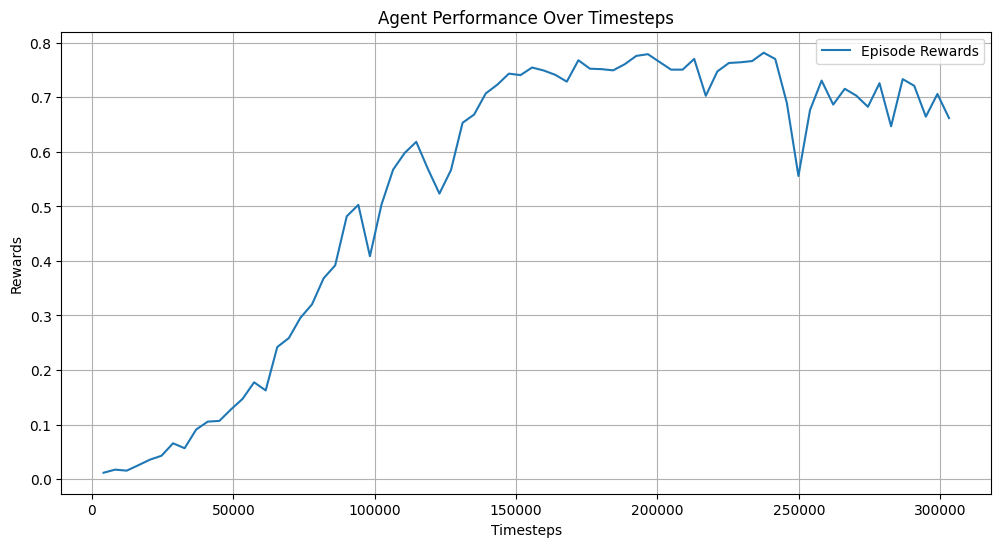

In [16]:
difficulty_order = ["medium"]#"medium"#, "hard"]
results, models = curriculum_experiment_no_transfer(difficulty_order, timesteps_per_difficulty=300_000)

In [ ]:
model = models[0][1]
env = create_environment('medium', render=False, monitor=False)
obs, _ = env.reset()
try:
    for i in range(1_000):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, _, info = env.step(action)
        # total_reward += reward
        ret = env.render(mode="topdown",
                         screen_record=True,
                         window=False,
                         screen_size=(900, 900),
                         camera_position=(50, 30))
        if done:
            # print("episode_reward", total_reward)
            break

    env.top_down_renderer.generate_gif()
finally:
    env.close()
# prompt: load demo.gif and display it

from IPython.display import Image

Image(filename='demo.gif')

# On Hard Mode Non Transfer

In [8]:
difficulty_order = ["hard"]#"medium"#, "hard"]

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


Training on hard difficulty (No Transfer)...
Using cuda device
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 211  |
|    iterations      | 1    |
|    time_elapsed    | 19   |
|    total_timesteps | 4096 |
-----------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.72e+03    |
|    ep_rew_mean          | 39.1        |
| time/                   |             |
|    fps                  | 183         |
|    iterations           | 2           |
|    time_elapsed         | 44          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.018315848 |
|    clip_fraction        | 0.248       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.79       |
|    explained_variance   | 0.0419      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0267     |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0283     |
|    std                  | 0.966       |
|    value_loss           | 0.0117      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.64e+03    |
|    ep_rew_mean          | 26.3        |
| time/                   |             |
|    fps                  | 130         |
|    iterations           | 3           |
|    time_elapsed         | 94          |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.011609415 |
|    clip_fraction        | 0.182       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.76       |
|    explained_variance   | -0.0195     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.183       |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.00874    |
|    std                  | 0.96        |
|    value_loss           | 0.196       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.26e+03   |
|    ep_rew_mean          | 23.2       |
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 4          |
|    time_elapsed         | 147        |
|    total_timesteps      | 16384      |
| train/                  |            |
|    approx_kl            | 0.01273953 |
|    clip_fraction        | 0.202      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.74      |
|    explained_variance   | -0.00965   |
|    learning_rate        | 0.0003     |
|    loss                 | 0.285      |
|    n_updates            | 30         |
|    policy_gradient_loss | -0.0102    |
|    std                  | 0.944      |
|    value_loss           | 0.317      |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 957         |
|    ep_rew_mean          | 19.8        |
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 5           |
|    time_elapsed         | 216         |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.016143542 |
|    clip_fraction        | 0.189       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.71       |
|    explained_variance   | 0.0297      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.183       |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.0104     |
|    std                  | 0.935       |
|    value_loss           | 0.47        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 633         |
|    ep_rew_mean          | 15          |
| time/                   |             |
|    fps                  | 83          |
|    iterations           | 6           |
|    time_elapsed         | 293         |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.010370689 |
|    clip_fraction        | 0.141       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.67       |
|    explained_variance   | 0.185       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.262       |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.00866    |
|    std                  | 0.914       |
|    value_loss           | 0.685       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 499         |
|    ep_rew_mean          | 13.2        |
| time/                   |             |
|    fps                  | 75          |
|    iterations           | 7           |
|    time_elapsed         | 377         |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.007869551 |
|    clip_fraction        | 0.0965      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.64       |
|    explained_variance   | 0.176       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.633       |
|    n_updates            | 60          |
|    policy_gradient_loss | -0.004      |
|    std                  | 0.904       |
|    value_loss           | 1.49        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 412          |
|    ep_rew_mean          | 12.5         |
| time/                   |              |
|    fps                  | 70           |
|    iterations           | 8            |
|    time_elapsed         | 466          |
|    total_timesteps      | 32768        |
| train/                  |              |
|    approx_kl            | 0.0055234893 |
|    clip_fraction        | 0.0864       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.61        |
|    explained_variance   | 0.355        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.284        |
|    n_updates            | 70           |
|    policy_gradient_loss | -0.00504     |
|    std                  | 0.887        |
|    value_loss           | 1.48         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 277          |
|    ep_rew_mean          | 10.9         |
| time/                   |              |
|    fps                  | 66           |
|    iterations           | 9            |
|    time_elapsed         | 551          |
|    total_timesteps      | 36864        |
| train/                  |              |
|    approx_kl            | 0.0073201545 |
|    clip_fraction        | 0.0976       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.58        |
|    explained_variance   | 0.419        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.08         |
|    n_updates            | 80           |
|    policy_gradient_loss | -0.00396     |
|    std                  | 0.879        |
|    value_loss           | 1.95         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 208         |
|    ep_rew_mean          | 11.9        |
| time/                   |             |
|    fps                  | 64          |
|    iterations           | 10          |
|    time_elapsed         | 633         |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.004565303 |
|    clip_fraction        | 0.0772      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.56       |
|    explained_variance   | 0.228       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.79        |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.00356    |
|    std                  | 0.87        |
|    value_loss           | 2.9         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 198         |
|    ep_rew_mean          | 13.9        |
| time/                   |             |
|    fps                  | 61          |
|    iterations           | 11          |
|    time_elapsed         | 729         |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.007267322 |
|    clip_fraction        | 0.111       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.53       |
|    explained_variance   | 0.504       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.257       |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.00459    |
|    std                  | 0.853       |
|    value_loss           | 1.92        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 195          |
|    ep_rew_mean          | 16.5         |
| time/                   |              |
|    fps                  | 59           |
|    iterations           | 12           |
|    time_elapsed         | 822          |
|    total_timesteps      | 49152        |
| train/                  |              |
|    approx_kl            | 0.0052680187 |
|    clip_fraction        | 0.139        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.51        |
|    explained_variance   | 0.564        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.96         |
|    n_updates            | 110          |
|    policy_gradient_loss | -0.00363     |
|    std                  | 0.845        |
|    value_loss           | 2.79         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 155         |
|    ep_rew_mean          | 15.1        |
| time/                   |             |
|    fps                  | 57          |
|    iterations           | 13          |
|    time_elapsed         | 918         |
|    total_timesteps      | 53248       |
| train/                  |             |
|    approx_kl            | 0.011626381 |
|    clip_fraction        | 0.143       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.48       |
|    explained_variance   | 0.34        |
|    learning_rate        | 0.0003      |
|    loss                 | 1.3         |
|    n_updates            | 120         |
|    policy_gradient_loss | -0.00497    |
|    std                  | 0.831       |
|    value_loss           | 3.68        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 123         |
|    ep_rew_mean          | 13.7        |
| time/                   |             |
|    fps                  | 56          |
|    iterations           | 14          |
|    time_elapsed         | 1017        |
|    total_timesteps      | 57344       |
| train/                  |             |
|    approx_kl            | 0.013047557 |
|    clip_fraction        | 0.181       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.45       |
|    explained_variance   | 0.734       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.7         |
|    n_updates            | 130         |
|    policy_gradient_loss | -0.012      |
|    std                  | 0.822       |
|    value_loss           | 2.81        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 116         |
|    ep_rew_mean          | 15.1        |
| time/                   |             |
|    fps                  | 54          |
|    iterations           | 15          |
|    time_elapsed         | 1119        |
|    total_timesteps      | 61440       |
| train/                  |             |
|    approx_kl            | 0.010620439 |
|    clip_fraction        | 0.159       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.41       |
|    explained_variance   | 0.688       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.98        |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.0107     |
|    std                  | 0.802       |
|    value_loss           | 4.02        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 148         |
|    ep_rew_mean          | 23          |
| time/                   |             |
|    fps                  | 54          |
|    iterations           | 16          |
|    time_elapsed         | 1197        |
|    total_timesteps      | 65536       |
| train/                  |             |
|    approx_kl            | 0.006576111 |
|    clip_fraction        | 0.0961      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.38       |
|    explained_variance   | 0.343       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.7         |
|    n_updates            | 150         |
|    policy_gradient_loss | -0.00331    |
|    std                  | 0.79        |
|    value_loss           | 6.99        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 164        |
|    ep_rew_mean          | 29.6       |
| time/                   |            |
|    fps                  | 53         |
|    iterations           | 17         |
|    time_elapsed         | 1299       |
|    total_timesteps      | 69632      |
| train/                  |            |
|    approx_kl            | 0.00960225 |
|    clip_fraction        | 0.137      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.33      |
|    explained_variance   | 0.36       |
|    learning_rate        | 0.0003     |
|    loss                 | 2.42       |
|    n_updates            | 160        |
|    policy_gradient_loss | 0.00188    |
|    std                  | 0.77       |
|    value_loss           | 6.28       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 171         |
|    ep_rew_mean          | 34.4        |
| time/                   |             |
|    fps                  | 52          |
|    iterations           | 18          |
|    time_elapsed         | 1401        |
|    total_timesteps      | 73728       |
| train/                  |             |
|    approx_kl            | 0.008023556 |
|    clip_fraction        | 0.143       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.29       |
|    explained_variance   | 0.361       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.29        |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.00438    |
|    std                  | 0.754       |
|    value_loss           | 10.1        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 195        |
|    ep_rew_mean          | 44.4       |
| time/                   |            |
|    fps                  | 52         |
|    iterations           | 19         |
|    time_elapsed         | 1486       |
|    total_timesteps      | 77824      |
| train/                  |            |
|    approx_kl            | 0.01069008 |
|    clip_fraction        | 0.15       |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.25      |
|    explained_variance   | 0.273      |
|    learning_rate        | 0.0003     |
|    loss                 | 7.54       |
|    n_updates            | 180        |
|    policy_gradient_loss | -0.00762   |
|    std                  | 0.742      |
|    value_loss           | 12.5       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INF

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 196         |
|    ep_rew_mean          | 50.8        |
| time/                   |             |
|    fps                  | 51          |
|    iterations           | 20          |
|    time_elapsed         | 1599        |
|    total_timesteps      | 81920       |
| train/                  |             |
|    approx_kl            | 0.014778899 |
|    clip_fraction        | 0.158       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.21       |
|    explained_variance   | 0.201       |
|    learning_rate        | 0.0003      |
|    loss                 | 7.48        |
|    n_updates            | 190         |
|    policy_gradient_loss | -0.000976   |
|    std                  | 0.725       |
|    value_loss           | 11.9        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[I

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 186         |
|    ep_rew_mean          | 55          |
| time/                   |             |
|    fps                  | 50          |
|    iterations           | 21          |
|    time_elapsed         | 1716        |
|    total_timesteps      | 86016       |
| train/                  |             |
|    approx_kl            | 0.016245604 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.16       |
|    explained_variance   | 0.547       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.73        |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.00249    |
|    std                  | 0.707       |
|    value_loss           | 8.79        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[I

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 195         |
|    ep_rew_mean          | 63          |
| time/                   |             |
|    fps                  | 48          |
|    iterations           | 22          |
|    time_elapsed         | 1840        |
|    total_timesteps      | 90112       |
| train/                  |             |
|    approx_kl            | 0.007232776 |
|    clip_fraction        | 0.146       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.13       |
|    explained_variance   | 0.621       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.48        |
|    n_updates            | 210         |
|    policy_gradient_loss | -0.0015     |
|    std                  | 0.702       |
|    value_loss           | 11.6        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episo

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 177         |
|    ep_rew_mean          | 63.5        |
| time/                   |             |
|    fps                  | 48          |
|    iterations           | 23          |
|    time_elapsed         | 1955        |
|    total_timesteps      | 94208       |
| train/                  |             |
|    approx_kl            | 0.018619943 |
|    clip_fraction        | 0.195       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.1        |
|    explained_variance   | 0.646       |
|    learning_rate        | 0.0003      |
|    loss                 | 7.02        |
|    n_updates            | 220         |
|    policy_gradient_loss | -0.000273   |
|    std                  | 0.686       |
|    value_loss           | 14.4        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Epi

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 163         |
|    ep_rew_mean          | 62.3        |
| time/                   |             |
|    fps                  | 47          |
|    iterations           | 24          |
|    time_elapsed         | 2068        |
|    total_timesteps      | 98304       |
| train/                  |             |
|    approx_kl            | 0.020269647 |
|    clip_fraction        | 0.204       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.07       |
|    explained_variance   | 0.559       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.64        |
|    n_updates            | 230         |
|    policy_gradient_loss | -0.00469    |
|    std                  | 0.678       |
|    value_loss           | 22.3        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] E

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 146         |
|    ep_rew_mean          | 57.4        |
| time/                   |             |
|    fps                  | 46          |
|    iterations           | 25          |
|    time_elapsed         | 2183        |
|    total_timesteps      | 102400      |
| train/                  |             |
|    approx_kl            | 0.017915282 |
|    clip_fraction        | 0.183       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.04       |
|    explained_variance   | 0.649       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.8        |
|    n_updates            | 240         |
|    policy_gradient_loss | -0.00136    |
|    std                  | 0.665       |
|    value_loss           | 21.3        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episo

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 142         |
|    ep_rew_mean          | 59.5        |
| time/                   |             |
|    fps                  | 46          |
|    iterations           | 26          |
|    time_elapsed         | 2296        |
|    total_timesteps      | 106496      |
| train/                  |             |
|    approx_kl            | 0.011647269 |
|    clip_fraction        | 0.176       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.01       |
|    explained_variance   | 0.583       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.67        |
|    n_updates            | 250         |
|    policy_gradient_loss | -0.00934    |
|    std                  | 0.658       |
|    value_loss           | 26.6        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 142         |
|    ep_rew_mean          | 62          |
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 27          |
|    time_elapsed         | 2414        |
|    total_timesteps      | 110592      |
| train/                  |             |
|    approx_kl            | 0.020886635 |
|    clip_fraction        | 0.191       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.98       |
|    explained_variance   | 0.536       |
|    learning_rate        | 0.0003      |
|    loss                 | 13.3        |
|    n_updates            | 260         |
|    policy_gradient_loss | -0.0063     |
|    std                  | 0.649       |
|    value_loss           | 27.8        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehic

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 145         |
|    ep_rew_mean          | 66.7        |
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 28          |
|    time_elapsed         | 2538        |
|    total_timesteps      | 114688      |
| train/                  |             |
|    approx_kl            | 0.017082322 |
|    clip_fraction        | 0.213       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.95       |
|    explained_variance   | 0.65        |
|    learning_rate        | 0.0003      |
|    loss                 | 11.2        |
|    n_updates            | 270         |
|    policy_gradient_loss | 0.00409     |
|    std                  | 0.635       |
|    value_loss           | 20          |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INF

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 147         |
|    ep_rew_mean          | 70.8        |
| time/                   |             |
|    fps                  | 44          |
|    iterations           | 29          |
|    time_elapsed         | 2659        |
|    total_timesteps      | 118784      |
| train/                  |             |
|    approx_kl            | 0.025052233 |
|    clip_fraction        | 0.217       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.91       |
|    explained_variance   | 0.866       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.37        |
|    n_updates            | 280         |
|    policy_gradient_loss | 0.0024      |
|    std                  | 0.628       |
|    value_loss           | 9.29        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash veh

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 143         |
|    ep_rew_mean          | 71.8        |
| time/                   |             |
|    fps                  | 44          |
|    iterations           | 30          |
|    time_elapsed         | 2784        |
|    total_timesteps      | 122880      |
| train/                  |             |
|    approx_kl            | 0.010386584 |
|    clip_fraction        | 0.145       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.89       |
|    explained_variance   | 0.741       |
|    learning_rate        | 0.0003      |
|    loss                 | 5.3         |
|    n_updates            | 290         |
|    policy_gradient_loss | -0.00162    |
|    std                  | 0.621       |
|    value_loss           | 21.9        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INF

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 135        |
|    ep_rew_mean          | 69.5       |
| time/                   |            |
|    fps                  | 43         |
|    iterations           | 31         |
|    time_elapsed         | 2909       |
|    total_timesteps      | 126976     |
| train/                  |            |
|    approx_kl            | 0.01853864 |
|    clip_fraction        | 0.221      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.85      |
|    explained_variance   | 0.938      |
|    learning_rate        | 0.0003     |
|    loss                 | 2.79       |
|    n_updates            | 300        |
|    policy_gradient_loss | 0.000827   |
|    std                  | 0.606      |
|    value_loss           | 6.14       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehic

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 132         |
|    ep_rew_mean          | 71          |
| time/                   |             |
|    fps                  | 43          |
|    iterations           | 32          |
|    time_elapsed         | 3033        |
|    total_timesteps      | 131072      |
| train/                  |             |
|    approx_kl            | 0.011839251 |
|    clip_fraction        | 0.18        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.82       |
|    explained_variance   | 0.819       |
|    learning_rate        | 0.0003      |
|    loss                 | 16.5        |
|    n_updates            | 310         |
|    policy_gradient_loss | -0.000613   |
|    std                  | 0.603       |
|    value_loss           | 23.6        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehic

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 122         |
|    ep_rew_mean          | 67.1        |
| time/                   |             |
|    fps                  | 42          |
|    iterations           | 33          |
|    time_elapsed         | 3157        |
|    total_timesteps      | 135168      |
| train/                  |             |
|    approx_kl            | 0.017964931 |
|    clip_fraction        | 0.205       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.77       |
|    explained_variance   | 0.939       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.59        |
|    n_updates            | 320         |
|    policy_gradient_loss | 0.00203     |
|    std                  | 0.581       |
|    value_loss           | 7.65        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 119        |
|    ep_rew_mean          | 66.3       |
| time/                   |            |
|    fps                  | 42         |
|    iterations           | 34         |
|    time_elapsed         | 3279       |
|    total_timesteps      | 139264     |
| train/                  |            |
|    approx_kl            | 0.03979011 |
|    clip_fraction        | 0.238      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.73      |
|    explained_variance   | 0.822      |
|    learning_rate        | 0.0003     |
|    loss                 | 15.1       |
|    n_updates            | 330        |
|    policy_gradient_loss | 0.00222    |
|    std                  | 0.579      |
|    value_loss           | 23.9       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] E

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 105         |
|    ep_rew_mean          | 55.9        |
| time/                   |             |
|    fps                  | 42          |
|    iterations           | 35          |
|    time_elapsed         | 3400        |
|    total_timesteps      | 143360      |
| train/                  |             |
|    approx_kl            | 0.017007269 |
|    clip_fraction        | 0.258       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.71       |
|    explained_variance   | 0.84        |
|    learning_rate        | 0.0003      |
|    loss                 | 11.8        |
|    n_updates            | 340         |
|    policy_gradient_loss | 0.00748     |
|    std                  | 0.568       |
|    value_loss           | 24.8        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehic

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 104         |
|    ep_rew_mean          | 56.4        |
| time/                   |             |
|    fps                  | 41          |
|    iterations           | 36          |
|    time_elapsed         | 3529        |
|    total_timesteps      | 147456      |
| train/                  |             |
|    approx_kl            | 0.014678211 |
|    clip_fraction        | 0.234       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.69       |
|    explained_variance   | 0.623       |
|    learning_rate        | 0.0003      |
|    loss                 | 33.5        |
|    n_updates            | 350         |
|    policy_gradient_loss | -0.0103     |
|    std                  | 0.566       |
|    value_loss           | 50.8        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 104         |
|    ep_rew_mean          | 57.8        |
| time/                   |             |
|    fps                  | 41          |
|    iterations           | 37          |
|    time_elapsed         | 3662        |
|    total_timesteps      | 151552      |
| train/                  |             |
|    approx_kl            | 0.026922712 |
|    clip_fraction        | 0.317       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.67       |
|    explained_variance   | 0.826       |
|    learning_rate        | 0.0003      |
|    loss                 | 16.3        |
|    n_updates            | 360         |
|    policy_gradient_loss | 0.0172      |
|    std                  | 0.561       |
|    value_loss           | 24.4        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO]

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 103         |
|    ep_rew_mean          | 57.8        |
| time/                   |             |
|    fps                  | 41          |
|    iterations           | 38          |
|    time_elapsed         | 3787        |
|    total_timesteps      | 155648      |
| train/                  |             |
|    approx_kl            | 0.018508181 |
|    clip_fraction        | 0.215       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.64       |
|    explained_variance   | 0.754       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.48        |
|    n_updates            | 370         |
|    policy_gradient_loss | -0.00276    |
|    std                  | 0.551       |
|    value_loss           | 32.4        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 109         |
|    ep_rew_mean          | 62.8        |
| time/                   |             |
|    fps                  | 40          |
|    iterations           | 39          |
|    time_elapsed         | 3918        |
|    total_timesteps      | 159744      |
| train/                  |             |
|    approx_kl            | 0.020701412 |
|    clip_fraction        | 0.264       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.61       |
|    explained_variance   | 0.74        |
|    learning_rate        | 0.0003      |
|    loss                 | 34.8        |
|    n_updates            | 380         |
|    policy_gradient_loss | -0.00257    |
|    std                  | 0.547       |
|    value_loss           | 32.2        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash v

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 117         |
|    ep_rew_mean          | 70.6        |
| time/                   |             |
|    fps                  | 40          |
|    iterations           | 40          |
|    time_elapsed         | 4046        |
|    total_timesteps      | 163840      |
| train/                  |             |
|    approx_kl            | 0.019502565 |
|    clip_fraction        | 0.269       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.57       |
|    explained_variance   | 0.953       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.931       |
|    n_updates            | 390         |
|    policy_gradient_loss | 0.00638     |
|    std                  | 0.536       |
|    value_loss           | 2.09        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 99         |
|    ep_rew_mean          | 55.1       |
| time/                   |            |
|    fps                  | 40         |
|    iterations           | 41         |
|    time_elapsed         | 4166       |
|    total_timesteps      | 167936     |
| train/                  |            |
|    approx_kl            | 0.03426851 |
|    clip_fraction        | 0.216      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.53      |
|    explained_variance   | 0.943      |
|    learning_rate        | 0.0003     |
|    loss                 | 10.6       |
|    n_updates            | 400        |
|    policy_gradient_loss | 0.00212    |
|    std                  | 0.523      |
|    value_loss           | 8.22       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode end

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 86.7       |
|    ep_rew_mean          | 44.5       |
| time/                   |            |
|    fps                  | 40         |
|    iterations           | 42         |
|    time_elapsed         | 4290       |
|    total_timesteps      | 172032     |
| train/                  |            |
|    approx_kl            | 0.01656523 |
|    clip_fraction        | 0.17       |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.51      |
|    explained_variance   | 0.403      |
|    learning_rate        | 0.0003     |
|    loss                 | 29.6       |
|    n_updates            | 410        |
|    policy_gradient_loss | -0.0139    |
|    std                  | 0.523      |
|    value_loss           | 62.9       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episo

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 94.9        |
|    ep_rew_mean          | 52.2        |
| time/                   |             |
|    fps                  | 39          |
|    iterations           | 43          |
|    time_elapsed         | 4417        |
|    total_timesteps      | 176128      |
| train/                  |             |
|    approx_kl            | 0.013485659 |
|    clip_fraction        | 0.173       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.5        |
|    explained_variance   | 0.713       |
|    learning_rate        | 0.0003      |
|    loss                 | 20.7        |
|    n_updates            | 420         |
|    policy_gradient_loss | -0.00523    |
|    std                  | 0.521       |
|    value_loss           | 40.6        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[I

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 104         |
|    ep_rew_mean          | 62.3        |
| time/                   |             |
|    fps                  | 39          |
|    iterations           | 44          |
|    time_elapsed         | 4547        |
|    total_timesteps      | 180224      |
| train/                  |             |
|    approx_kl            | 0.013447372 |
|    clip_fraction        | 0.203       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.5        |
|    explained_variance   | 0.864       |
|    learning_rate        | 0.0003      |
|    loss                 | 9.44        |
|    n_updates            | 430         |
|    policy_gradient_loss | -0.00464    |
|    std                  | 0.521       |
|    value_loss           | 18.5        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash veh

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 112        |
|    ep_rew_mean          | 71.3       |
| time/                   |            |
|    fps                  | 39         |
|    iterations           | 45         |
|    time_elapsed         | 4678       |
|    total_timesteps      | 184320     |
| train/                  |            |
|    approx_kl            | 0.02676437 |
|    clip_fraction        | 0.232      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.45      |
|    explained_variance   | 0.953      |
|    learning_rate        | 0.0003     |
|    loss                 | 2.07       |
|    n_updates            | 440        |
|    policy_gradient_loss | 0.000544   |
|    std                  | 0.504      |
|    value_loss           | 3.74       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash veh

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 114        |
|    ep_rew_mean          | 75.3       |
| time/                   |            |
|    fps                  | 39         |
|    iterations           | 46         |
|    time_elapsed         | 4810       |
|    total_timesteps      | 188416     |
| train/                  |            |
|    approx_kl            | 0.02185351 |
|    clip_fraction        | 0.22       |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.39      |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.627      |
|    n_updates            | 450        |
|    policy_gradient_loss | 0.0019     |
|    std                  | 0.494      |
|    value_loss           | 1.41       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash v

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 110         |
|    ep_rew_mean          | 74.8        |
| time/                   |             |
|    fps                  | 38          |
|    iterations           | 47          |
|    time_elapsed         | 4943        |
|    total_timesteps      | 192512      |
| train/                  |             |
|    approx_kl            | 0.021089876 |
|    clip_fraction        | 0.204       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.35       |
|    explained_variance   | 0.991       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.346       |
|    n_updates            | 460         |
|    policy_gradient_loss | -0.0055     |
|    std                  | 0.485       |
|    value_loss           | 1.09        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash veh

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 108         |
|    ep_rew_mean          | 74.8        |
| time/                   |             |
|    fps                  | 38          |
|    iterations           | 48          |
|    time_elapsed         | 5073        |
|    total_timesteps      | 196608      |
| train/                  |             |
|    approx_kl            | 0.016083032 |
|    clip_fraction        | 0.193       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.32       |
|    explained_variance   | 0.986       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.672       |
|    n_updates            | 470         |
|    policy_gradient_loss | 0.00317     |
|    std                  | 0.481       |
|    value_loss           | 1.84        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehic

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 105         |
|    ep_rew_mean          | 74.5        |
| time/                   |             |
|    fps                  | 38          |
|    iterations           | 49          |
|    time_elapsed         | 5207        |
|    total_timesteps      | 200704      |
| train/                  |             |
|    approx_kl            | 0.013489877 |
|    clip_fraction        | 0.196       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.3        |
|    explained_variance   | 0.988       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.571       |
|    n_updates            | 480         |
|    policy_gradient_loss | 0.000232    |
|    std                  | 0.474       |
|    value_loss           | 1.76        |
-----------------------------------------
Performance for hard difficulty:


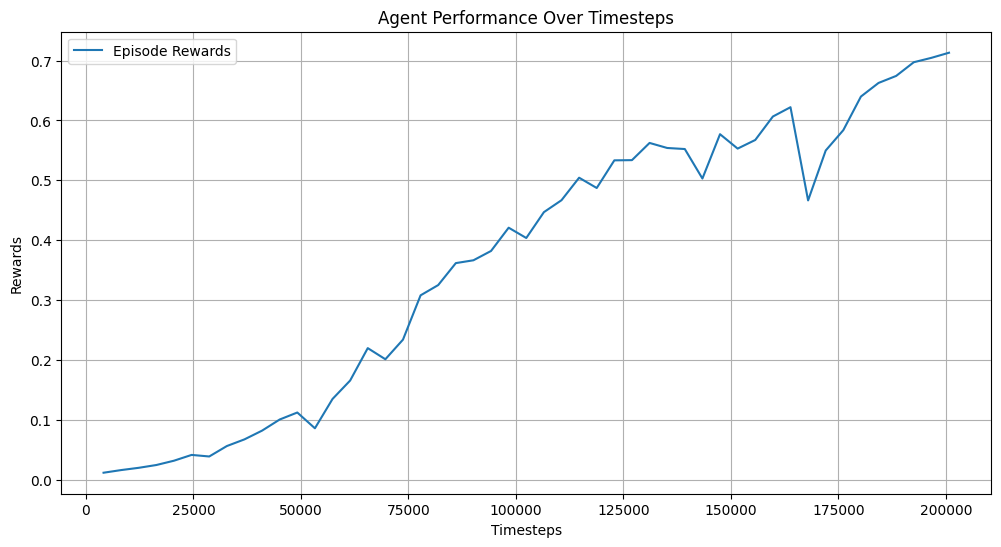

In [ ]:
results, models = curriculum_experiment_no_transfer(difficulty_order, timesteps_per_difficulty=200_000)

In [ ]:
models

[('hard', <stable_baselines3.ppo.ppo.PPO at 0x7b5369b36e60>)]

In [ ]:
model = models[0][1]

# evaluate on hard

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 


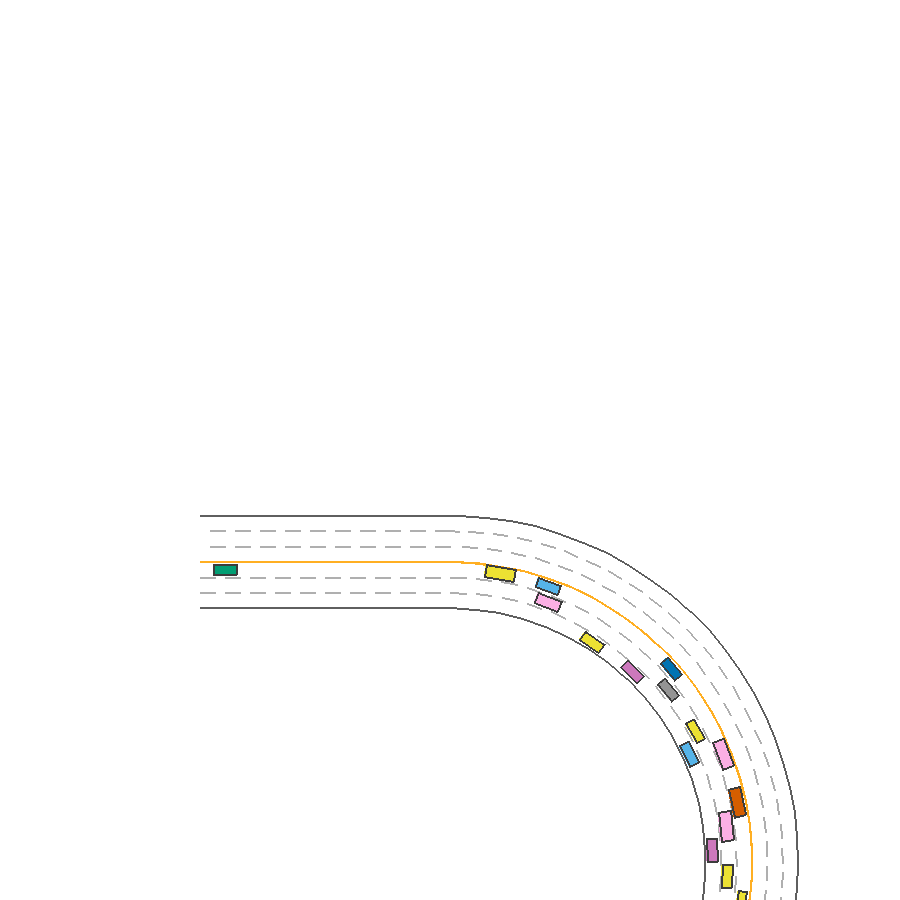

In [ ]:
env = create_environment('hard', render=False, monitor=False)
obs, _ = env.reset()
try:
    for i in range(1_000):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, _, info = env.step(action)
        # total_reward += reward
        ret = env.render(mode="topdown",
                         screen_record=True,
                         window=False,
                         screen_size=(900, 900),
                         camera_position=(50, 30))
        if done:
            # print("episode_reward", total_reward)
            break

    env.top_down_renderer.generate_gif()
finally:
    env.close()
# prompt: load demo.gif and display it

from IPython.display import Image

Image(filename='demo.gif')

# Hard 300,000 Non Transfer Learning

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE

Training on hard difficulty (No Transfer)...
Using cuda device
Wrapping the env in a DummyVecEnv.


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 727      |
|    ep_rew_mean     | 3.95     |
| time/              |          |
|    fps             | 113      |
|    iterations      | 1        |
|    time_elapsed    | 35       |
|    total_timesteps | 4096     |
---------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 925         |
|    ep_rew_mean          | 7.28        |
| time/                   |             |
|    fps                  | 115         |
|    iterations           | 2           |
|    time_elapsed         | 70          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.007846244 |
|    clip_fraction        | 0.0812      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.82       |
|    explained_variance   | -0.00091    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.243       |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00236    |
|    std                  | 0.986       |
|    value_loss           | 0.289       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.39e+03    |
|    ep_rew_mean          | 18.1        |
| time/                   |             |
|    fps                  | 123         |
|    iterations           | 3           |
|    time_elapsed         | 99          |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.015108118 |
|    clip_fraction        | 0.235       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.8        |
|    explained_variance   | 0.0156      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0344      |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0208     |
|    std                  | 0.973       |
|    value_loss           | 0.0757      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.08e+03    |
|    ep_rew_mean          | 17.4        |
| time/                   |             |
|    fps                  | 115         |
|    iterations           | 4           |
|    time_elapsed         | 141         |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.018866956 |
|    clip_fraction        | 0.243       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.75       |
|    explained_variance   | 0.0208      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0274     |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.018      |
|    std                  | 0.947       |
|    value_loss           | 0.167       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 833         |
|    ep_rew_mean          | 17.4        |
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 5           |
|    time_elapsed         | 199         |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.012649603 |
|    clip_fraction        | 0.163       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.71       |
|    explained_variance   | -0.00463    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.325       |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.00864    |
|    std                  | 0.931       |
|    value_loss           | 0.499       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 651         |
|    ep_rew_mean          | 15.7        |
| time/                   |             |
|    fps                  | 89          |
|    iterations           | 6           |
|    time_elapsed         | 274         |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.012446615 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.67       |
|    explained_variance   | 0.008       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.453       |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.00725    |
|    std                  | 0.916       |
|    value_loss           | 0.97        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 492         |
|    ep_rew_mean          | 14          |
| time/                   |             |
|    fps                  | 79          |
|    iterations           | 7           |
|    time_elapsed         | 360         |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.008635949 |
|    clip_fraction        | 0.0673      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.64       |
|    explained_variance   | 0.033       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.305       |
|    n_updates            | 60          |
|    policy_gradient_loss | -0.00168    |
|    std                  | 0.9         |
|    value_loss           | 1.27        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 433          |
|    ep_rew_mean          | 15.2         |
| time/                   |              |
|    fps                  | 70           |
|    iterations           | 8            |
|    time_elapsed         | 463          |
|    total_timesteps      | 32768        |
| train/                  |              |
|    approx_kl            | 0.0068447767 |
|    clip_fraction        | 0.0653       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.61        |
|    explained_variance   | 0.147        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.605        |
|    n_updates            | 70           |
|    policy_gradient_loss | -0.0032      |
|    std                  | 0.891        |
|    value_loss           | 2.01         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 376         |
|    ep_rew_mean          | 15.5        |
| time/                   |             |
|    fps                  | 65          |
|    iterations           | 9           |
|    time_elapsed         | 563         |
|    total_timesteps      | 36864       |
| train/                  |             |
|    approx_kl            | 0.007249143 |
|    clip_fraction        | 0.0999      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.59       |
|    explained_variance   | 0.294       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.58        |
|    n_updates            | 80          |
|    policy_gradient_loss | -0.00584    |
|    std                  | 0.879       |
|    value_loss           | 2.28        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 201         |
|    ep_rew_mean          | 14.8        |
| time/                   |             |
|    fps                  | 61          |
|    iterations           | 10          |
|    time_elapsed         | 665         |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.009366965 |
|    clip_fraction        | 0.143       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.57       |
|    explained_variance   | 0.427       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.821       |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.00615    |
|    std                  | 0.872       |
|    value_loss           | 1.96        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 154      |
|    ep_rew_mean          | 14.2     |
| time/                   |          |
|    fps                  | 58       |
|    iterations           | 11       |
|    time_elapsed         | 775      |
|    total_timesteps      | 45056    |
| train/                  |          |
|    approx_kl            | 0.008738 |
|    clip_fraction        | 0.117    |
|    clip_range           | 0.2      |
|    entropy_loss         | -2.55    |
|    explained_variance   | 0.398    |
|    learning_rate        | 0.0003   |
|    loss                 | 1.75     |
|    n_updates            | 100      |
|    policy_gradient_loss | -0.00218 |
|    std                  | 0.86     |
|    value_loss           | 3.76     |
--------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 106       |
|    ep_rew_mean          | 9.32      |
| time/                   |           |
|    fps                  | 56        |
|    iterations           | 12        |
|    time_elapsed         | 872       |
|    total_timesteps      | 49152     |
| train/                  |           |
|    approx_kl            | 0.0166637 |
|    clip_fraction        | 0.13      |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.53     |
|    explained_variance   | 0.279     |
|    learning_rate        | 0.0003    |
|    loss                 | 2.01      |
|    n_updates            | 110       |
|    policy_gradient_loss | -0.00169  |
|    std                  | 0.858     |
|    value_loss           | 4.34      |
---------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 101         |
|    ep_rew_mean          | 9.06        |
| time/                   |             |
|    fps                  | 54          |
|    iterations           | 13          |
|    time_elapsed         | 978         |
|    total_timesteps      | 53248       |
| train/                  |             |
|    approx_kl            | 0.010993396 |
|    clip_fraction        | 0.203       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.53       |
|    explained_variance   | 0.543       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.78        |
|    n_updates            | 120         |
|    policy_gradient_loss | -0.0156     |
|    std                  | 0.856       |
|    value_loss           | 4.5         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 119         |
|    ep_rew_mean          | 12.5        |
| time/                   |             |
|    fps                  | 53          |
|    iterations           | 14          |
|    time_elapsed         | 1081        |
|    total_timesteps      | 57344       |
| train/                  |             |
|    approx_kl            | 0.013163217 |
|    clip_fraction        | 0.194       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.51       |
|    explained_variance   | 0.713       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.76        |
|    n_updates            | 130         |
|    policy_gradient_loss | -0.0133     |
|    std                  | 0.848       |
|    value_loss           | 3.58        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 140        |
|    ep_rew_mean          | 17.1       |
| time/                   |            |
|    fps                  | 51         |
|    iterations           | 15         |
|    time_elapsed         | 1184       |
|    total_timesteps      | 61440      |
| train/                  |            |
|    approx_kl            | 0.01026137 |
|    clip_fraction        | 0.0971     |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.49      |
|    explained_variance   | 0.353      |
|    learning_rate        | 0.0003     |
|    loss                 | 1.61       |
|    n_updates            | 140        |
|    policy_gradient_loss | -0.00033   |
|    std                  | 0.837      |
|    value_loss           | 3.75       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 151         |
|    ep_rew_mean          | 21.1        |
| time/                   |             |
|    fps                  | 50          |
|    iterations           | 16          |
|    time_elapsed         | 1289        |
|    total_timesteps      | 65536       |
| train/                  |             |
|    approx_kl            | 0.009914455 |
|    clip_fraction        | 0.142       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.46       |
|    explained_variance   | 0.609       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.55        |
|    n_updates            | 150         |
|    policy_gradient_loss | -0.00807    |
|    std                  | 0.825       |
|    value_loss           | 4.89        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 154          |
|    ep_rew_mean          | 24           |
| time/                   |              |
|    fps                  | 49           |
|    iterations           | 17           |
|    time_elapsed         | 1393         |
|    total_timesteps      | 69632        |
| train/                  |              |
|    approx_kl            | 0.0115864035 |
|    clip_fraction        | 0.166        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.43        |
|    explained_variance   | 0.524        |
|    learning_rate        | 0.0003       |
|    loss                 | 2.36         |
|    n_updates            | 160          |
|    policy_gradient_loss | -0.0106      |
|    std                  | 0.814        |
|    value_loss           | 6.7          |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 155         |
|    ep_rew_mean          | 26.8        |
| time/                   |             |
|    fps                  | 49          |
|    iterations           | 18          |
|    time_elapsed         | 1498        |
|    total_timesteps      | 73728       |
| train/                  |             |
|    approx_kl            | 0.009482406 |
|    clip_fraction        | 0.11        |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.4        |
|    explained_variance   | 0.596       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.29        |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.00428    |
|    std                  | 0.799       |
|    value_loss           | 6.17        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 173         |
|    ep_rew_mean          | 34.5        |
| time/                   |             |
|    fps                  | 48          |
|    iterations           | 19          |
|    time_elapsed         | 1589        |
|    total_timesteps      | 77824       |
| train/                  |             |
|    approx_kl            | 0.013490561 |
|    clip_fraction        | 0.146       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.37       |
|    explained_variance   | 0.595       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.76        |
|    n_updates            | 180         |
|    policy_gradient_loss | -0.00134    |
|    std                  | 0.784       |
|    value_loss           | 6.96        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 192         |
|    ep_rew_mean          | 42.7        |
| time/                   |             |
|    fps                  | 48          |
|    iterations           | 20          |
|    time_elapsed         | 1683        |
|    total_timesteps      | 81920       |
| train/                  |             |
|    approx_kl            | 0.019612625 |
|    clip_fraction        | 0.194       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.32       |
|    explained_variance   | 0.565       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.63        |
|    n_updates            | 190         |
|    policy_gradient_loss | -0.00555    |
|    std                  | 0.76        |
|    value_loss           | 6.55        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode e

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 212         |
|    ep_rew_mean          | 52.9        |
| time/                   |             |
|    fps                  | 48          |
|    iterations           | 21          |
|    time_elapsed         | 1781        |
|    total_timesteps      | 86016       |
| train/                  |             |
|    approx_kl            | 0.007802388 |
|    clip_fraction        | 0.143       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.27       |
|    explained_variance   | 0.385       |
|    learning_rate        | 0.0003      |
|    loss                 | 5.5         |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.000505   |
|    std                  | 0.744       |
|    value_loss           | 7           |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 181         |
|    ep_rew_mean          | 49.4        |
| time/                   |             |
|    fps                  | 47          |
|    iterations           | 22          |
|    time_elapsed         | 1885        |
|    total_timesteps      | 90112       |
| train/                  |             |
|    approx_kl            | 0.020102918 |
|    clip_fraction        | 0.164       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.22       |
|    explained_variance   | 0.408       |
|    learning_rate        | 0.0003      |
|    loss                 | 7.21        |
|    n_updates            | 210         |
|    policy_gradient_loss | -0.000924   |
|    std                  | 0.726       |
|    value_loss           | 10.6        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] E

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 160        |
|    ep_rew_mean          | 48.2       |
| time/                   |            |
|    fps                  | 47         |
|    iterations           | 23         |
|    time_elapsed         | 1998       |
|    total_timesteps      | 94208      |
| train/                  |            |
|    approx_kl            | 0.01937949 |
|    clip_fraction        | 0.191      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.2       |
|    explained_variance   | 0.161      |
|    learning_rate        | 0.0003     |
|    loss                 | 8.16       |
|    n_updates            | 220        |
|    policy_gradient_loss | -0.00977   |
|    std                  | 0.727      |
|    value_loss           | 24.8       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] E

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 138       |
|    ep_rew_mean          | 45        |
| time/                   |           |
|    fps                  | 46        |
|    iterations           | 24        |
|    time_elapsed         | 2110      |
|    total_timesteps      | 98304     |
| train/                  |           |
|    approx_kl            | 0.0254395 |
|    clip_fraction        | 0.2       |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.17     |
|    explained_variance   | 0.665     |
|    learning_rate        | 0.0003    |
|    loss                 | 3.4       |
|    n_updates            | 230       |
|    policy_gradient_loss | -0.00133  |
|    std                  | 0.709     |
|    value_loss           | 8.5       |
---------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO]

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 148         |
|    ep_rew_mean          | 53.1        |
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 25          |
|    time_elapsed         | 2226        |
|    total_timesteps      | 102400      |
| train/                  |             |
|    approx_kl            | 0.017021358 |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.13       |
|    explained_variance   | 0.612       |
|    learning_rate        | 0.0003      |
|    loss                 | 11          |
|    n_updates            | 240         |
|    policy_gradient_loss | -0.000806   |
|    std                  | 0.699       |
|    value_loss           | 16.1        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash veh

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 165         |
|    ep_rew_mean          | 63.8        |
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 26          |
|    time_elapsed         | 2335        |
|    total_timesteps      | 106496      |
| train/                  |             |
|    approx_kl            | 0.012210941 |
|    clip_fraction        | 0.143       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.1        |
|    explained_variance   | 0.719       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.3        |
|    n_updates            | 250         |
|    policy_gradient_loss | -0.00444    |
|    std                  | 0.683       |
|    value_loss           | 16.1        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 173        |
|    ep_rew_mean          | 71.2       |
| time/                   |            |
|    fps                  | 44         |
|    iterations           | 27         |
|    time_elapsed         | 2457       |
|    total_timesteps      | 110592     |
| train/                  |            |
|    approx_kl            | 0.01843889 |
|    clip_fraction        | 0.186      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.05      |
|    explained_variance   | 0.808      |
|    learning_rate        | 0.0003     |
|    loss                 | 1.75       |
|    n_updates            | 260        |
|    policy_gradient_loss | -0.000211  |
|    std                  | 0.672      |
|    value_loss           | 7.99       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 165       |
|    ep_rew_mean          | 72.3      |
| time/                   |           |
|    fps                  | 44        |
|    iterations           | 28        |
|    time_elapsed         | 2576      |
|    total_timesteps      | 114688    |
| train/                  |           |
|    approx_kl            | 0.0092036 |
|    clip_fraction        | 0.152     |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.02     |
|    explained_variance   | 0.85      |
|    learning_rate        | 0.0003    |
|    loss                 | 4.22      |
|    n_updates            | 270       |
|    policy_gradient_loss | -0.00493  |
|    std                  | 0.663     |
|    value_loss           | 8.72      |
---------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 147         |
|    ep_rew_mean          | 64.3        |
| time/                   |             |
|    fps                  | 44          |
|    iterations           | 29          |
|    time_elapsed         | 2692        |
|    total_timesteps      | 118784      |
| train/                  |             |
|    approx_kl            | 0.025402907 |
|    clip_fraction        | 0.203       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.01       |
|    explained_variance   | 0.782       |
|    learning_rate        | 0.0003      |
|    loss                 | 15.4        |
|    n_updates            | 280         |
|    policy_gradient_loss | 0.00417     |
|    std                  | 0.661       |
|    value_loss           | 16.6        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INF

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 135        |
|    ep_rew_mean          | 60         |
| time/                   |            |
|    fps                  | 43         |
|    iterations           | 30         |
|    time_elapsed         | 2811       |
|    total_timesteps      | 122880     |
| train/                  |            |
|    approx_kl            | 0.02925474 |
|    clip_fraction        | 0.224      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2         |
|    explained_variance   | 0.463      |
|    learning_rate        | 0.0003     |
|    loss                 | 31.2       |
|    n_updates            | 290        |
|    policy_gradient_loss | -0.00515   |
|    std                  | 0.655      |
|    value_loss           | 44.6       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO]

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 127         |
|    ep_rew_mean          | 55.8        |
| time/                   |             |
|    fps                  | 43          |
|    iterations           | 31          |
|    time_elapsed         | 2931        |
|    total_timesteps      | 126976      |
| train/                  |             |
|    approx_kl            | 0.024302201 |
|    clip_fraction        | 0.195       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.96       |
|    explained_variance   | 0.747       |
|    learning_rate        | 0.0003      |
|    loss                 | 6.82        |
|    n_updates            | 300         |
|    policy_gradient_loss | -0.00022    |
|    std                  | 0.638       |
|    value_loss           | 16          |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episo

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 128        |
|    ep_rew_mean          | 58.5       |
| time/                   |            |
|    fps                  | 42         |
|    iterations           | 32         |
|    time_elapsed         | 3051       |
|    total_timesteps      | 131072     |
| train/                  |            |
|    approx_kl            | 0.01465369 |
|    clip_fraction        | 0.215      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.93      |
|    explained_variance   | 0.578      |
|    learning_rate        | 0.0003     |
|    loss                 | 12.3       |
|    n_updates            | 310        |
|    policy_gradient_loss | -0.00749   |
|    std                  | 0.635      |
|    value_loss           | 26.7       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehic

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 126         |
|    ep_rew_mean          | 59.7        |
| time/                   |             |
|    fps                  | 42          |
|    iterations           | 33          |
|    time_elapsed         | 3173        |
|    total_timesteps      | 135168      |
| train/                  |             |
|    approx_kl            | 0.015013197 |
|    clip_fraction        | 0.222       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.9        |
|    explained_variance   | 0.657       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.38        |
|    n_updates            | 320         |
|    policy_gradient_loss | -0.0048     |
|    std                  | 0.628       |
|    value_loss           | 36.6        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash v

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 129         |
|    ep_rew_mean          | 64.4        |
| time/                   |             |
|    fps                  | 42          |
|    iterations           | 34          |
|    time_elapsed         | 3299        |
|    total_timesteps      | 139264      |
| train/                  |             |
|    approx_kl            | 0.018087935 |
|    clip_fraction        | 0.3         |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.87       |
|    explained_variance   | 0.873       |
|    learning_rate        | 0.0003      |
|    loss                 | 7.64        |
|    n_updates            | 330         |
|    policy_gradient_loss | 0.0107      |
|    std                  | 0.613       |
|    value_loss           | 12.1        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[I

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 131         |
|    ep_rew_mean          | 67.8        |
| time/                   |             |
|    fps                  | 41          |
|    iterations           | 35          |
|    time_elapsed         | 3425        |
|    total_timesteps      | 143360      |
| train/                  |             |
|    approx_kl            | 0.023665294 |
|    clip_fraction        | 0.208       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.83       |
|    explained_variance   | 0.929       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.03        |
|    n_updates            | 340         |
|    policy_gradient_loss | 0.0028      |
|    std                  | 0.604       |
|    value_loss           | 5.08        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 130         |
|    ep_rew_mean          | 69.9        |
| time/                   |             |
|    fps                  | 41          |
|    iterations           | 36          |
|    time_elapsed         | 3552        |
|    total_timesteps      | 147456      |
| train/                  |             |
|    approx_kl            | 0.015170204 |
|    clip_fraction        | 0.199       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.81       |
|    explained_variance   | 0.82        |
|    learning_rate        | 0.0003      |
|    loss                 | 6.11        |
|    n_updates            | 350         |
|    policy_gradient_loss | -0.00278    |
|    std                  | 0.601       |
|    value_loss           | 24.4        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 130         |
|    ep_rew_mean          | 70.9        |
| time/                   |             |
|    fps                  | 41          |
|    iterations           | 37          |
|    time_elapsed         | 3680        |
|    total_timesteps      | 151552      |
| train/                  |             |
|    approx_kl            | 0.011795211 |
|    clip_fraction        | 0.193       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.79       |
|    explained_variance   | 0.907       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.82        |
|    n_updates            | 360         |
|    policy_gradient_loss | 0.00129     |
|    std                  | 0.596       |
|    value_loss           | 13.4        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 132         |
|    ep_rew_mean          | 73.6        |
| time/                   |             |
|    fps                  | 40          |
|    iterations           | 38          |
|    time_elapsed         | 3818        |
|    total_timesteps      | 155648      |
| train/                  |             |
|    approx_kl            | 0.018193642 |
|    clip_fraction        | 0.247       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.74       |
|    explained_variance   | 0.962       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.48        |
|    n_updates            | 370         |
|    policy_gradient_loss | 0.0016      |
|    std                  | 0.58        |
|    value_loss           | 4.77        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INF

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 136         |
|    ep_rew_mean          | 78          |
| time/                   |             |
|    fps                  | 40          |
|    iterations           | 39          |
|    time_elapsed         | 3943        |
|    total_timesteps      | 159744      |
| train/                  |             |
|    approx_kl            | 0.019840183 |
|    clip_fraction        | 0.207       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.7        |
|    explained_variance   | 0.927       |
|    learning_rate        | 0.0003      |
|    loss                 | 5.65        |
|    n_updates            | 380         |
|    policy_gradient_loss | -0.00184    |
|    std                  | 0.57        |
|    value_loss           | 10.2        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Epi

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 136         |
|    ep_rew_mean          | 79.8        |
| time/                   |             |
|    fps                  | 40          |
|    iterations           | 40          |
|    time_elapsed         | 4071        |
|    total_timesteps      | 163840      |
| train/                  |             |
|    approx_kl            | 0.012433456 |
|    clip_fraction        | 0.215       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.66       |
|    explained_variance   | 0.924       |
|    learning_rate        | 0.0003      |
|    loss                 | 5.26        |
|    n_updates            | 390         |
|    policy_gradient_loss | 0.00171     |
|    std                  | 0.559       |
|    value_loss           | 10.5        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash veh

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 137         |
|    ep_rew_mean          | 81.2        |
| time/                   |             |
|    fps                  | 39          |
|    iterations           | 41          |
|    time_elapsed         | 4198        |
|    total_timesteps      | 167936      |
| train/                  |             |
|    approx_kl            | 0.016077926 |
|    clip_fraction        | 0.254       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.64       |
|    explained_variance   | 0.917       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.82        |
|    n_updates            | 400         |
|    policy_gradient_loss | 0.00277     |
|    std                  | 0.56        |
|    value_loss           | 8.47        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 140         |
|    ep_rew_mean          | 84.2        |
| time/                   |             |
|    fps                  | 39          |
|    iterations           | 42          |
|    time_elapsed         | 4320        |
|    total_timesteps      | 172032      |
| train/                  |             |
|    approx_kl            | 0.015602857 |
|    clip_fraction        | 0.218       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.62       |
|    explained_variance   | 0.949       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.84        |
|    n_updates            | 410         |
|    policy_gradient_loss | -0.0013     |
|    std                  | 0.552       |
|    value_loss           | 5.69        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehic

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 142         |
|    ep_rew_mean          | 86.3        |
| time/                   |             |
|    fps                  | 39          |
|    iterations           | 43          |
|    time_elapsed         | 4443        |
|    total_timesteps      | 176128      |
| train/                  |             |
|    approx_kl            | 0.018540036 |
|    clip_fraction        | 0.175       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.6        |
|    explained_variance   | 0.851       |
|    learning_rate        | 0.0003      |
|    loss                 | 5.15        |
|    n_updates            | 420         |
|    policy_gradient_loss | -0.00209    |
|    std                  | 0.544       |
|    value_loss           | 19.5        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO]

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 144        |
|    ep_rew_mean          | 87.3       |
| time/                   |            |
|    fps                  | 39         |
|    iterations           | 44         |
|    time_elapsed         | 4564       |
|    total_timesteps      | 180224     |
| train/                  |            |
|    approx_kl            | 0.01715526 |
|    clip_fraction        | 0.186      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.58      |
|    explained_variance   | 0.835      |
|    learning_rate        | 0.0003     |
|    loss                 | 6.37       |
|    n_updates            | 430        |
|    policy_gradient_loss | -0.00405   |
|    std                  | 0.542      |
|    value_loss           | 22.1       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 152         |
|    ep_rew_mean          | 90.7        |
| time/                   |             |
|    fps                  | 39          |
|    iterations           | 45          |
|    time_elapsed         | 4684        |
|    total_timesteps      | 184320      |
| train/                  |             |
|    approx_kl            | 0.011793761 |
|    clip_fraction        | 0.179       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.58       |
|    explained_variance   | 0.881       |
|    learning_rate        | 0.0003      |
|    loss                 | 7.91        |
|    n_updates            | 440         |
|    policy_gradient_loss | -0.00476    |
|    std                  | 0.548       |
|    value_loss           | 13.5        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episo

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 157         |
|    ep_rew_mean          | 93.7        |
| time/                   |             |
|    fps                  | 39          |
|    iterations           | 46          |
|    time_elapsed         | 4798        |
|    total_timesteps      | 188416      |
| train/                  |             |
|    approx_kl            | 0.015806556 |
|    clip_fraction        | 0.182       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.57       |
|    explained_variance   | 0.839       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.39        |
|    n_updates            | 450         |
|    policy_gradient_loss | -0.00112    |
|    std                  | 0.542       |
|    value_loss           | 19.8        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INF

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 163         |
|    ep_rew_mean          | 95.8        |
| time/                   |             |
|    fps                  | 39          |
|    iterations           | 47          |
|    time_elapsed         | 4913        |
|    total_timesteps      | 192512      |
| train/                  |             |
|    approx_kl            | 0.010343481 |
|    clip_fraction        | 0.205       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.56       |
|    explained_variance   | 0.849       |
|    learning_rate        | 0.0003      |
|    loss                 | 7.8         |
|    n_updates            | 460         |
|    policy_gradient_loss | -0.00355    |
|    std                  | 0.541       |
|    value_loss           | 16.2        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[I

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 170         |
|    ep_rew_mean          | 98.5        |
| time/                   |             |
|    fps                  | 39          |
|    iterations           | 48          |
|    time_elapsed         | 5026        |
|    total_timesteps      | 196608      |
| train/                  |             |
|    approx_kl            | 0.017161217 |
|    clip_fraction        | 0.188       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.56       |
|    explained_variance   | 0.789       |
|    learning_rate        | 0.0003      |
|    loss                 | 7.66        |
|    n_updates            | 470         |
|    policy_gradient_loss | -0.00562    |
|    std                  | 0.541       |
|    value_loss           | 27.2        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 172         |
|    ep_rew_mean          | 101         |
| time/                   |             |
|    fps                  | 39          |
|    iterations           | 49          |
|    time_elapsed         | 5138        |
|    total_timesteps      | 200704      |
| train/                  |             |
|    approx_kl            | 0.017631086 |
|    clip_fraction        | 0.197       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.53       |
|    explained_variance   | 0.8         |
|    learning_rate        | 0.0003      |
|    loss                 | 5.07        |
|    n_updates            | 480         |
|    policy_gradient_loss | -0.00309    |
|    std                  | 0.53        |
|    value_loss           | 20.7        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehic

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 160         |
|    ep_rew_mean          | 95.9        |
| time/                   |             |
|    fps                  | 38          |
|    iterations           | 50          |
|    time_elapsed         | 5259        |
|    total_timesteps      | 204800      |
| train/                  |             |
|    approx_kl            | 0.012938317 |
|    clip_fraction        | 0.186       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.49       |
|    explained_variance   | 0.807       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.64        |
|    n_updates            | 490         |
|    policy_gradient_loss | -0.00288    |
|    std                  | 0.519       |
|    value_loss           | 22.1        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehic

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 164        |
|    ep_rew_mean          | 97.1       |
| time/                   |            |
|    fps                  | 38         |
|    iterations           | 51         |
|    time_elapsed         | 5369       |
|    total_timesteps      | 208896     |
| train/                  |            |
|    approx_kl            | 0.01267731 |
|    clip_fraction        | 0.211      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.48      |
|    explained_variance   | 0.882      |
|    learning_rate        | 0.0003     |
|    loss                 | 3.16       |
|    n_updates            | 500        |
|    policy_gradient_loss | -0.00169   |
|    std                  | 0.522      |
|    value_loss           | 16.8       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehic

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 164         |
|    ep_rew_mean          | 98.3        |
| time/                   |             |
|    fps                  | 38          |
|    iterations           | 52          |
|    time_elapsed         | 5483        |
|    total_timesteps      | 212992      |
| train/                  |             |
|    approx_kl            | 0.014159497 |
|    clip_fraction        | 0.218       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.48       |
|    explained_variance   | 0.836       |
|    learning_rate        | 0.0003      |
|    loss                 | 20.5        |
|    n_updates            | 510         |
|    policy_gradient_loss | -0.00102    |
|    std                  | 0.524       |
|    value_loss           | 21.3        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[I

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 174         |
|    ep_rew_mean          | 102         |
| time/                   |             |
|    fps                  | 38          |
|    iterations           | 53          |
|    time_elapsed         | 5585        |
|    total_timesteps      | 217088      |
| train/                  |             |
|    approx_kl            | 0.016437344 |
|    clip_fraction        | 0.202       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.47       |
|    explained_variance   | 0.867       |
|    learning_rate        | 0.0003      |
|    loss                 | 6.69        |
|    n_updates            | 520         |
|    policy_gradient_loss | -0.00424    |
|    std                  | 0.519       |
|    value_loss           | 17.2        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INF

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 181         |
|    ep_rew_mean          | 104         |
| time/                   |             |
|    fps                  | 38          |
|    iterations           | 54          |
|    time_elapsed         | 5695        |
|    total_timesteps      | 221184      |
| train/                  |             |
|    approx_kl            | 0.011798721 |
|    clip_fraction        | 0.181       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.45       |
|    explained_variance   | 0.805       |
|    learning_rate        | 0.0003      |
|    loss                 | 16.6        |
|    n_updates            | 530         |
|    policy_gradient_loss | -0.00138    |
|    std                  | 0.515       |
|    value_loss           | 30.2        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 194        |
|    ep_rew_mean          | 111        |
| time/                   |            |
|    fps                  | 38         |
|    iterations           | 55         |
|    time_elapsed         | 5800       |
|    total_timesteps      | 225280     |
| train/                  |            |
|    approx_kl            | 0.01491018 |
|    clip_fraction        | 0.23       |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.42      |
|    explained_variance   | 0.831      |
|    learning_rate        | 0.0003     |
|    loss                 | 9.28       |
|    n_updates            | 540        |
|    policy_gradient_loss | 0.00162    |
|    std                  | 0.51       |
|    value_loss           | 24.3       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Epi

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 184        |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 38         |
|    iterations           | 56         |
|    time_elapsed         | 5910       |
|    total_timesteps      | 229376     |
| train/                  |            |
|    approx_kl            | 0.01618794 |
|    clip_fraction        | 0.205      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.39      |
|    explained_variance   | 0.811      |
|    learning_rate        | 0.0003     |
|    loss                 | 3.88       |
|    n_updates            | 550        |
|    policy_gradient_loss | -0.00405   |
|    std                  | 0.5        |
|    value_loss           | 26.5       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INF

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 190         |
|    ep_rew_mean          | 108         |
| time/                   |             |
|    fps                  | 38          |
|    iterations           | 57          |
|    time_elapsed         | 6008        |
|    total_timesteps      | 233472      |
| train/                  |             |
|    approx_kl            | 0.016133122 |
|    clip_fraction        | 0.212       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.37       |
|    explained_variance   | 0.55        |
|    learning_rate        | 0.0003      |
|    loss                 | 25.9        |
|    n_updates            | 560         |
|    policy_gradient_loss | -0.00649    |
|    std                  | 0.502       |
|    value_loss           | 63.5        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INF

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 166        |
|    ep_rew_mean          | 91.3       |
| time/                   |            |
|    fps                  | 38         |
|    iterations           | 58         |
|    time_elapsed         | 6117       |
|    total_timesteps      | 237568     |
| train/                  |            |
|    approx_kl            | 0.02005713 |
|    clip_fraction        | 0.205      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.37      |
|    explained_variance   | 0.706      |
|    learning_rate        | 0.0003     |
|    loss                 | 7.49       |
|    n_updates            | 570        |
|    policy_gradient_loss | -0.00145   |
|    std                  | 0.499      |
|    value_loss           | 28.1       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INF

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 164         |
|    ep_rew_mean          | 88.3        |
| time/                   |             |
|    fps                  | 38          |
|    iterations           | 59          |
|    time_elapsed         | 6219        |
|    total_timesteps      | 241664      |
| train/                  |             |
|    approx_kl            | 0.014327623 |
|    clip_fraction        | 0.155       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.34       |
|    explained_variance   | 0.445       |
|    learning_rate        | 0.0003      |
|    loss                 | 44.8        |
|    n_updates            | 580         |
|    policy_gradient_loss | -0.00253    |
|    std                  | 0.492       |
|    value_loss           | 76.2        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[I

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 177         |
|    ep_rew_mean          | 95.1        |
| time/                   |             |
|    fps                  | 38          |
|    iterations           | 60          |
|    time_elapsed         | 6326        |
|    total_timesteps      | 245760      |
| train/                  |             |
|    approx_kl            | 0.020089548 |
|    clip_fraction        | 0.211       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.31       |
|    explained_variance   | 0.501       |
|    learning_rate        | 0.0003      |
|    loss                 | 46.7        |
|    n_updates            | 590         |
|    policy_gradient_loss | -0.00347    |
|    std                  | 0.488       |
|    value_loss           | 54.3        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 171         |
|    ep_rew_mean          | 90.4        |
| time/                   |             |
|    fps                  | 38          |
|    iterations           | 61          |
|    time_elapsed         | 6435        |
|    total_timesteps      | 249856      |
| train/                  |             |
|    approx_kl            | 0.026938185 |
|    clip_fraction        | 0.263       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.3        |
|    explained_variance   | 0.703       |
|    learning_rate        | 0.0003      |
|    loss                 | 16.1        |
|    n_updates            | 600         |
|    policy_gradient_loss | 0.00267     |
|    std                  | 0.487       |
|    value_loss           | 33.1        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash veh

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 167         |
|    ep_rew_mean          | 91.4        |
| time/                   |             |
|    fps                  | 38          |
|    iterations           | 62          |
|    time_elapsed         | 6554        |
|    total_timesteps      | 253952      |
| train/                  |             |
|    approx_kl            | 0.021947525 |
|    clip_fraction        | 0.234       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.3        |
|    explained_variance   | 0.787       |
|    learning_rate        | 0.0003      |
|    loss                 | 6.58        |
|    n_updates            | 610         |
|    policy_gradient_loss | -0.000453   |
|    std                  | 0.487       |
|    value_loss           | 23.8        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO]

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 146         |
|    ep_rew_mean          | 80.6        |
| time/                   |             |
|    fps                  | 38          |
|    iterations           | 63          |
|    time_elapsed         | 6670        |
|    total_timesteps      | 258048      |
| train/                  |             |
|    approx_kl            | 0.032358494 |
|    clip_fraction        | 0.255       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.29       |
|    explained_variance   | 0.779       |
|    learning_rate        | 0.0003      |
|    loss                 | 11          |
|    n_updates            | 620         |
|    policy_gradient_loss | -0.000322   |
|    std                  | 0.487       |
|    value_loss           | 34.3        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO]

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 144         |
|    ep_rew_mean          | 77.2        |
| time/                   |             |
|    fps                  | 38          |
|    iterations           | 64          |
|    time_elapsed         | 6780        |
|    total_timesteps      | 262144      |
| train/                  |             |
|    approx_kl            | 0.011536155 |
|    clip_fraction        | 0.167       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.28       |
|    explained_variance   | 0.647       |
|    learning_rate        | 0.0003      |
|    loss                 | 37.4        |
|    n_updates            | 630         |
|    policy_gradient_loss | -0.00851    |
|    std                  | 0.484       |
|    value_loss           | 57.6        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[I

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 147         |
|    ep_rew_mean          | 77.6        |
| time/                   |             |
|    fps                  | 38          |
|    iterations           | 65          |
|    time_elapsed         | 6890        |
|    total_timesteps      | 266240      |
| train/                  |             |
|    approx_kl            | 0.022392603 |
|    clip_fraction        | 0.269       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.27       |
|    explained_variance   | 0.673       |
|    learning_rate        | 0.0003      |
|    loss                 | 16.7        |
|    n_updates            | 640         |
|    policy_gradient_loss | -0.00811    |
|    std                  | 0.482       |
|    value_loss           | 36.1        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] E

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 166         |
|    ep_rew_mean          | 84          |
| time/                   |             |
|    fps                  | 38          |
|    iterations           | 66          |
|    time_elapsed         | 6996        |
|    total_timesteps      | 270336      |
| train/                  |             |
|    approx_kl            | 0.018636521 |
|    clip_fraction        | 0.287       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.26       |
|    explained_variance   | 0.787       |
|    learning_rate        | 0.0003      |
|    loss                 | 9.51        |
|    n_updates            | 650         |
|    policy_gradient_loss | 0.00415     |
|    std                  | 0.482       |
|    value_loss           | 21.3        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 189         |
|    ep_rew_mean          | 95.3        |
| time/                   |             |
|    fps                  | 38          |
|    iterations           | 67          |
|    time_elapsed         | 7090        |
|    total_timesteps      | 274432      |
| train/                  |             |
|    approx_kl            | 0.023927603 |
|    clip_fraction        | 0.243       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.26       |
|    explained_variance   | 0.714       |
|    learning_rate        | 0.0003      |
|    loss                 | 5.82        |
|    n_updates            | 660         |
|    policy_gradient_loss | 0.00589     |
|    std                  | 0.476       |
|    value_loss           | 22.6        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[I

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 209        |
|    ep_rew_mean          | 106        |
| time/                   |            |
|    fps                  | 38         |
|    iterations           | 68         |
|    time_elapsed         | 7195       |
|    total_timesteps      | 278528     |
| train/                  |            |
|    approx_kl            | 0.02762965 |
|    clip_fraction        | 0.228      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.24      |
|    explained_variance   | 0.685      |
|    learning_rate        | 0.0003     |
|    loss                 | 5.12       |
|    n_updates            | 670        |
|    policy_gradient_loss | 0.00488    |
|    std                  | 0.478      |
|    value_loss           | 18.7       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episo

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 223         |
|    ep_rew_mean          | 115         |
| time/                   |             |
|    fps                  | 38          |
|    iterations           | 69          |
|    time_elapsed         | 7296        |
|    total_timesteps      | 282624      |
| train/                  |             |
|    approx_kl            | 0.045502946 |
|    clip_fraction        | 0.253       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.23       |
|    explained_variance   | 0.822       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.7         |
|    n_updates            | 680         |
|    policy_gradient_loss | 0.00513     |
|    std                  | 0.471       |
|    value_loss           | 14          |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Epi

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 233         |
|    ep_rew_mean          | 124         |
| time/                   |             |
|    fps                  | 38          |
|    iterations           | 70          |
|    time_elapsed         | 7394        |
|    total_timesteps      | 286720      |
| train/                  |             |
|    approx_kl            | 0.014889139 |
|    clip_fraction        | 0.155       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.23       |
|    explained_variance   | 0.466       |
|    learning_rate        | 0.0003      |
|    loss                 | 14.7        |
|    n_updates            | 690         |
|    policy_gradient_loss | -0.00268    |
|    std                  | 0.476       |
|    value_loss           | 41.1        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episo

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 230         |
|    ep_rew_mean          | 125         |
| time/                   |             |
|    fps                  | 38          |
|    iterations           | 71          |
|    time_elapsed         | 7490        |
|    total_timesteps      | 290816      |
| train/                  |             |
|    approx_kl            | 0.022055773 |
|    clip_fraction        | 0.185       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.23       |
|    explained_variance   | 0.624       |
|    learning_rate        | 0.0003      |
|    loss                 | 18.7        |
|    n_updates            | 700         |
|    policy_gradient_loss | -0.000656   |
|    std                  | 0.471       |
|    value_loss           | 34.2        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episo

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 230         |
|    ep_rew_mean          | 130         |
| time/                   |             |
|    fps                  | 38          |
|    iterations           | 72          |
|    time_elapsed         | 7588        |
|    total_timesteps      | 294912      |
| train/                  |             |
|    approx_kl            | 0.028428787 |
|    clip_fraction        | 0.179       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.22       |
|    explained_variance   | 0.595       |
|    learning_rate        | 0.0003      |
|    loss                 | 24.7        |
|    n_updates            | 710         |
|    policy_gradient_loss | -0.00531    |
|    std                  | 0.47        |
|    value_loss           | 44.5        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 232        |
|    ep_rew_mean          | 134        |
| time/                   |            |
|    fps                  | 38         |
|    iterations           | 73         |
|    time_elapsed         | 7691       |
|    total_timesteps      | 299008     |
| train/                  |            |
|    approx_kl            | 0.01756978 |
|    clip_fraction        | 0.214      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.21      |
|    explained_variance   | 0.707      |
|    learning_rate        | 0.0003     |
|    loss                 | 12.6       |
|    n_updates            | 720        |
|    policy_gradient_loss | -1.93e-05  |
|    std                  | 0.463      |
|    value_loss           | 34.6       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 242         |
|    ep_rew_mean          | 142         |
| time/                   |             |
|    fps                  | 38          |
|    iterations           | 74          |
|    time_elapsed         | 7793        |
|    total_timesteps      | 303104      |
| train/                  |             |
|    approx_kl            | 0.017737014 |
|    clip_fraction        | 0.27        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.2        |
|    explained_variance   | 0.798       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.97        |
|    n_updates            | 730         |
|    policy_gradient_loss | 0.0124      |
|    std                  | 0.466       |
|    value_loss           | 15.4        |
-----------------------------------------
Performance for hard difficulty:


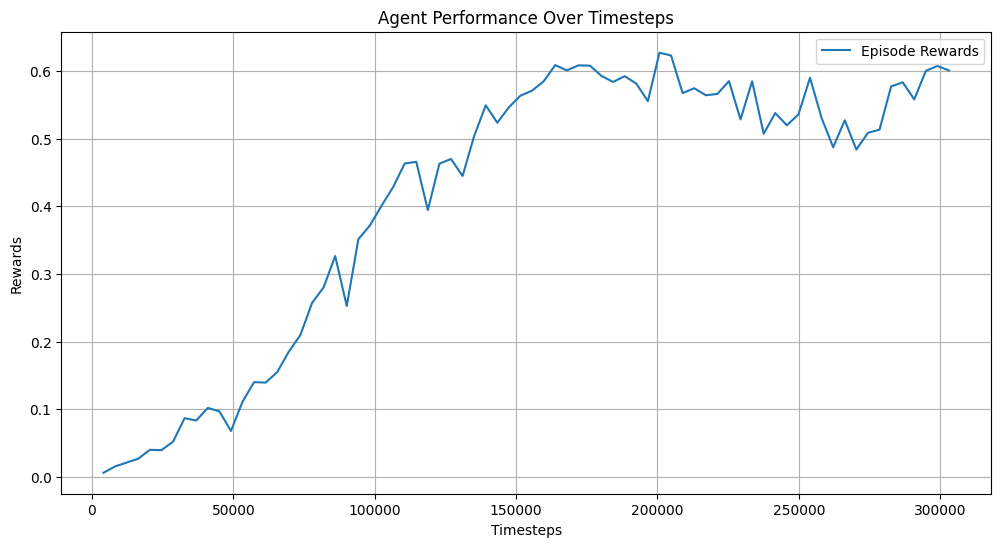

In [ ]:
results, models = curriculum_experiment_no_transfer(difficulty_order, timesteps_per_difficulty=300_000)

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 


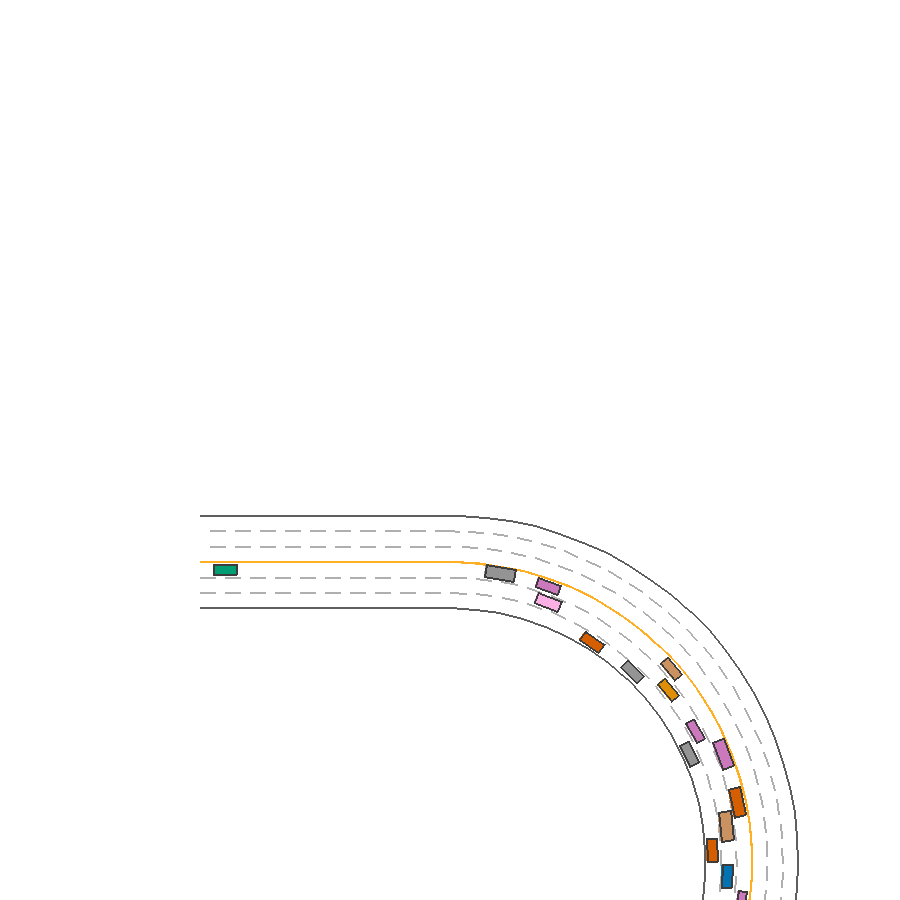

In [ ]:
model = models[0][1]
env = create_environment('hard', render=False, monitor=False)
obs, _ = env.reset()
try:
    for i in range(1_000):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, _, info = env.step(action)
        # total_reward += reward
        ret = env.render(mode="topdown",
                         screen_record=True,
                         window=False,
                         screen_size=(900, 900),
                         camera_position=(50, 30))
        if done:
            # print("episode_reward", total_reward)
            break

    env.top_down_renderer.generate_gif()
finally:
    env.close()
# prompt: load demo.gif and display it

from IPython.display import Image

Image(filename='demo.gif')

In [ ]:
results, models = curriculum_experiment_no_transfer(difficulty_order, timesteps_per_difficulty=3000_000)

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


Training on hard difficulty (No Transfer)...
Using cuda device
Wrapping the env in a DummyVecEnv.


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.85e+03 |
|    ep_rew_mean     | 16.9     |
| time/              |          |
|    fps             | 142      |
|    iterations      | 1        |
|    time_elapsed    | 28       |
|    total_timesteps | 4096     |
---------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.15e+03    |
|    ep_rew_mean          | 11.5        |
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 2           |
|    time_elapsed         | 80          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.014718721 |
|    clip_fraction        | 0.198       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.83       |
|    explained_variance   | -0.00494    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.356       |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0116     |
|    std                  | 0.99        |
|    value_loss           | 0.143       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.22e+03    |
|    ep_rew_mean          | 16.3        |
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 3           |
|    time_elapsed         | 116         |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.008283889 |
|    clip_fraction        | 0.11        |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.83       |
|    explained_variance   | -0.0316     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.362       |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.00509    |
|    std                  | 1           |
|    value_loss           | 0.325       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 817         |
|    ep_rew_mean          | 12.5        |
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 4           |
|    time_elapsed         | 163         |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.018795114 |
|    clip_fraction        | 0.234       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.81       |
|    explained_variance   | 0.0277      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.055       |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.0149     |
|    std                  | 0.977       |
|    value_loss           | 0.232       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 741         |
|    ep_rew_mean          | 13.5        |
| time/                   |             |
|    fps                  | 92          |
|    iterations           | 5           |
|    time_elapsed         | 222         |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.008814253 |
|    clip_fraction        | 0.136       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.78       |
|    explained_variance   | 0.0194      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.542       |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.00662    |
|    std                  | 0.969       |
|    value_loss           | 0.787       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 556          |
|    ep_rew_mean          | 11.8         |
| time/                   |              |
|    fps                  | 82           |
|    iterations           | 6            |
|    time_elapsed         | 299          |
|    total_timesteps      | 24576        |
| train/                  |              |
|    approx_kl            | 0.0113923345 |
|    clip_fraction        | 0.122        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.76        |
|    explained_variance   | -0.0797      |
|    learning_rate        | 0.0003       |
|    loss                 | 0.145        |
|    n_updates            | 50           |
|    policy_gradient_loss | -0.00609     |
|    std                  | 0.96         |
|    value_loss           | 0.588        |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 462          |
|    ep_rew_mean          | 11.1         |
| time/                   |              |
|    fps                  | 72           |
|    iterations           | 7            |
|    time_elapsed         | 395          |
|    total_timesteps      | 28672        |
| train/                  |              |
|    approx_kl            | 0.0044959597 |
|    clip_fraction        | 0.0356       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.74        |
|    explained_variance   | 0.139        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.374        |
|    n_updates            | 60           |
|    policy_gradient_loss | -0.00214     |
|    std                  | 0.948        |
|    value_loss           | 1.34         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 394         |
|    ep_rew_mean          | 10.9        |
| time/                   |             |
|    fps                  | 66          |
|    iterations           | 8           |
|    time_elapsed         | 494         |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.006298082 |
|    clip_fraction        | 0.0753      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.7        |
|    explained_variance   | 0.513       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.284       |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.00486    |
|    std                  | 0.927       |
|    value_loss           | 1.01        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 366         |
|    ep_rew_mean          | 11.5        |
| time/                   |             |
|    fps                  | 64          |
|    iterations           | 9           |
|    time_elapsed         | 573         |
|    total_timesteps      | 36864       |
| train/                  |             |
|    approx_kl            | 0.008199549 |
|    clip_fraction        | 0.0877      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.67       |
|    explained_variance   | 0.761       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.196       |
|    n_updates            | 80          |
|    policy_gradient_loss | -0.00681    |
|    std                  | 0.915       |
|    value_loss           | 0.827       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 191         |
|    ep_rew_mean          | 10          |
| time/                   |             |
|    fps                  | 63          |
|    iterations           | 10          |
|    time_elapsed         | 647         |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.007381537 |
|    clip_fraction        | 0.0923      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.64       |
|    explained_variance   | 0.554       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.388       |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.00376    |
|    std                  | 0.904       |
|    value_loss           | 1.72        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 178         |
|    ep_rew_mean          | 11.4        |
| time/                   |             |
|    fps                  | 61          |
|    iterations           | 11          |
|    time_elapsed         | 738         |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.007427294 |
|    clip_fraction        | 0.0982      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.62       |
|    explained_variance   | 0.079       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.41        |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.00685    |
|    std                  | 0.895       |
|    value_loss           | 3.97        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 175          |
|    ep_rew_mean          | 13.6         |
| time/                   |              |
|    fps                  | 58           |
|    iterations           | 12           |
|    time_elapsed         | 836          |
|    total_timesteps      | 49152        |
| train/                  |              |
|    approx_kl            | 0.0077096764 |
|    clip_fraction        | 0.0676       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.6         |
|    explained_variance   | 0.524        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.79         |
|    n_updates            | 110          |
|    policy_gradient_loss | -0.00484     |
|    std                  | 0.887        |
|    value_loss           | 2.45         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 153         |
|    ep_rew_mean          | 14.2        |
| time/                   |             |
|    fps                  | 56          |
|    iterations           | 13          |
|    time_elapsed         | 939         |
|    total_timesteps      | 53248       |
| train/                  |             |
|    approx_kl            | 0.013911245 |
|    clip_fraction        | 0.141       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.59       |
|    explained_variance   | 0.697       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.09        |
|    n_updates            | 120         |
|    policy_gradient_loss | -0.00762    |
|    std                  | 0.879       |
|    value_loss           | 2.01        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 144         |
|    ep_rew_mean          | 15.9        |
| time/                   |             |
|    fps                  | 54          |
|    iterations           | 14          |
|    time_elapsed         | 1043        |
|    total_timesteps      | 57344       |
| train/                  |             |
|    approx_kl            | 0.007298982 |
|    clip_fraction        | 0.115       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.57       |
|    explained_variance   | 0.61        |
|    learning_rate        | 0.0003      |
|    loss                 | 2.44        |
|    n_updates            | 130         |
|    policy_gradient_loss | -0.00411    |
|    std                  | 0.871       |
|    value_loss           | 4.6         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 115         |
|    ep_rew_mean          | 14.3        |
| time/                   |             |
|    fps                  | 53          |
|    iterations           | 15          |
|    time_elapsed         | 1152        |
|    total_timesteps      | 61440       |
| train/                  |             |
|    approx_kl            | 0.007794533 |
|    clip_fraction        | 0.0719      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.54       |
|    explained_variance   | 0.466       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.8         |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.00155    |
|    std                  | 0.861       |
|    value_loss           | 5.62        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 114        |
|    ep_rew_mean          | 17.2       |
| time/                   |            |
|    fps                  | 52         |
|    iterations           | 16         |
|    time_elapsed         | 1258       |
|    total_timesteps      | 65536      |
| train/                  |            |
|    approx_kl            | 0.00894409 |
|    clip_fraction        | 0.137      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.52      |
|    explained_variance   | 0.566      |
|    learning_rate        | 0.0003     |
|    loss                 | 3.48       |
|    n_updates            | 150        |
|    policy_gradient_loss | -0.00638   |
|    std                  | 0.851      |
|    value_loss           | 6.64       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 126         |
|    ep_rew_mean          | 23          |
| time/                   |             |
|    fps                  | 51          |
|    iterations           | 17          |
|    time_elapsed         | 1362        |
|    total_timesteps      | 69632       |
| train/                  |             |
|    approx_kl            | 0.008060167 |
|    clip_fraction        | 0.0912      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.5        |
|    explained_variance   | 0.479       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.54        |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.00603    |
|    std                  | 0.842       |
|    value_loss           | 8.95        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 136         |
|    ep_rew_mean          | 28.5        |
| time/                   |             |
|    fps                  | 50          |
|    iterations           | 18          |
|    time_elapsed         | 1470        |
|    total_timesteps      | 73728       |
| train/                  |             |
|    approx_kl            | 0.012818029 |
|    clip_fraction        | 0.146       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.47       |
|    explained_variance   | 0.499       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.63        |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.00197    |
|    std                  | 0.825       |
|    value_loss           | 8.48        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 141         |
|    ep_rew_mean          | 32.5        |
| time/                   |             |
|    fps                  | 49          |
|    iterations           | 19          |
|    time_elapsed         | 1573        |
|    total_timesteps      | 77824       |
| train/                  |             |
|    approx_kl            | 0.015898092 |
|    clip_fraction        | 0.242       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.44       |
|    explained_variance   | 0.415       |
|    learning_rate        | 0.0003      |
|    loss                 | 6.01        |
|    n_updates            | 180         |
|    policy_gradient_loss | -0.00724    |
|    std                  | 0.814       |
|    value_loss           | 10.3        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 119         |
|    ep_rew_mean          | 28          |
| time/                   |             |
|    fps                  | 48          |
|    iterations           | 20          |
|    time_elapsed         | 1684        |
|    total_timesteps      | 81920       |
| train/                  |             |
|    approx_kl            | 0.013351615 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.41       |
|    explained_variance   | 0.301       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.6         |
|    n_updates            | 190         |
|    policy_gradient_loss | -0.00353    |
|    std                  | 0.802       |
|    value_loss           | 12.5        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 118         |
|    ep_rew_mean          | 28.7        |
| time/                   |             |
|    fps                  | 47          |
|    iterations           | 21          |
|    time_elapsed         | 1794        |
|    total_timesteps      | 86016       |
| train/                  |             |
|    approx_kl            | 0.012251746 |
|    clip_fraction        | 0.242       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.39       |
|    explained_variance   | 0.349       |
|    learning_rate        | 0.0003      |
|    loss                 | 9.28        |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.00509    |
|    std                  | 0.797       |
|    value_loss           | 18.4        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 133         |
|    ep_rew_mean          | 34.1        |
| time/                   |             |
|    fps                  | 47          |
|    iterations           | 22          |
|    time_elapsed         | 1882        |
|    total_timesteps      | 90112       |
| train/                  |             |
|    approx_kl            | 0.032018878 |
|    clip_fraction        | 0.242       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.38       |
|    explained_variance   | 0.365       |
|    learning_rate        | 0.0003      |
|    loss                 | 12.8        |
|    n_updates            | 210         |
|    policy_gradient_loss | -0.00819    |
|    std                  | 0.791       |
|    value_loss           | 17.1        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episo

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 147         |
|    ep_rew_mean          | 41.1        |
| time/                   |             |
|    fps                  | 47          |
|    iterations           | 23          |
|    time_elapsed         | 1980        |
|    total_timesteps      | 94208       |
| train/                  |             |
|    approx_kl            | 0.012975024 |
|    clip_fraction        | 0.191       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.34       |
|    explained_variance   | 0.294       |
|    learning_rate        | 0.0003      |
|    loss                 | 7.16        |
|    n_updates            | 220         |
|    policy_gradient_loss | 0.00244     |
|    std                  | 0.77        |
|    value_loss           | 12.9        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehic

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 168          |
|    ep_rew_mean          | 51.2         |
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 24           |
|    time_elapsed         | 2089         |
|    total_timesteps      | 98304        |
| train/                  |              |
|    approx_kl            | 0.0135627985 |
|    clip_fraction        | 0.145        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.29        |
|    explained_variance   | 0.525        |
|    learning_rate        | 0.0003       |
|    loss                 | 4.17         |
|    n_updates            | 230          |
|    policy_gradient_loss | -0.00133     |
|    std                  | 0.757        |
|    value_loss           | 14.9         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO]

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 179        |
|    ep_rew_mean          | 58.2       |
| time/                   |            |
|    fps                  | 46         |
|    iterations           | 25         |
|    time_elapsed         | 2200       |
|    total_timesteps      | 102400     |
| train/                  |            |
|    approx_kl            | 0.02132821 |
|    clip_fraction        | 0.213      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.25      |
|    explained_variance   | 0.678      |
|    learning_rate        | 0.0003     |
|    loss                 | 3.13       |
|    n_updates            | 240        |
|    policy_gradient_loss | 0.00904    |
|    std                  | 0.741      |
|    value_loss           | 6.83       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INF

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 161         |
|    ep_rew_mean          | 55.4        |
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 26          |
|    time_elapsed         | 2315        |
|    total_timesteps      | 106496      |
| train/                  |             |
|    approx_kl            | 0.009000473 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.21       |
|    explained_variance   | 0.755       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.57        |
|    n_updates            | 250         |
|    policy_gradient_loss | -0.00391    |
|    std                  | 0.724       |
|    value_loss           | 12          |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 160         |
|    ep_rew_mean          | 57.9        |
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 27          |
|    time_elapsed         | 2431        |
|    total_timesteps      | 110592      |
| train/                  |             |
|    approx_kl            | 0.009851256 |
|    clip_fraction        | 0.135       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.17       |
|    explained_variance   | 0.698       |
|    learning_rate        | 0.0003      |
|    loss                 | 13.4        |
|    n_updates            | 260         |
|    policy_gradient_loss | -0.00271    |
|    std                  | 0.713       |
|    value_loss           | 19.9        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 155         |
|    ep_rew_mean          | 59.7        |
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 28          |
|    time_elapsed         | 2546        |
|    total_timesteps      | 114688      |
| train/                  |             |
|    approx_kl            | 0.023215482 |
|    clip_fraction        | 0.182       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.15       |
|    explained_variance   | 0.778       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.86        |
|    n_updates            | 270         |
|    policy_gradient_loss | -0.000848   |
|    std                  | 0.705       |
|    value_loss           | 12.9        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 163         |
|    ep_rew_mean          | 66.1        |
| time/                   |             |
|    fps                  | 44          |
|    iterations           | 29          |
|    time_elapsed         | 2660        |
|    total_timesteps      | 118784      |
| train/                  |             |
|    approx_kl            | 0.011526269 |
|    clip_fraction        | 0.163       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.13       |
|    explained_variance   | 0.747       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.92        |
|    n_updates            | 280         |
|    policy_gradient_loss | -0.00686    |
|    std                  | 0.7         |
|    value_loss           | 16.6        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INF

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 173         |
|    ep_rew_mean          | 73          |
| time/                   |             |
|    fps                  | 44          |
|    iterations           | 30          |
|    time_elapsed         | 2774        |
|    total_timesteps      | 122880      |
| train/                  |             |
|    approx_kl            | 0.009544204 |
|    clip_fraction        | 0.217       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.11       |
|    explained_variance   | 0.809       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.12        |
|    n_updates            | 290         |
|    policy_gradient_loss | 0.00393     |
|    std                  | 0.695       |
|    value_loss           | 11          |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehic

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 171         |
|    ep_rew_mean          | 75.5        |
| time/                   |             |
|    fps                  | 43          |
|    iterations           | 31          |
|    time_elapsed         | 2888        |
|    total_timesteps      | 126976      |
| train/                  |             |
|    approx_kl            | 0.026977072 |
|    clip_fraction        | 0.162       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.09       |
|    explained_variance   | 0.754       |
|    learning_rate        | 0.0003      |
|    loss                 | 5.32        |
|    n_updates            | 300         |
|    policy_gradient_loss | -0.0037     |
|    std                  | 0.683       |
|    value_loss           | 16.2        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehic

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 174         |
|    ep_rew_mean          | 79.1        |
| time/                   |             |
|    fps                  | 43          |
|    iterations           | 32          |
|    time_elapsed         | 3003        |
|    total_timesteps      | 131072      |
| train/                  |             |
|    approx_kl            | 0.009690997 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.06       |
|    explained_variance   | 0.765       |
|    learning_rate        | 0.0003      |
|    loss                 | 7.47        |
|    n_updates            | 310         |
|    policy_gradient_loss | -0.00366    |
|    std                  | 0.676       |
|    value_loss           | 16.3        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Epi

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 133        |
|    ep_rew_mean          | 59.9       |
| time/                   |            |
|    fps                  | 43         |
|    iterations           | 33         |
|    time_elapsed         | 3120       |
|    total_timesteps      | 135168     |
| train/                  |            |
|    approx_kl            | 0.02409627 |
|    clip_fraction        | 0.218      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.02      |
|    explained_variance   | 0.908      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.475      |
|    n_updates            | 320        |
|    policy_gradient_loss | 0.0023     |
|    std                  | 0.663      |
|    value_loss           | 5.64       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[I

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 120         |
|    ep_rew_mean          | 52.5        |
| time/                   |             |
|    fps                  | 43          |
|    iterations           | 34          |
|    time_elapsed         | 3234        |
|    total_timesteps      | 139264      |
| train/                  |             |
|    approx_kl            | 0.009767863 |
|    clip_fraction        | 0.161       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2          |
|    explained_variance   | 0.415       |
|    learning_rate        | 0.0003      |
|    loss                 | 18.9        |
|    n_updates            | 330         |
|    policy_gradient_loss | -0.0112     |
|    std                  | 0.655       |
|    value_loss           | 48.5        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] E

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 117         |
|    ep_rew_mean          | 51.6        |
| time/                   |             |
|    fps                  | 42          |
|    iterations           | 35          |
|    time_elapsed         | 3349        |
|    total_timesteps      | 143360      |
| train/                  |             |
|    approx_kl            | 0.013296431 |
|    clip_fraction        | 0.198       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.98       |
|    explained_variance   | 0.65        |
|    learning_rate        | 0.0003      |
|    loss                 | 22.4        |
|    n_updates            | 340         |
|    policy_gradient_loss | -0.0116     |
|    std                  | 0.649       |
|    value_loss           | 36.2        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehic

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 130         |
|    ep_rew_mean          | 61.3        |
| time/                   |             |
|    fps                  | 42          |
|    iterations           | 36          |
|    time_elapsed         | 3470        |
|    total_timesteps      | 147456      |
| train/                  |             |
|    approx_kl            | 0.015236737 |
|    clip_fraction        | 0.218       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.95       |
|    explained_variance   | 0.743       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.37        |
|    n_updates            | 350         |
|    policy_gradient_loss | -0.00218    |
|    std                  | 0.644       |
|    value_loss           | 21.9        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash v

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 131         |
|    ep_rew_mean          | 65.1        |
| time/                   |             |
|    fps                  | 42          |
|    iterations           | 37          |
|    time_elapsed         | 3593        |
|    total_timesteps      | 151552      |
| train/                  |             |
|    approx_kl            | 0.011690424 |
|    clip_fraction        | 0.207       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.92       |
|    explained_variance   | 0.837       |
|    learning_rate        | 0.0003      |
|    loss                 | 5.44        |
|    n_updates            | 360         |
|    policy_gradient_loss | 0.00199     |
|    std                  | 0.632       |
|    value_loss           | 14.3        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehic

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 136         |
|    ep_rew_mean          | 71.1        |
| time/                   |             |
|    fps                  | 41          |
|    iterations           | 38          |
|    time_elapsed         | 3718        |
|    total_timesteps      | 155648      |
| train/                  |             |
|    approx_kl            | 0.020671865 |
|    clip_fraction        | 0.239       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.88       |
|    explained_variance   | 0.902       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.9         |
|    n_updates            | 370         |
|    policy_gradient_loss | 0.00224     |
|    std                  | 0.619       |
|    value_loss           | 10.8        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash veh

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 137         |
|    ep_rew_mean          | 73.6        |
| time/                   |             |
|    fps                  | 41          |
|    iterations           | 39          |
|    time_elapsed         | 3841        |
|    total_timesteps      | 159744      |
| train/                  |             |
|    approx_kl            | 0.015923183 |
|    clip_fraction        | 0.238       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.83       |
|    explained_variance   | 0.949       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.03        |
|    n_updates            | 380         |
|    policy_gradient_loss | 0.00663     |
|    std                  | 0.606       |
|    value_loss           | 4.83        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[I

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 135         |
|    ep_rew_mean          | 73.6        |
| time/                   |             |
|    fps                  | 41          |
|    iterations           | 40          |
|    time_elapsed         | 3963        |
|    total_timesteps      | 163840      |
| train/                  |             |
|    approx_kl            | 0.015606488 |
|    clip_fraction        | 0.205       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.8        |
|    explained_variance   | 0.972       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.64        |
|    n_updates            | 390         |
|    policy_gradient_loss | -0.00159    |
|    std                  | 0.598       |
|    value_loss           | 3.59        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash v

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 135         |
|    ep_rew_mean          | 75.2        |
| time/                   |             |
|    fps                  | 41          |
|    iterations           | 41          |
|    time_elapsed         | 4086        |
|    total_timesteps      | 167936      |
| train/                  |             |
|    approx_kl            | 0.015602355 |
|    clip_fraction        | 0.164       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.78       |
|    explained_variance   | 0.856       |
|    learning_rate        | 0.0003      |
|    loss                 | 7.36        |
|    n_updates            | 400         |
|    policy_gradient_loss | -0.00267    |
|    std                  | 0.593       |
|    value_loss           | 18.3        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehic

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 131         |
|    ep_rew_mean          | 74.2        |
| time/                   |             |
|    fps                  | 40          |
|    iterations           | 42          |
|    time_elapsed         | 4209        |
|    total_timesteps      | 172032      |
| train/                  |             |
|    approx_kl            | 0.022367258 |
|    clip_fraction        | 0.265       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.75       |
|    explained_variance   | 0.987       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.31        |
|    n_updates            | 410         |
|    policy_gradient_loss | 0.00682     |
|    std                  | 0.585       |
|    value_loss           | 1.17        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehic

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 126         |
|    ep_rew_mean          | 73.1        |
| time/                   |             |
|    fps                  | 40          |
|    iterations           | 43          |
|    time_elapsed         | 4333        |
|    total_timesteps      | 176128      |
| train/                  |             |
|    approx_kl            | 0.016330624 |
|    clip_fraction        | 0.245       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.73       |
|    explained_variance   | 0.959       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.508       |
|    n_updates            | 420         |
|    policy_gradient_loss | 0.00618     |
|    std                  | 0.579       |
|    value_loss           | 6.01        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash v

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 121        |
|    ep_rew_mean          | 70.5       |
| time/                   |            |
|    fps                  | 40         |
|    iterations           | 44         |
|    time_elapsed         | 4459       |
|    total_timesteps      | 180224     |
| train/                  |            |
|    approx_kl            | 0.02814626 |
|    clip_fraction        | 0.23       |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.7       |
|    explained_variance   | 0.949      |
|    learning_rate        | 0.0003     |
|    loss                 | 11.8       |
|    n_updates            | 430        |
|    policy_gradient_loss | 0.000886   |
|    std                  | 0.573      |
|    value_loss           | 9.76       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash veh

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 117         |
|    ep_rew_mean          | 70.4        |
| time/                   |             |
|    fps                  | 40          |
|    iterations           | 45          |
|    time_elapsed         | 4584        |
|    total_timesteps      | 184320      |
| train/                  |             |
|    approx_kl            | 0.017158885 |
|    clip_fraction        | 0.147       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.68       |
|    explained_variance   | 0.93        |
|    learning_rate        | 0.0003      |
|    loss                 | 4.23        |
|    n_updates            | 440         |
|    policy_gradient_loss | 0.00138     |
|    std                  | 0.565       |
|    value_loss           | 11.8        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash v

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 118        |
|    ep_rew_mean          | 71.6       |
| time/                   |            |
|    fps                  | 40         |
|    iterations           | 46         |
|    time_elapsed         | 4707       |
|    total_timesteps      | 188416     |
| train/                  |            |
|    approx_kl            | 0.02321719 |
|    clip_fraction        | 0.224      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.64      |
|    explained_variance   | 0.968      |
|    learning_rate        | 0.0003     |
|    loss                 | 1.05       |
|    n_updates            | 450        |
|    policy_gradient_loss | 0.00395    |
|    std                  | 0.556      |
|    value_loss           | 5.41       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash v

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 118         |
|    ep_rew_mean          | 72          |
| time/                   |             |
|    fps                  | 39          |
|    iterations           | 47          |
|    time_elapsed         | 4833        |
|    total_timesteps      | 192512      |
| train/                  |             |
|    approx_kl            | 0.026831882 |
|    clip_fraction        | 0.217       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.62       |
|    explained_variance   | 0.995       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.251       |
|    n_updates            | 460         |
|    policy_gradient_loss | 0.00096     |
|    std                  | 0.554       |
|    value_loss           | 0.73        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash v

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 121         |
|    ep_rew_mean          | 73.4        |
| time/                   |             |
|    fps                  | 39          |
|    iterations           | 48          |
|    time_elapsed         | 4959        |
|    total_timesteps      | 196608      |
| train/                  |             |
|    approx_kl            | 0.008648993 |
|    clip_fraction        | 0.128       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.61       |
|    explained_variance   | 0.948       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.32        |
|    n_updates            | 470         |
|    policy_gradient_loss | 0.000128    |
|    std                  | 0.553       |
|    value_loss           | 8.99        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_ro

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 119         |
|    ep_rew_mean          | 71.9        |
| time/                   |             |
|    fps                  | 39          |
|    iterations           | 49          |
|    time_elapsed         | 5085        |
|    total_timesteps      | 200704      |
| train/                  |             |
|    approx_kl            | 0.025710776 |
|    clip_fraction        | 0.22        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.6        |
|    explained_variance   | 0.991       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.311       |
|    n_updates            | 480         |
|    policy_gradient_loss | 0.00301     |
|    std                  | 0.55        |
|    value_loss           | 1.39        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 125         |
|    ep_rew_mean          | 75          |
| time/                   |             |
|    fps                  | 39          |
|    iterations           | 50          |
|    time_elapsed         | 5207        |
|    total_timesteps      | 204800      |
| train/                  |             |
|    approx_kl            | 0.012120428 |
|    clip_fraction        | 0.186       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.59       |
|    explained_variance   | 0.938       |
|    learning_rate        | 0.0003      |
|    loss                 | 12.1        |
|    n_updates            | 490         |
|    policy_gradient_loss | -0.00398    |
|    std                  | 0.548       |
|    value_loss           | 11          |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 126          |
|    ep_rew_mean          | 76.1         |
| time/                   |              |
|    fps                  | 39           |
|    iterations           | 51           |
|    time_elapsed         | 5329         |
|    total_timesteps      | 208896       |
| train/                  |              |
|    approx_kl            | 0.0076663857 |
|    clip_fraction        | 0.147        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.58        |
|    explained_variance   | 0.917        |
|    learning_rate        | 0.0003       |
|    loss                 | 11.9         |
|    n_updates            | 500          |
|    policy_gradient_loss | -0.00572     |
|    std                  | 0.546        |
|    value_loss           | 15.5         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash v

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | 78.4        |
| time/                   |             |
|    fps                  | 39          |
|    iterations           | 52          |
|    time_elapsed         | 5456        |
|    total_timesteps      | 212992      |
| train/                  |             |
|    approx_kl            | 0.018742206 |
|    clip_fraction        | 0.157       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.55       |
|    explained_variance   | 0.925       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.19        |
|    n_updates            | 510         |
|    policy_gradient_loss | -0.000894   |
|    std                  | 0.534       |
|    value_loss           | 10.7        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash v

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 126         |
|    ep_rew_mean          | 78.6        |
| time/                   |             |
|    fps                  | 38          |
|    iterations           | 53          |
|    time_elapsed         | 5579        |
|    total_timesteps      | 217088      |
| train/                  |             |
|    approx_kl            | 0.022281213 |
|    clip_fraction        | 0.221       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.53       |
|    explained_variance   | 0.959       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.15        |
|    n_updates            | 520         |
|    policy_gradient_loss | -0.00229    |
|    std                  | 0.535       |
|    value_loss           | 6.43        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehic

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 125         |
|    ep_rew_mean          | 79.5        |
| time/                   |             |
|    fps                  | 38          |
|    iterations           | 54          |
|    time_elapsed         | 5701        |
|    total_timesteps      | 221184      |
| train/                  |             |
|    approx_kl            | 0.016144998 |
|    clip_fraction        | 0.206       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.52       |
|    explained_variance   | 0.971       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.29        |
|    n_updates            | 530         |
|    policy_gradient_loss | -0.00498    |
|    std                  | 0.532       |
|    value_loss           | 4.51        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 126          |
|    ep_rew_mean          | 79.9         |
| time/                   |              |
|    fps                  | 38           |
|    iterations           | 55           |
|    time_elapsed         | 5820         |
|    total_timesteps      | 225280       |
| train/                  |              |
|    approx_kl            | 0.0143020535 |
|    clip_fraction        | 0.183        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.5         |
|    explained_variance   | 0.941        |
|    learning_rate        | 0.0003       |
|    loss                 | 3.86         |
|    n_updates            | 540          |
|    policy_gradient_loss | -0.00363     |
|    std                  | 0.525        |
|    value_loss           | 8.04         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehic

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 117         |
|    ep_rew_mean          | 74.6        |
| time/                   |             |
|    fps                  | 38          |
|    iterations           | 56          |
|    time_elapsed         | 5945        |
|    total_timesteps      | 229376      |
| train/                  |             |
|    approx_kl            | 0.017838458 |
|    clip_fraction        | 0.193       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.46       |
|    explained_variance   | 0.899       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.72        |
|    n_updates            | 550         |
|    policy_gradient_loss | -0.0054     |
|    std                  | 0.517       |
|    value_loss           | 17.7        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehic

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 112         |
|    ep_rew_mean          | 71.8        |
| time/                   |             |
|    fps                  | 38          |
|    iterations           | 57          |
|    time_elapsed         | 6071        |
|    total_timesteps      | 233472      |
| train/                  |             |
|    approx_kl            | 0.026483791 |
|    clip_fraction        | 0.217       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.44       |
|    explained_variance   | 0.871       |
|    learning_rate        | 0.0003      |
|    loss                 | 5.95        |
|    n_updates            | 560         |
|    policy_gradient_loss | -0.00263    |
|    std                  | 0.514       |
|    value_loss           | 20.3        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 117         |
|    ep_rew_mean          | 75.1        |
| time/                   |             |
|    fps                  | 38          |
|    iterations           | 58          |
|    time_elapsed         | 6191        |
|    total_timesteps      | 237568      |
| train/                  |             |
|    approx_kl            | 0.016527696 |
|    clip_fraction        | 0.193       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.44       |
|    explained_variance   | 0.946       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.83        |
|    n_updates            | 570         |
|    policy_gradient_loss | -0.00122    |
|    std                  | 0.516       |
|    value_loss           | 8.46        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash veh

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 124         |
|    ep_rew_mean          | 79.2        |
| time/                   |             |
|    fps                  | 38          |
|    iterations           | 59          |
|    time_elapsed         | 6311        |
|    total_timesteps      | 241664      |
| train/                  |             |
|    approx_kl            | 0.018304642 |
|    clip_fraction        | 0.193       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.45       |
|    explained_variance   | 0.915       |
|    learning_rate        | 0.0003      |
|    loss                 | 14          |
|    n_updates            | 580         |
|    policy_gradient_loss | -0.00144    |
|    std                  | 0.522       |
|    value_loss           | 16.9        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash veh

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 126         |
|    ep_rew_mean          | 81.1        |
| time/                   |             |
|    fps                  | 38          |
|    iterations           | 60          |
|    time_elapsed         | 6432        |
|    total_timesteps      | 245760      |
| train/                  |             |
|    approx_kl            | 0.021545298 |
|    clip_fraction        | 0.22        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.48       |
|    explained_variance   | 0.913       |
|    learning_rate        | 0.0003      |
|    loss                 | 15.9        |
|    n_updates            | 590         |
|    policy_gradient_loss | -0.00225    |
|    std                  | 0.532       |
|    value_loss           | 16.6        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash v

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 131        |
|    ep_rew_mean          | 83.5       |
| time/                   |            |
|    fps                  | 38         |
|    iterations           | 61         |
|    time_elapsed         | 6557       |
|    total_timesteps      | 249856     |
| train/                  |            |
|    approx_kl            | 0.02263191 |
|    clip_fraction        | 0.24       |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.48      |
|    explained_variance   | 0.95       |
|    learning_rate        | 0.0003     |
|    loss                 | 3.47       |
|    n_updates            | 600        |
|    policy_gradient_loss | -0.000839  |
|    std                  | 0.53       |
|    value_loss           | 9.4        |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehic

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 133        |
|    ep_rew_mean          | 83.1       |
| time/                   |            |
|    fps                  | 38         |
|    iterations           | 62         |
|    time_elapsed         | 6674       |
|    total_timesteps      | 253952     |
| train/                  |            |
|    approx_kl            | 0.01668384 |
|    clip_fraction        | 0.23       |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.48      |
|    explained_variance   | 0.945      |
|    learning_rate        | 0.0003     |
|    loss                 | 2.56       |
|    n_updates            | 610        |
|    policy_gradient_loss | 0.00115    |
|    std                  | 0.532      |
|    value_loss           | 7.5        |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehic

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 138         |
|    ep_rew_mean          | 86.7        |
| time/                   |             |
|    fps                  | 37          |
|    iterations           | 63          |
|    time_elapsed         | 6792        |
|    total_timesteps      | 258048      |
| train/                  |             |
|    approx_kl            | 0.015132293 |
|    clip_fraction        | 0.187       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.48       |
|    explained_variance   | 0.897       |
|    learning_rate        | 0.0003      |
|    loss                 | 7.35        |
|    n_updates            | 620         |
|    policy_gradient_loss | -0.00332    |
|    std                  | 0.533       |
|    value_loss           | 15.4        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 152         |
|    ep_rew_mean          | 94.8        |
| time/                   |             |
|    fps                  | 37          |
|    iterations           | 64          |
|    time_elapsed         | 6902        |
|    total_timesteps      | 262144      |
| train/                  |             |
|    approx_kl            | 0.019867163 |
|    clip_fraction        | 0.195       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.48       |
|    explained_variance   | 0.882       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.41        |
|    n_updates            | 630         |
|    policy_gradient_loss | -0.00209    |
|    std                  | 0.538       |
|    value_loss           | 18.1        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehic

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 158         |
|    ep_rew_mean          | 97.2        |
| time/                   |             |
|    fps                  | 37          |
|    iterations           | 65          |
|    time_elapsed         | 7018        |
|    total_timesteps      | 266240      |
| train/                  |             |
|    approx_kl            | 0.020090923 |
|    clip_fraction        | 0.171       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.49       |
|    explained_variance   | 0.835       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.74        |
|    n_updates            | 640         |
|    policy_gradient_loss | -0.00209    |
|    std                  | 0.541       |
|    value_loss           | 20.7        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 160         |
|    ep_rew_mean          | 98.7        |
| time/                   |             |
|    fps                  | 37          |
|    iterations           | 66          |
|    time_elapsed         | 7135        |
|    total_timesteps      | 270336      |
| train/                  |             |
|    approx_kl            | 0.013149876 |
|    clip_fraction        | 0.178       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.5        |
|    explained_variance   | 0.857       |
|    learning_rate        | 0.0003      |
|    loss                 | 7.03        |
|    n_updates            | 650         |
|    policy_gradient_loss | -0.00138    |
|    std                  | 0.542       |
|    value_loss           | 17.6        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash veh

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 159         |
|    ep_rew_mean          | 97.1        |
| time/                   |             |
|    fps                  | 37          |
|    iterations           | 67          |
|    time_elapsed         | 7256        |
|    total_timesteps      | 274432      |
| train/                  |             |
|    approx_kl            | 0.017837547 |
|    clip_fraction        | 0.172       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.5        |
|    explained_variance   | 0.866       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.07        |
|    n_updates            | 660         |
|    policy_gradient_loss | 0.000756    |
|    std                  | 0.544       |
|    value_loss           | 20          |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 154         |
|    ep_rew_mean          | 93.6        |
| time/                   |             |
|    fps                  | 37          |
|    iterations           | 68          |
|    time_elapsed         | 7372        |
|    total_timesteps      | 278528      |
| train/                  |             |
|    approx_kl            | 0.028562546 |
|    clip_fraction        | 0.209       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.5        |
|    explained_variance   | 0.905       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.07        |
|    n_updates            | 670         |
|    policy_gradient_loss | 0.0013      |
|    std                  | 0.544       |
|    value_loss           | 15.7        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[I

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 165         |
|    ep_rew_mean          | 97.7        |
| time/                   |             |
|    fps                  | 37          |
|    iterations           | 69          |
|    time_elapsed         | 7474        |
|    total_timesteps      | 282624      |
| train/                  |             |
|    approx_kl            | 0.014362427 |
|    clip_fraction        | 0.211       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.5        |
|    explained_variance   | 0.886       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.28        |
|    n_updates            | 680         |
|    policy_gradient_loss | -0.00236    |
|    std                  | 0.551       |
|    value_loss           | 17.4        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 185         |
|    ep_rew_mean          | 107         |
| time/                   |             |
|    fps                  | 37          |
|    iterations           | 70          |
|    time_elapsed         | 7570        |
|    total_timesteps      | 286720      |
| train/                  |             |
|    approx_kl            | 0.022155434 |
|    clip_fraction        | 0.189       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.5        |
|    explained_variance   | 0.808       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.3        |
|    n_updates            | 690         |
|    policy_gradient_loss | -0.00306    |
|    std                  | 0.552       |
|    value_loss           | 24.8        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO]

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 196         |
|    ep_rew_mean          | 114         |
| time/                   |             |
|    fps                  | 37          |
|    iterations           | 71          |
|    time_elapsed         | 7671        |
|    total_timesteps      | 290816      |
| train/                  |             |
|    approx_kl            | 0.014413085 |
|    clip_fraction        | 0.196       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.49       |
|    explained_variance   | 0.75        |
|    learning_rate        | 0.0003      |
|    loss                 | 7.81        |
|    n_updates            | 700         |
|    policy_gradient_loss | 0.000878    |
|    std                  | 0.549       |
|    value_loss           | 31.9        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 219        |
|    ep_rew_mean          | 126        |
| time/                   |            |
|    fps                  | 37         |
|    iterations           | 72         |
|    time_elapsed         | 7761       |
|    total_timesteps      | 294912     |
| train/                  |            |
|    approx_kl            | 0.03168265 |
|    clip_fraction        | 0.276      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.48      |
|    explained_variance   | 0.819      |
|    learning_rate        | 0.0003     |
|    loss                 | 16.7       |
|    n_updates            | 710        |
|    policy_gradient_loss | 0.0104     |
|    std                  | 0.546      |
|    value_loss           | 23.3       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episo

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 236         |
|    ep_rew_mean          | 135         |
| time/                   |             |
|    fps                  | 38          |
|    iterations           | 73          |
|    time_elapsed         | 7856        |
|    total_timesteps      | 299008      |
| train/                  |             |
|    approx_kl            | 0.008337697 |
|    clip_fraction        | 0.177       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.47       |
|    explained_variance   | 0.744       |
|    learning_rate        | 0.0003      |
|    loss                 | 16          |
|    n_updates            | 720         |
|    policy_gradient_loss | 0.000134    |
|    std                  | 0.543       |
|    value_loss           | 28.8        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INF

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 245         |
|    ep_rew_mean          | 138         |
| time/                   |             |
|    fps                  | 38          |
|    iterations           | 74          |
|    time_elapsed         | 7960        |
|    total_timesteps      | 303104      |
| train/                  |             |
|    approx_kl            | 0.018152412 |
|    clip_fraction        | 0.214       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.46       |
|    explained_variance   | 0.771       |
|    learning_rate        | 0.0003      |
|    loss                 | 5.43        |
|    n_updates            | 730         |
|    policy_gradient_loss | 0.00476     |
|    std                  | 0.544       |
|    value_loss           | 27.5        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[I

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 243         |
|    ep_rew_mean          | 140         |
| time/                   |             |
|    fps                  | 38          |
|    iterations           | 75          |
|    time_elapsed         | 8061        |
|    total_timesteps      | 307200      |
| train/                  |             |
|    approx_kl            | 0.012401106 |
|    clip_fraction        | 0.176       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.45       |
|    explained_variance   | 0.758       |
|    learning_rate        | 0.0003      |
|    loss                 | 15.3        |
|    n_updates            | 740         |
|    policy_gradient_loss | -0.000493   |
|    std                  | 0.538       |
|    value_loss           | 30.7        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episo

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 239        |
|    ep_rew_mean          | 139        |
| time/                   |            |
|    fps                  | 38         |
|    iterations           | 76         |
|    time_elapsed         | 8158       |
|    total_timesteps      | 311296     |
| train/                  |            |
|    approx_kl            | 0.01280483 |
|    clip_fraction        | 0.245      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.45      |
|    explained_variance   | 0.808      |
|    learning_rate        | 0.0003     |
|    loss                 | 10.4       |
|    n_updates            | 750        |
|    policy_gradient_loss | 0.00443    |
|    std                  | 0.541      |
|    value_loss           | 23         |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INF

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 233         |
|    ep_rew_mean          | 136         |
| time/                   |             |
|    fps                  | 38          |
|    iterations           | 77          |
|    time_elapsed         | 8263        |
|    total_timesteps      | 315392      |
| train/                  |             |
|    approx_kl            | 0.019290326 |
|    clip_fraction        | 0.23        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.42       |
|    explained_variance   | 0.753       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.37        |
|    n_updates            | 760         |
|    policy_gradient_loss | 0.00111     |
|    std                  | 0.533       |
|    value_loss           | 27          |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 230         |
|    ep_rew_mean          | 134         |
| time/                   |             |
|    fps                  | 38          |
|    iterations           | 78          |
|    time_elapsed         | 8356        |
|    total_timesteps      | 319488      |
| train/                  |             |
|    approx_kl            | 0.021818561 |
|    clip_fraction        | 0.232       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.39       |
|    explained_variance   | 0.752       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.04        |
|    n_updates            | 770         |
|    policy_gradient_loss | 0.00206     |
|    std                  | 0.528       |
|    value_loss           | 27.3        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 223         |
|    ep_rew_mean          | 131         |
| time/                   |             |
|    fps                  | 38          |
|    iterations           | 79          |
|    time_elapsed         | 8462        |
|    total_timesteps      | 323584      |
| train/                  |             |
|    approx_kl            | 0.013045901 |
|    clip_fraction        | 0.22        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.39       |
|    explained_variance   | 0.833       |
|    learning_rate        | 0.0003      |
|    loss                 | 7.98        |
|    n_updates            | 780         |
|    policy_gradient_loss | 0.00376     |
|    std                  | 0.533       |
|    value_loss           | 16.1        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 222         |
|    ep_rew_mean          | 128         |
| time/                   |             |
|    fps                  | 38          |
|    iterations           | 80          |
|    time_elapsed         | 8566        |
|    total_timesteps      | 327680      |
| train/                  |             |
|    approx_kl            | 0.017477281 |
|    clip_fraction        | 0.2         |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.4        |
|    explained_variance   | 0.811       |
|    learning_rate        | 0.0003      |
|    loss                 | 15.8        |
|    n_updates            | 790         |
|    policy_gradient_loss | -0.000353   |
|    std                  | 0.532       |
|    value_loss           | 22.4        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 231        |
|    ep_rew_mean          | 132        |
| time/                   |            |
|    fps                  | 38         |
|    iterations           | 81         |
|    time_elapsed         | 8659       |
|    total_timesteps      | 331776     |
| train/                  |            |
|    approx_kl            | 0.01874317 |
|    clip_fraction        | 0.244      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.4       |
|    explained_variance   | 0.777      |
|    learning_rate        | 0.0003     |
|    loss                 | 11.1       |
|    n_updates            | 800        |
|    policy_gradient_loss | 0.0021     |
|    std                  | 0.537      |
|    value_loss           | 26.4       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 241         |
|    ep_rew_mean          | 137         |
| time/                   |             |
|    fps                  | 38          |
|    iterations           | 82          |
|    time_elapsed         | 8745        |
|    total_timesteps      | 335872      |
| train/                  |             |
|    approx_kl            | 0.016238395 |
|    clip_fraction        | 0.234       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.42       |
|    explained_variance   | 0.839       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.07        |
|    n_updates            | 810         |
|    policy_gradient_loss | 0.00513     |
|    std                  | 0.54        |
|    value_loss           | 19.8        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[I

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 248         |
|    ep_rew_mean          | 141         |
| time/                   |             |
|    fps                  | 38          |
|    iterations           | 83          |
|    time_elapsed         | 8841        |
|    total_timesteps      | 339968      |
| train/                  |             |
|    approx_kl            | 0.015171184 |
|    clip_fraction        | 0.225       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.43       |
|    explained_variance   | 0.814       |
|    learning_rate        | 0.0003      |
|    loss                 | 7.06        |
|    n_updates            | 820         |
|    policy_gradient_loss | 0.00289     |
|    std                  | 0.541       |
|    value_loss           | 21.7        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 245         |
|    ep_rew_mean          | 139         |
| time/                   |             |
|    fps                  | 38          |
|    iterations           | 84          |
|    time_elapsed         | 8939        |
|    total_timesteps      | 344064      |
| train/                  |             |
|    approx_kl            | 0.021145612 |
|    clip_fraction        | 0.217       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.42       |
|    explained_variance   | 0.824       |
|    learning_rate        | 0.0003      |
|    loss                 | 5.15        |
|    n_updates            | 830         |
|    policy_gradient_loss | -0.00459    |
|    std                  | 0.537       |
|    value_loss           | 23.6        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[I

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 248         |
|    ep_rew_mean          | 138         |
| time/                   |             |
|    fps                  | 38          |
|    iterations           | 85          |
|    time_elapsed         | 9046        |
|    total_timesteps      | 348160      |
| train/                  |             |
|    approx_kl            | 0.018669035 |
|    clip_fraction        | 0.234       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.42       |
|    explained_variance   | 0.814       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.16        |
|    n_updates            | 840         |
|    policy_gradient_loss | -0.000916   |
|    std                  | 0.542       |
|    value_loss           | 20.6        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 260         |
|    ep_rew_mean          | 146         |
| time/                   |             |
|    fps                  | 38          |
|    iterations           | 86          |
|    time_elapsed         | 9141        |
|    total_timesteps      | 352256      |
| train/                  |             |
|    approx_kl            | 0.029339433 |
|    clip_fraction        | 0.209       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.43       |
|    explained_variance   | 0.756       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.76        |
|    n_updates            | 850         |
|    policy_gradient_loss | -0.00442    |
|    std                  | 0.543       |
|    value_loss           | 21.7        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 266         |
|    ep_rew_mean          | 151         |
| time/                   |             |
|    fps                  | 38          |
|    iterations           | 87          |
|    time_elapsed         | 9239        |
|    total_timesteps      | 356352      |
| train/                  |             |
|    approx_kl            | 0.013576583 |
|    clip_fraction        | 0.235       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.43       |
|    explained_variance   | 0.714       |
|    learning_rate        | 0.0003      |
|    loss                 | 12.9        |
|    n_updates            | 860         |
|    policy_gradient_loss | 0.00331     |
|    std                  | 0.539       |
|    value_loss           | 25.1        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 258        |
|    ep_rew_mean          | 147        |
| time/                   |            |
|    fps                  | 38         |
|    iterations           | 88         |
|    time_elapsed         | 9334       |
|    total_timesteps      | 360448     |
| train/                  |            |
|    approx_kl            | 0.02126439 |
|    clip_fraction        | 0.216      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.41      |
|    explained_variance   | 0.81       |
|    learning_rate        | 0.0003     |
|    loss                 | 8.67       |
|    n_updates            | 870        |
|    policy_gradient_loss | 0.00129    |
|    std                  | 0.529      |
|    value_loss           | 20.5       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 256         |
|    ep_rew_mean          | 146         |
| time/                   |             |
|    fps                  | 38          |
|    iterations           | 89          |
|    time_elapsed         | 9432        |
|    total_timesteps      | 364544      |
| train/                  |             |
|    approx_kl            | 0.024933517 |
|    clip_fraction        | 0.218       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.41       |
|    explained_variance   | 0.708       |
|    learning_rate        | 0.0003      |
|    loss                 | 26          |
|    n_updates            | 880         |
|    policy_gradient_loss | -0.00115    |
|    std                  | 0.532       |
|    value_loss           | 34.2        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 263         |
|    ep_rew_mean          | 150         |
| time/                   |             |
|    fps                  | 38          |
|    iterations           | 90          |
|    time_elapsed         | 9529        |
|    total_timesteps      | 368640      |
| train/                  |             |
|    approx_kl            | 0.022847641 |
|    clip_fraction        | 0.231       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.41       |
|    explained_variance   | 0.763       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.38        |
|    n_updates            | 890         |
|    policy_gradient_loss | 0.00251     |
|    std                  | 0.534       |
|    value_loss           | 19.5        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 271         |
|    ep_rew_mean          | 154         |
| time/                   |             |
|    fps                  | 38          |
|    iterations           | 91          |
|    time_elapsed         | 9624        |
|    total_timesteps      | 372736      |
| train/                  |             |
|    approx_kl            | 0.014438126 |
|    clip_fraction        | 0.166       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.41       |
|    explained_variance   | 0.692       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.9        |
|    n_updates            | 900         |
|    policy_gradient_loss | -0.0053     |
|    std                  | 0.528       |
|    value_loss           | 26          |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO]

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 273         |
|    ep_rew_mean          | 157         |
| time/                   |             |
|    fps                  | 38          |
|    iterations           | 92          |
|    time_elapsed         | 9719        |
|    total_timesteps      | 376832      |
| train/                  |             |
|    approx_kl            | 0.018288778 |
|    clip_fraction        | 0.274       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.38       |
|    explained_variance   | 0.738       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.7         |
|    n_updates            | 910         |
|    policy_gradient_loss | 0.00695     |
|    std                  | 0.52        |
|    value_loss           | 17.7        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 277         |
|    ep_rew_mean          | 161         |
| time/                   |             |
|    fps                  | 38          |
|    iterations           | 93          |
|    time_elapsed         | 9814        |
|    total_timesteps      | 380928      |
| train/                  |             |
|    approx_kl            | 0.012865413 |
|    clip_fraction        | 0.211       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.37       |
|    explained_variance   | 0.755       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.1        |
|    n_updates            | 920         |
|    policy_gradient_loss | 0.000905    |
|    std                  | 0.519       |
|    value_loss           | 23.2        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 282         |
|    ep_rew_mean          | 165         |
| time/                   |             |
|    fps                  | 38          |
|    iterations           | 94          |
|    time_elapsed         | 9912        |
|    total_timesteps      | 385024      |
| train/                  |             |
|    approx_kl            | 0.094746895 |
|    clip_fraction        | 0.246       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.35       |
|    explained_variance   | 0.751       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.82        |
|    n_updates            | 930         |
|    policy_gradient_loss | 0.00342     |
|    std                  | 0.513       |
|    value_loss           | 12.7        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 288       |
|    ep_rew_mean          | 171       |
| time/                   |           |
|    fps                  | 38        |
|    iterations           | 95        |
|    time_elapsed         | 10002     |
|    total_timesteps      | 389120    |
| train/                  |           |
|    approx_kl            | 0.0251602 |
|    clip_fraction        | 0.202     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.35     |
|    explained_variance   | 0.845     |
|    learning_rate        | 0.0003    |
|    loss                 | 2.27      |
|    n_updates            | 940       |
|    policy_gradient_loss | 0.00139   |
|    std                  | 0.514     |
|    value_loss           | 13.5      |
---------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 297         |
|    ep_rew_mean          | 178         |
| time/                   |             |
|    fps                  | 38          |
|    iterations           | 96          |
|    time_elapsed         | 10090       |
|    total_timesteps      | 393216      |
| train/                  |             |
|    approx_kl            | 0.018973112 |
|    clip_fraction        | 0.241       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.35       |
|    explained_variance   | 0.879       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.83        |
|    n_updates            | 950         |
|    policy_gradient_loss | 0.00051     |
|    std                  | 0.515       |
|    value_loss           | 12.7        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 294         |
|    ep_rew_mean          | 177         |
| time/                   |             |
|    fps                  | 39          |
|    iterations           | 97          |
|    time_elapsed         | 10185       |
|    total_timesteps      | 397312      |
| train/                  |             |
|    approx_kl            | 0.020902649 |
|    clip_fraction        | 0.212       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.34       |
|    explained_variance   | 0.899       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.66        |
|    n_updates            | 960         |
|    policy_gradient_loss | 0.000141    |
|    std                  | 0.51        |
|    value_loss           | 8.74        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 302         |
|    ep_rew_mean          | 185         |
| time/                   |             |
|    fps                  | 39          |
|    iterations           | 98          |
|    time_elapsed         | 10274       |
|    total_timesteps      | 401408      |
| train/                  |             |
|    approx_kl            | 0.017293014 |
|    clip_fraction        | 0.165       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.35       |
|    explained_variance   | 0.802       |
|    learning_rate        | 0.0003      |
|    loss                 | 12.1        |
|    n_updates            | 970         |
|    policy_gradient_loss | -0.00491    |
|    std                  | 0.519       |
|    value_loss           | 27.2        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode e

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 292         |
|    ep_rew_mean          | 176         |
| time/                   |             |
|    fps                  | 39          |
|    iterations           | 99          |
|    time_elapsed         | 10380       |
|    total_timesteps      | 405504      |
| train/                  |             |
|    approx_kl            | 0.026779164 |
|    clip_fraction        | 0.262       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.33       |
|    explained_variance   | 0.824       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.99        |
|    n_updates            | 980         |
|    policy_gradient_loss | 0.00248     |
|    std                  | 0.504       |
|    value_loss           | 9.81        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 295        |
|    ep_rew_mean          | 179        |
| time/                   |            |
|    fps                  | 39         |
|    iterations           | 100        |
|    time_elapsed         | 10483      |
|    total_timesteps      | 409600     |
| train/                  |            |
|    approx_kl            | 0.01626556 |
|    clip_fraction        | 0.18       |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.32      |
|    explained_variance   | 0.638      |
|    learning_rate        | 0.0003     |
|    loss                 | 16.1       |
|    n_updates            | 990        |
|    policy_gradient_loss | -0.00374   |
|    std                  | 0.509      |
|    value_loss           | 41.5       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 303         |
|    ep_rew_mean          | 185         |
| time/                   |             |
|    fps                  | 39          |
|    iterations           | 101         |
|    time_elapsed         | 10583       |
|    total_timesteps      | 413696      |
| train/                  |             |
|    approx_kl            | 0.020688169 |
|    clip_fraction        | 0.268       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.34       |
|    explained_variance   | 0.836       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.58        |
|    n_updates            | 1000        |
|    policy_gradient_loss | 0.00479     |
|    std                  | 0.516       |
|    value_loss           | 13          |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 306         |
|    ep_rew_mean          | 186         |
| time/                   |             |
|    fps                  | 39          |
|    iterations           | 102         |
|    time_elapsed         | 10687       |
|    total_timesteps      | 417792      |
| train/                  |             |
|    approx_kl            | 0.018680148 |
|    clip_fraction        | 0.227       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.36       |
|    explained_variance   | 0.855       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.76        |
|    n_updates            | 1010        |
|    policy_gradient_loss | 0.000585    |
|    std                  | 0.522       |
|    value_loss           | 13.9        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 304         |
|    ep_rew_mean          | 184         |
| time/                   |             |
|    fps                  | 39          |
|    iterations           | 103         |
|    time_elapsed         | 10782       |
|    total_timesteps      | 421888      |
| train/                  |             |
|    approx_kl            | 0.019032508 |
|    clip_fraction        | 0.221       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.37       |
|    explained_variance   | 0.803       |
|    learning_rate        | 0.0003      |
|    loss                 | 12.6        |
|    n_updates            | 1020        |
|    policy_gradient_loss | -0.000552   |
|    std                  | 0.523       |
|    value_loss           | 22.1        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 307         |
|    ep_rew_mean          | 184         |
| time/                   |             |
|    fps                  | 39          |
|    iterations           | 104         |
|    time_elapsed         | 10879       |
|    total_timesteps      | 425984      |
| train/                  |             |
|    approx_kl            | 0.020044507 |
|    clip_fraction        | 0.199       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.38       |
|    explained_variance   | 0.768       |
|    learning_rate        | 0.0003      |
|    loss                 | 23.2        |
|    n_updates            | 1030        |
|    policy_gradient_loss | -0.00225    |
|    std                  | 0.526       |
|    value_loss           | 22.9        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 311         |
|    ep_rew_mean          | 188         |
| time/                   |             |
|    fps                  | 39          |
|    iterations           | 105         |
|    time_elapsed         | 10972       |
|    total_timesteps      | 430080      |
| train/                  |             |
|    approx_kl            | 0.020857204 |
|    clip_fraction        | 0.239       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.37       |
|    explained_variance   | 0.802       |
|    learning_rate        | 0.0003      |
|    loss                 | 6.01        |
|    n_updates            | 1040        |
|    policy_gradient_loss | 0.00441     |
|    std                  | 0.524       |
|    value_loss           | 19.4        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 306         |
|    ep_rew_mean          | 187         |
| time/                   |             |
|    fps                  | 39          |
|    iterations           | 106         |
|    time_elapsed         | 11064       |
|    total_timesteps      | 434176      |
| train/                  |             |
|    approx_kl            | 0.052864403 |
|    clip_fraction        | 0.291       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.35       |
|    explained_variance   | 0.839       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.8         |
|    n_updates            | 1050        |
|    policy_gradient_loss | 0.00374     |
|    std                  | 0.511       |
|    value_loss           | 11.2        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 315         |
|    ep_rew_mean          | 193         |
| time/                   |             |
|    fps                  | 39          |
|    iterations           | 107         |
|    time_elapsed         | 11164       |
|    total_timesteps      | 438272      |
| train/                  |             |
|    approx_kl            | 0.014394896 |
|    clip_fraction        | 0.182       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.33       |
|    explained_variance   | 0.649       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.04        |
|    n_updates            | 1060        |
|    policy_gradient_loss | -0.00163    |
|    std                  | 0.511       |
|    value_loss           | 41.5        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 313         |
|    ep_rew_mean          | 191         |
| time/                   |             |
|    fps                  | 39          |
|    iterations           | 108         |
|    time_elapsed         | 11264       |
|    total_timesteps      | 442368      |
| train/                  |             |
|    approx_kl            | 0.010903263 |
|    clip_fraction        | 0.187       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.33       |
|    explained_variance   | 0.705       |
|    learning_rate        | 0.0003      |
|    loss                 | 16.1        |
|    n_updates            | 1070        |
|    policy_gradient_loss | -0.000328   |
|    std                  | 0.51        |
|    value_loss           | 27.6        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 303         |
|    ep_rew_mean          | 186         |
| time/                   |             |
|    fps                  | 39          |
|    iterations           | 109         |
|    time_elapsed         | 11360       |
|    total_timesteps      | 446464      |
| train/                  |             |
|    approx_kl            | 0.023155052 |
|    clip_fraction        | 0.208       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.33       |
|    explained_variance   | 0.821       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.25        |
|    n_updates            | 1080        |
|    policy_gradient_loss | 0.000727    |
|    std                  | 0.512       |
|    value_loss           | 17.4        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 299         |
|    ep_rew_mean          | 184         |
| time/                   |             |
|    fps                  | 39          |
|    iterations           | 110         |
|    time_elapsed         | 11462       |
|    total_timesteps      | 450560      |
| train/                  |             |
|    approx_kl            | 0.020009886 |
|    clip_fraction        | 0.223       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.33       |
|    explained_variance   | 0.792       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.32        |
|    n_updates            | 1090        |
|    policy_gradient_loss | -0.00184    |
|    std                  | 0.513       |
|    value_loss           | 23          |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 296         |
|    ep_rew_mean          | 182         |
| time/                   |             |
|    fps                  | 39          |
|    iterations           | 111         |
|    time_elapsed         | 11561       |
|    total_timesteps      | 454656      |
| train/                  |             |
|    approx_kl            | 0.024101105 |
|    clip_fraction        | 0.282       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.35       |
|    explained_variance   | 0.857       |
|    learning_rate        | 0.0003      |
|    loss                 | 28.3        |
|    n_updates            | 1100        |
|    policy_gradient_loss | 0.00944     |
|    std                  | 0.519       |
|    value_loss           | 16.8        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 297         |
|    ep_rew_mean          | 184         |
| time/                   |             |
|    fps                  | 39          |
|    iterations           | 112         |
|    time_elapsed         | 11655       |
|    total_timesteps      | 458752      |
| train/                  |             |
|    approx_kl            | 0.015794948 |
|    clip_fraction        | 0.211       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.35       |
|    explained_variance   | 0.785       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.28        |
|    n_updates            | 1110        |
|    policy_gradient_loss | -0.00187    |
|    std                  | 0.516       |
|    value_loss           | 14.1        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 301         |
|    ep_rew_mean          | 185         |
| time/                   |             |
|    fps                  | 39          |
|    iterations           | 113         |
|    time_elapsed         | 11751       |
|    total_timesteps      | 462848      |
| train/                  |             |
|    approx_kl            | 0.017222945 |
|    clip_fraction        | 0.238       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.34       |
|    explained_variance   | 0.794       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.22        |
|    n_updates            | 1120        |
|    policy_gradient_loss | 0.00285     |
|    std                  | 0.519       |
|    value_loss           | 15          |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 311         |
|    ep_rew_mean          | 188         |
| time/                   |             |
|    fps                  | 39          |
|    iterations           | 114         |
|    time_elapsed         | 11846       |
|    total_timesteps      | 466944      |
| train/                  |             |
|    approx_kl            | 0.026528416 |
|    clip_fraction        | 0.193       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.34       |
|    explained_variance   | 0.752       |
|    learning_rate        | 0.0003      |
|    loss                 | 6.61        |
|    n_updates            | 1130        |
|    policy_gradient_loss | 0.00154     |
|    std                  | 0.516       |
|    value_loss           | 17.8        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 306        |
|    ep_rew_mean          | 183        |
| time/                   |            |
|    fps                  | 39         |
|    iterations           | 115        |
|    time_elapsed         | 11935      |
|    total_timesteps      | 471040     |
| train/                  |            |
|    approx_kl            | 0.02652501 |
|    clip_fraction        | 0.242      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.34      |
|    explained_variance   | 0.682      |
|    learning_rate        | 0.0003     |
|    loss                 | 10.7       |
|    n_updates            | 1140       |
|    policy_gradient_loss | 0.00276    |
|    std                  | 0.521      |
|    value_loss           | 17.3       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 315         |
|    ep_rew_mean          | 187         |
| time/                   |             |
|    fps                  | 39          |
|    iterations           | 116         |
|    time_elapsed         | 12025       |
|    total_timesteps      | 475136      |
| train/                  |             |
|    approx_kl            | 0.026803814 |
|    clip_fraction        | 0.242       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.34       |
|    explained_variance   | 0.561       |
|    learning_rate        | 0.0003      |
|    loss                 | 5.16        |
|    n_updates            | 1150        |
|    policy_gradient_loss | 0.00799     |
|    std                  | 0.521       |
|    value_loss           | 36.4        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 324         |
|    ep_rew_mean          | 190         |
| time/                   |             |
|    fps                  | 39          |
|    iterations           | 117         |
|    time_elapsed         | 12114       |
|    total_timesteps      | 479232      |
| train/                  |             |
|    approx_kl            | 0.022178715 |
|    clip_fraction        | 0.226       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.35       |
|    explained_variance   | 0.682       |
|    learning_rate        | 0.0003      |
|    loss                 | 12.9        |
|    n_updates            | 1160        |
|    policy_gradient_loss | 0.00535     |
|    std                  | 0.521       |
|    value_loss           | 24.5        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 329        |
|    ep_rew_mean          | 191        |
| time/                   |            |
|    fps                  | 39         |
|    iterations           | 118        |
|    time_elapsed         | 12208      |
|    total_timesteps      | 483328     |
| train/                  |            |
|    approx_kl            | 0.03730263 |
|    clip_fraction        | 0.26       |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.33      |
|    explained_variance   | 0.756      |
|    learning_rate        | 0.0003     |
|    loss                 | 14.7       |
|    n_updates            | 1170       |
|    policy_gradient_loss | 0.00592    |
|    std                  | 0.517      |
|    value_loss           | 21.4       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 314        |
|    ep_rew_mean          | 179        |
| time/                   |            |
|    fps                  | 39         |
|    iterations           | 119        |
|    time_elapsed         | 12306      |
|    total_timesteps      | 487424     |
| train/                  |            |
|    approx_kl            | 0.01575694 |
|    clip_fraction        | 0.217      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.31      |
|    explained_variance   | 0.58       |
|    learning_rate        | 0.0003     |
|    loss                 | 3.08       |
|    n_updates            | 1180       |
|    policy_gradient_loss | -0.00291   |
|    std                  | 0.515      |
|    value_loss           | 19.7       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 309         |
|    ep_rew_mean          | 174         |
| time/                   |             |
|    fps                  | 39          |
|    iterations           | 120         |
|    time_elapsed         | 12402       |
|    total_timesteps      | 491520      |
| train/                  |             |
|    approx_kl            | 0.011540012 |
|    clip_fraction        | 0.158       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.3        |
|    explained_variance   | 0.548       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.2        |
|    n_updates            | 1190        |
|    policy_gradient_loss | 0.000481    |
|    std                  | 0.515       |
|    value_loss           | 42.7        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 312         |
|    ep_rew_mean          | 180         |
| time/                   |             |
|    fps                  | 39          |
|    iterations           | 121         |
|    time_elapsed         | 12493       |
|    total_timesteps      | 495616      |
| train/                  |             |
|    approx_kl            | 0.019582517 |
|    clip_fraction        | 0.213       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.29       |
|    explained_variance   | 0.513       |
|    learning_rate        | 0.0003      |
|    loss                 | 6.13        |
|    n_updates            | 1200        |
|    policy_gradient_loss | -0.00184    |
|    std                  | 0.51        |
|    value_loss           | 35.8        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 310         |
|    ep_rew_mean          | 182         |
| time/                   |             |
|    fps                  | 39          |
|    iterations           | 122         |
|    time_elapsed         | 12588       |
|    total_timesteps      | 499712      |
| train/                  |             |
|    approx_kl            | 0.023413152 |
|    clip_fraction        | 0.296       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.27       |
|    explained_variance   | 0.789       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.42        |
|    n_updates            | 1210        |
|    policy_gradient_loss | 0.0106      |
|    std                  | 0.506       |
|    value_loss           | 9.87        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 294         |
|    ep_rew_mean          | 175         |
| time/                   |             |
|    fps                  | 39          |
|    iterations           | 123         |
|    time_elapsed         | 12687       |
|    total_timesteps      | 503808      |
| train/                  |             |
|    approx_kl            | 0.020703468 |
|    clip_fraction        | 0.224       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.24       |
|    explained_variance   | 0.786       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.71        |
|    n_updates            | 1220        |
|    policy_gradient_loss | -0.00168    |
|    std                  | 0.498       |
|    value_loss           | 21.6        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 287         |
|    ep_rew_mean          | 174         |
| time/                   |             |
|    fps                  | 39          |
|    iterations           | 124         |
|    time_elapsed         | 12781       |
|    total_timesteps      | 507904      |
| train/                  |             |
|    approx_kl            | 0.025048058 |
|    clip_fraction        | 0.248       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.24       |
|    explained_variance   | 0.74        |
|    learning_rate        | 0.0003      |
|    loss                 | 2.35        |
|    n_updates            | 1230        |
|    policy_gradient_loss | 0.000557    |
|    std                  | 0.5         |
|    value_loss           | 20.9        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode e

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 277         |
|    ep_rew_mean          | 170         |
| time/                   |             |
|    fps                  | 39          |
|    iterations           | 125         |
|    time_elapsed         | 12881       |
|    total_timesteps      | 512000      |
| train/                  |             |
|    approx_kl            | 0.026423603 |
|    clip_fraction        | 0.237       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.24       |
|    explained_variance   | 0.83        |
|    learning_rate        | 0.0003      |
|    loss                 | 8.83        |
|    n_updates            | 1240        |
|    policy_gradient_loss | 0.00123     |
|    std                  | 0.499       |
|    value_loss           | 18.9        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 277         |
|    ep_rew_mean          | 172         |
| time/                   |             |
|    fps                  | 39          |
|    iterations           | 126         |
|    time_elapsed         | 12978       |
|    total_timesteps      | 516096      |
| train/                  |             |
|    approx_kl            | 0.017266683 |
|    clip_fraction        | 0.177       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.23       |
|    explained_variance   | 0.552       |
|    learning_rate        | 0.0003      |
|    loss                 | 21.6        |
|    n_updates            | 1250        |
|    policy_gradient_loss | -0.00564    |
|    std                  | 0.496       |
|    value_loss           | 46.4        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 273        |
|    ep_rew_mean          | 171        |
| time/                   |            |
|    fps                  | 39         |
|    iterations           | 127        |
|    time_elapsed         | 13079      |
|    total_timesteps      | 520192     |
| train/                  |            |
|    approx_kl            | 0.01958717 |
|    clip_fraction        | 0.224      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.21      |
|    explained_variance   | 0.813      |
|    learning_rate        | 0.0003     |
|    loss                 | 12.8       |
|    n_updates            | 1260       |
|    policy_gradient_loss | -0.00127   |
|    std                  | 0.492      |
|    value_loss           | 21.8       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 271        |
|    ep_rew_mean          | 168        |
| time/                   |            |
|    fps                  | 39         |
|    iterations           | 128        |
|    time_elapsed         | 13175      |
|    total_timesteps      | 524288     |
| train/                  |            |
|    approx_kl            | 0.02548965 |
|    clip_fraction        | 0.263      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.19      |
|    explained_variance   | 0.793      |
|    learning_rate        | 0.0003     |
|    loss                 | 2.72       |
|    n_updates            | 1270       |
|    policy_gradient_loss | 0.00149    |
|    std                  | 0.491      |
|    value_loss           | 16.2       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episo

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 265         |
|    ep_rew_mean          | 165         |
| time/                   |             |
|    fps                  | 39          |
|    iterations           | 129         |
|    time_elapsed         | 13274       |
|    total_timesteps      | 528384      |
| train/                  |             |
|    approx_kl            | 0.018400561 |
|    clip_fraction        | 0.19        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.2        |
|    explained_variance   | 0.843       |
|    learning_rate        | 0.0003      |
|    loss                 | 22.6        |
|    n_updates            | 1280        |
|    policy_gradient_loss | -0.00538    |
|    std                  | 0.5         |
|    value_loss           | 15          |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 270         |
|    ep_rew_mean          | 169         |
| time/                   |             |
|    fps                  | 39          |
|    iterations           | 130         |
|    time_elapsed         | 13369       |
|    total_timesteps      | 532480      |
| train/                  |             |
|    approx_kl            | 0.016221182 |
|    clip_fraction        | 0.204       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.22       |
|    explained_variance   | 0.812       |
|    learning_rate        | 0.0003      |
|    loss                 | 28.1        |
|    n_updates            | 1290        |
|    policy_gradient_loss | -0.00321    |
|    std                  | 0.503       |
|    value_loss           | 27.7        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 268         |
|    ep_rew_mean          | 167         |
| time/                   |             |
|    fps                  | 39          |
|    iterations           | 131         |
|    time_elapsed         | 13468       |
|    total_timesteps      | 536576      |
| train/                  |             |
|    approx_kl            | 0.019409796 |
|    clip_fraction        | 0.222       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.23       |
|    explained_variance   | 0.9         |
|    learning_rate        | 0.0003      |
|    loss                 | 2.98        |
|    n_updates            | 1300        |
|    policy_gradient_loss | 0.000996    |
|    std                  | 0.505       |
|    value_loss           | 8.87        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 270         |
|    ep_rew_mean          | 169         |
| time/                   |             |
|    fps                  | 39          |
|    iterations           | 132         |
|    time_elapsed         | 13565       |
|    total_timesteps      | 540672      |
| train/                  |             |
|    approx_kl            | 0.014688186 |
|    clip_fraction        | 0.219       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.24       |
|    explained_variance   | 0.772       |
|    learning_rate        | 0.0003      |
|    loss                 | 32.2        |
|    n_updates            | 1310        |
|    policy_gradient_loss | -0.00301    |
|    std                  | 0.505       |
|    value_loss           | 28.3        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 269         |
|    ep_rew_mean          | 169         |
| time/                   |             |
|    fps                  | 39          |
|    iterations           | 133         |
|    time_elapsed         | 13660       |
|    total_timesteps      | 544768      |
| train/                  |             |
|    approx_kl            | 0.017791219 |
|    clip_fraction        | 0.227       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.23       |
|    explained_variance   | 0.816       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.8         |
|    n_updates            | 1320        |
|    policy_gradient_loss | -0.00344    |
|    std                  | 0.501       |
|    value_loss           | 21.5        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 265         |
|    ep_rew_mean          | 169         |
| time/                   |             |
|    fps                  | 39          |
|    iterations           | 134         |
|    time_elapsed         | 13754       |
|    total_timesteps      | 548864      |
| train/                  |             |
|    approx_kl            | 0.025262203 |
|    clip_fraction        | 0.25        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.22       |
|    explained_variance   | 0.844       |
|    learning_rate        | 0.0003      |
|    loss                 | 5.73        |
|    n_updates            | 1330        |
|    policy_gradient_loss | -0.000894   |
|    std                  | 0.5         |
|    value_loss           | 19.5        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 272         |
|    ep_rew_mean          | 173         |
| time/                   |             |
|    fps                  | 39          |
|    iterations           | 135         |
|    time_elapsed         | 13852       |
|    total_timesteps      | 552960      |
| train/                  |             |
|    approx_kl            | 0.025832288 |
|    clip_fraction        | 0.243       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.22       |
|    explained_variance   | 0.875       |
|    learning_rate        | 0.0003      |
|    loss                 | 4           |
|    n_updates            | 1340        |
|    policy_gradient_loss | 0.0029      |
|    std                  | 0.5         |
|    value_loss           | 12.4        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 284         |
|    ep_rew_mean          | 182         |
| time/                   |             |
|    fps                  | 39          |
|    iterations           | 136         |
|    time_elapsed         | 13941       |
|    total_timesteps      | 557056      |
| train/                  |             |
|    approx_kl            | 0.017691394 |
|    clip_fraction        | 0.223       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.2        |
|    explained_variance   | 0.795       |
|    learning_rate        | 0.0003      |
|    loss                 | 7.21        |
|    n_updates            | 1350        |
|    policy_gradient_loss | 2.94e-05    |
|    std                  | 0.496       |
|    value_loss           | 13.5        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 288         |
|    ep_rew_mean          | 183         |
| time/                   |             |
|    fps                  | 39          |
|    iterations           | 137         |
|    time_elapsed         | 14036       |
|    total_timesteps      | 561152      |
| train/                  |             |
|    approx_kl            | 0.103763744 |
|    clip_fraction        | 0.296       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.21       |
|    explained_variance   | 0.912       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.27        |
|    n_updates            | 1360        |
|    policy_gradient_loss | 0.0148      |
|    std                  | 0.5         |
|    value_loss           | 9.66        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 296        |
|    ep_rew_mean          | 187        |
| time/                   |            |
|    fps                  | 39         |
|    iterations           | 138        |
|    time_elapsed         | 14142      |
|    total_timesteps      | 565248     |
| train/                  |            |
|    approx_kl            | 0.01866851 |
|    clip_fraction        | 0.194      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.23      |
|    explained_variance   | 0.822      |
|    learning_rate        | 0.0003     |
|    loss                 | 5.95       |
|    n_updates            | 1370       |
|    policy_gradient_loss | -0.00436   |
|    std                  | 0.502      |
|    value_loss           | 16         |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 299         |
|    ep_rew_mean          | 187         |
| time/                   |             |
|    fps                  | 39          |
|    iterations           | 139         |
|    time_elapsed         | 14243       |
|    total_timesteps      | 569344      |
| train/                  |             |
|    approx_kl            | 0.021296803 |
|    clip_fraction        | 0.197       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.24       |
|    explained_variance   | 0.729       |
|    learning_rate        | 0.0003      |
|    loss                 | 7.29        |
|    n_updates            | 1380        |
|    policy_gradient_loss | -0.0011     |
|    std                  | 0.501       |
|    value_loss           | 16.4        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 303        |
|    ep_rew_mean          | 187        |
| time/                   |            |
|    fps                  | 39         |
|    iterations           | 140        |
|    time_elapsed         | 14347      |
|    total_timesteps      | 573440     |
| train/                  |            |
|    approx_kl            | 0.01700322 |
|    clip_fraction        | 0.194      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.23      |
|    explained_variance   | 0.746      |
|    learning_rate        | 0.0003     |
|    loss                 | 11.5       |
|    n_updates            | 1390       |
|    policy_gradient_loss | -1.48e-05  |
|    std                  | 0.496      |
|    value_loss           | 26.7       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 303        |
|    ep_rew_mean          | 184        |
| time/                   |            |
|    fps                  | 39         |
|    iterations           | 141        |
|    time_elapsed         | 14450      |
|    total_timesteps      | 577536     |
| train/                  |            |
|    approx_kl            | 0.01528004 |
|    clip_fraction        | 0.203      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.22      |
|    explained_variance   | 0.665      |
|    learning_rate        | 0.0003     |
|    loss                 | 17.8       |
|    n_updates            | 1400       |
|    policy_gradient_loss | -0.00229   |
|    std                  | 0.499      |
|    value_loss           | 35.4       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 315         |
|    ep_rew_mean          | 192         |
| time/                   |             |
|    fps                  | 40          |
|    iterations           | 142         |
|    time_elapsed         | 14539       |
|    total_timesteps      | 581632      |
| train/                  |             |
|    approx_kl            | 0.022486929 |
|    clip_fraction        | 0.217       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.22       |
|    explained_variance   | 0.688       |
|    learning_rate        | 0.0003      |
|    loss                 | 28.4        |
|    n_updates            | 1410        |
|    policy_gradient_loss | 0.0041      |
|    std                  | 0.497       |
|    value_loss           | 34.2        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 316        |
|    ep_rew_mean          | 192        |
| time/                   |            |
|    fps                  | 40         |
|    iterations           | 143        |
|    time_elapsed         | 14635      |
|    total_timesteps      | 585728     |
| train/                  |            |
|    approx_kl            | 0.03092156 |
|    clip_fraction        | 0.267      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.22      |
|    explained_variance   | 0.842      |
|    learning_rate        | 0.0003     |
|    loss                 | 2.64       |
|    n_updates            | 1420       |
|    policy_gradient_loss | 0.00447    |
|    std                  | 0.498      |
|    value_loss           | 8.81       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 305         |
|    ep_rew_mean          | 185         |
| time/                   |             |
|    fps                  | 40          |
|    iterations           | 144         |
|    time_elapsed         | 14732       |
|    total_timesteps      | 589824      |
| train/                  |             |
|    approx_kl            | 0.018838136 |
|    clip_fraction        | 0.234       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.21       |
|    explained_variance   | 0.809       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.81        |
|    n_updates            | 1430        |
|    policy_gradient_loss | 0.000385    |
|    std                  | 0.498       |
|    value_loss           | 15.6        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 305         |
|    ep_rew_mean          | 187         |
| time/                   |             |
|    fps                  | 40          |
|    iterations           | 145         |
|    time_elapsed         | 14826       |
|    total_timesteps      | 593920      |
| train/                  |             |
|    approx_kl            | 0.017580532 |
|    clip_fraction        | 0.217       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.2        |
|    explained_variance   | 0.83        |
|    learning_rate        | 0.0003      |
|    loss                 | 2.14        |
|    n_updates            | 1440        |
|    policy_gradient_loss | -0.000886   |
|    std                  | 0.493       |
|    value_loss           | 17.5        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 307         |
|    ep_rew_mean          | 189         |
| time/                   |             |
|    fps                  | 40          |
|    iterations           | 146         |
|    time_elapsed         | 14923       |
|    total_timesteps      | 598016      |
| train/                  |             |
|    approx_kl            | 0.019913293 |
|    clip_fraction        | 0.19        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.19       |
|    explained_variance   | 0.795       |
|    learning_rate        | 0.0003      |
|    loss                 | 9.9         |
|    n_updates            | 1450        |
|    policy_gradient_loss | -0.00125    |
|    std                  | 0.495       |
|    value_loss           | 14.3        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


In [ ]:
model = models[0][1]
env = create_environment('hard', render=False, monitor=False)
obs, _ = env.reset()
try:
    for i in range(1_000):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, _, info = env.step(action)
        # total_reward += reward
        ret = env.render(mode="topdown",
                         screen_record=True,
                         window=False,
                         screen_size=(900, 900),
                         camera_position=(50, 30))
        if done:
            # print("episode_reward", total_reward)
            break

    env.top_down_renderer.generate_gif()
finally:
    env.close()
# prompt: load demo.gif and display it

from IPython.display import Image

Image(filename='demo.gif')

In [ ]:
# prompt: load demo.gif and display it

from IPython.display import Image

Image(filename='demo.gif')

/bin/bash: line 1: username: No such file or directory
